# Definitions

In [1]:
# change working directory to the project root
import os
os.chdir('../../')

import sys
sys.path.append('models/utils')
sys.path.append('models/brian2')
sys.path.append('models/aln')

In [2]:
import os
import time
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import scipy.signal
import pickle

import fitparams as fp
import functions as func
import runModels as rm
import paths

In [3]:
#paths.HDF_DIR = '/mnt/scratch/cakan/hdf-reviewer-questions'
#paths.BRIAN2_COMPILE_DIR = '/mnt/scratch/cakan/brian2_compile/' 

paths.HDF_DIR = '/mnt/fastio/cakan/hdf-reviewer-questions'
paths.BRIAN2_COMPILE_DIR = '/mnt/fastio/cakan/brian2_compile/'

import pypet as pp
import datetime
import pypet_parameters as pe
import pandas as pd


In [4]:
# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = 'plasma'

In [5]:
N_neurons = 5000

params = []
params = fp.loadpoint(params, 'A2')

params['dt'] = 0.1
params['duration'] = 3000.0
params['sigma_ou'] = 0.0
params['model'] = 'brian'
params['N'] = N_neurons
results = {}

In [6]:
def construct_stimulus(stim = 'dc', stim_amp = 0.2,  stim_freq = 1, stim_bias = 0, n_periods = 0, nostim_before = 0, nostim_after = 0):
    
    def sinus_stim(f = 1, sinus_amplitude = 0.2, positive = 0, phase = 0, cycles = 1, t_pause = 0):
        x = np.linspace(np.pi, -np.pi, 1000 / params['dt'] / f)
        sinus_function = np.hstack(((np.sin(x + phase) + positive) / 2 ,np.tile(0, t_pause)))
        sinus_function *= sinus_amplitude
        return np.tile(sinus_function, cycles)

    if stim == 'ac':
        if n_periods == 0:
            n_periods = int(stim_freq) * 1
        stimulus = np.hstack(([stim_bias]*int(nostim_before / params['dt']), np.tile(sinus_stim(stim_freq, stim_amp) + stim_bias, n_periods)))
        stimulus = np.hstack((stimulus, [stim_bias]*int(nostim_after / params['dt'])))
        
    elif stim == 'cc':
        chirp = scipy.signal.chirp(np.linspace(0, 1, 40000), 2, 1, 25 ,phi=270)
        #plt.plot(np.linspace(0, 1, 10000), chirp)
        stimulus = np.hstack(([stim_bias]*int(2000 / params['dt']), np.tile(chirp, 1)))
    elif stim == 'dc':
        stimulus = np.hstack(([stim_bias]*int(nostim_before / params['dt']), [stim_bias+stim_amp]*int((1000 / stim_freq) / params['dt'])))
        stimulus = np.hstack((stimulus, [stim_bias]*int(nostim_after / params['dt'])))
        stimulus[stimulus<0] = 0
    elif stim == 'rect':
        one_stim = np.repeat(stim_amp, int(330 / params['dt']))
        time_before_stim = nostim_before
        time_after_stim = 330
        step_length = 330
        
        before_stimulus = [stim_bias]*int(nostim_before / params['dt']) # largely nothing but a small kick to ensure it's in the down state
        impulse_length = 200
        before_stimulus[len(before_stimulus)/2-impulse_length/2:len(before_stimulus)/2+impulse_length/2] = np.repeat(stim_bias-1.0, impulse_length)
        stimulus = np.hstack((before_stimulus, [stim_bias+stim_amp]*int(step_length / params['dt'])))
        
        stim_increase_counter = 0
        stim_step_increase = 0.0035
        for i in range(int(step_length / params['dt'])/2):
            stimulus[-int(step_length / params['dt'])/2+i] = np.exp(-stim_increase_counter)*stim_amp
            stim_increase_counter += stim_step_increase
            
        stimulus = np.hstack((stimulus, [stim_bias]*int(step_length / params['dt'])))
        stimulus = np.hstack((stimulus, [stim_bias-stim_amp]*int(step_length / params['dt'])))
        
        stim_increase_counter = 0
        for i in range(int(step_length / params['dt'])/2):
            stimulus[-int(step_length / params['dt'])/2+i] = -np.exp(-stim_increase_counter)*stim_amp
            stim_increase_counter += stim_step_increase
                    
        
        stimulus = np.hstack((stimulus, [stim_bias]*int(step_length / params['dt'])))
        if n_periods > 0:
            stimulus = np.tile(stimulus, n_periods)
    else:
        print("ERROR, stim protocol {} not found")
    
    # repeat stimulus until full length
    steps = int(params['duration']/params['dt'])
    stimlength = int(len(stimulus))
    #print("steps: {} stimlength {} repeat: {}".format(steps,stimlength,steps/stimlength+1))
    stimulus = np.tile(stimulus, steps/stimlength+2)
    stimulus = stimulus[:steps]
    
    return stimulus

# Transient rebound dynamics in B3

In [15]:
params = fp.loadpoint_network(params, 'B3')


In [16]:
print(params['mue_ext_mean'])
print(params['mui_ext_mean'])

3.8
1.2


In [17]:
np.linspace(1.3, 1.6, 1)

array([ 1.3])

WARNING    /mnt/antares_raid/home/cakan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
 [py.warnings]


Simulating 10000 excitatory and 10000 inhibitory neurons (total 20000) ...
E spikes: 3186 I spikes: 4202
runtime: 132.1


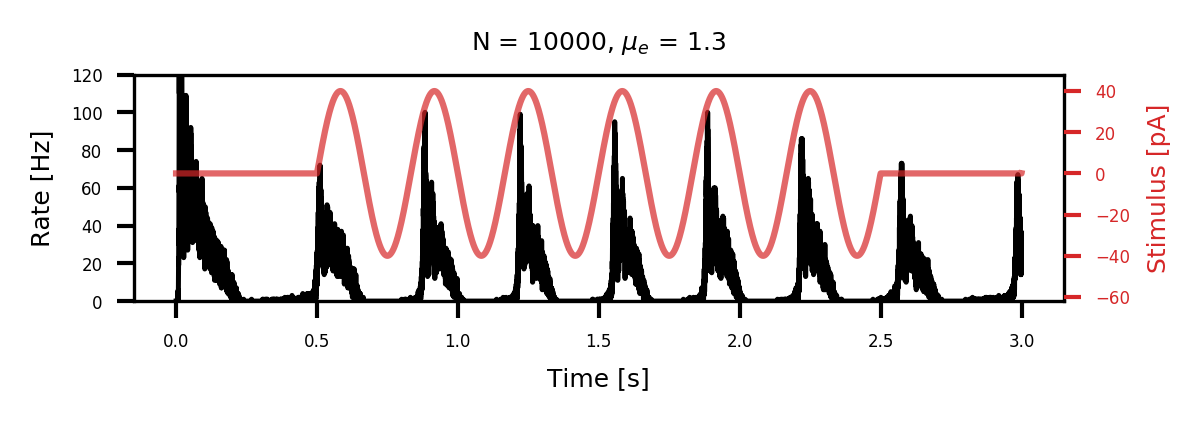

In [18]:
muis = np.linspace(1.3, 1.6, 1)
for mui in muis:
    params = fp.loadpoint_network(params, 'B3')
    params['load_point'] = 'none' # need to set this so it won't be overriden by rm.runModels
    params['sigma_ou'] = 0.0
    params['duration'] = 3000.0            
    params['N'] = 10000
    params['mui_ext_mean'] = mui
    params['model'] = 'brian'
    stim = 'ac'
    stim_amp = 0.4
    stim_freq = 3
    nostim_time = 500
    n_periods = 6
    
    stimulus = construct_stimulus(stim, stim_amp = stim_amp, stim_freq=stim_freq, nostim_before=nostim_time, n_periods=n_periods)
    params['ext_exc_current'] = stimulus 

    t, rates_exc, rates_inh, stimulus = rm.runModels(manual_params=params)
    t/=1000


    plotrange = [0.0, 3.0]

    plotIndex = (t>plotrange[0])&(t<plotrange[1])
    fig = plt.figure(figsize=(4, 1), dpi=300)
    plt.title("N = {}, $\mu_e$ = {}".format(params['N'], params['mui_ext_mean']), fontsize=6)
    ax = plt.gca()
    ax.plot(t[plotIndex], rates_exc[plotIndex], lw=1.2, c='k') 
    ax.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)

    # STIMULUS PLOT
    ax_stimulus = ax.twinx()
    stimulus = np.tile(stimulus, 2)
    stimulus = stimulus[:len(t)]
    ax_stimulus.plot(t[plotIndex], stimulus[plotIndex]*200, c='C3', lw=1.5, alpha=0.7)  

    ax_stimulus.spines['right'].set_visible(False)
    ax_stimulus.spines['top'].set_visible(False)
    ax_stimulus.spines['bottom'].set_visible(False)
    ax_stimulus.spines['left'].set_visible(False)
    ax_stimulus.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)
    ax_stimulus.tick_params('y', colors='C3')

    ax_stimulus.set_ylim(np.round(np.min(stimulus[plotIndex]*200), 2)*1.5-0.01*200, np.round(np.max(stimulus[plotIndex]*200), 2)*1.2)

    ax.set_ylabel("Rate [Hz]", fontsize=6)
    ax.set_xlabel("Time [s]", fontsize=6)
    ax_stimulus.set_ylabel("Stimulus [pA]", fontsize=6, color='C3')
    ax.set_ylim(0, 120)
    plt.show()

Question: does the high-frequency component depend on N?

In [24]:
params = fp.loadpoint_network(params, 'B3')
params['load_point'] = 'none' # need to set this so it won't be overriden by rm.runModels
params['sigma_ou'] = 0.0
params['duration'] = 3000.0            
params['N'] = 50000
params['mui_ext_mean'] = mui
params['model'] = 'brian'
stim = 'ac'
stim_amp = 0.4
stim_freq = 3
nostim_time = 500
n_periods = 6

stimulus = construct_stimulus(stim, stim_amp = stim_amp, stim_freq=stim_freq, nostim_before=nostim_time, n_periods=n_periods)
params['ext_exc_current'] = stimulus 

WARNING    /mnt/antares_raid/home/cakan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
 [py.warnings]
MainProcess py.warnings WARNING  /mnt/antares_raid/home/cakan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.



In [30]:
parametrization = pp.cartesian_product({
    'mui_ext_mean':[ np.float64(round(elem, 3)) for elem in np.linspace(1.0, 1.8, 20)]
})
parametrization['mue_ext_mean'] = np.add(parametrization['mui_ext_mean'], 2.5).tolist()
print("{} parameterizations".format(len(parametrization[parametrization.keys()[0]])))

20 parameterizations


In [31]:
type(parametrization['mue_ext_mean'][0])

float

In [32]:
# ---- initialize pypet environment ----
trajectoryName = 'results' + datetime.datetime.now().strftime("-%Y-%m-%d-%HH-%MM-%SS")
HDF_FILE = os.path.join(paths.HDF_DIR, 'stimulus_adex_reviewer-B3.hdf')
trajectoryFileName = HDF_FILE

import multiprocessing
ncores = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncores))



env = pp.Environment(trajectory=trajectoryName,filename=trajectoryFileName,
                    file_title='adex network bifurcation diagrams with different coupling strengths J',
                    large_overview_tables=True,
                    multiproc=True,           
                    ncores=ncores,
                    wrap_mode='QUEUE',
                    log_stdout = False
                    )

# Get the trajectory from the environment
traj = env.v_trajectory
trajectoryName = traj.v_name

pe.add_parameters(traj, params)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/fastio/cakan/hdf-reviewer-questions/stimulus_adex_reviewer-B3.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.


Number of cores: 80


In [34]:
traj.f_explore(parametrization)
env.f_run(rm.runModels, {'manual_params':params})
env.f_disable_logging()
print("Done.")

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-12-17-12H-49M-54S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2019-12-17-12H-49M-54S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2019-12-17-12H-49M-54S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-12-17-12H-49M-54S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 5

MainProcess pypet INFO     PROGRESS: Finished  1/20 runs [=                   ]  5.0%, remaining: 8:55:14


E spikes: 2656 I spikes: 2797
runtime: 944.3


MainProcess pypet INFO     PROGRESS: Finished  2/20 runs [==                  ] 10.0%, remaining: 4:25:14


E spikes: 3087 I spikes: 4005
runtime: 954.3


MainProcess pypet INFO     PROGRESS: Finished  3/20 runs [===                 ] 15.0%, remaining: 2:47:56


E spikes: 2845 I spikes: 3273
runtime: 954.0


MainProcess pypet INFO     PROGRESS: Finished  4/20 runs [====                ] 20.0%, remaining: 1:59:44


E spikes: 2751 I spikes: 2993
runtime: 986.0


MainProcess pypet INFO     PROGRESS: Finished  5/20 runs [=====               ] 25.0%, remaining: 1:31:40


E spikes: 3023 I spikes: 3736
runtime: 1026.3


MainProcess pypet INFO     PROGRESS: Finished  6/20 runs [======              ] 30.0%, remaining: 1:13:12


E spikes: 3153 I spikes: 4219
runtime: 1082.1


MainProcess pypet INFO     PROGRESS: Finished  7/20 runs [=======             ] 35.0%, remaining: 0:58:44


E spikes: 2947 I spikes: 3528
runtime: 1074.3


MainProcess pypet INFO     PROGRESS: Finished  8/20 runs [========            ] 40.0%, remaining: 0:47:45


E spikes: 3783 I spikes: 5959
runtime: 1098.5


MainProcess pypet INFO     PROGRESS: Finished  9/20 runs [=========           ] 45.0%, remaining: 0:39:08


E spikes: 3249 I spikes: 4518
runtime: 1098.2


MainProcess pypet INFO     PROGRESS: Finished 10/20 runs [==========          ] 50.0%, remaining: 0:32:06


E spikes: 3422 I spikes: 4960
runtime: 1127.1


MainProcess pypet INFO     PROGRESS: Finished 11/20 runs [===========         ] 55.0%, remaining: 0:26:43


E spikes: 3340 I spikes: 4660
runtime: 1140.0
E spikes: 3568 I spikes: 5248
runtime: 1150.8


MainProcess pypet INFO     PROGRESS: Finished 12/20 runs [============        ] 60.0%, remaining: 0:22:03
MainProcess pypet INFO     PROGRESS: Finished 13/20 runs [=============       ] 65.0%, remaining: 0:17:49


E spikes: 4045 I spikes: 6662
runtime: 1173.1


MainProcess pypet INFO     PROGRESS: Finished 14/20 runs [==============      ] 70.0%, remaining: 0:14:16


E spikes: 4194 I spikes: 7021
runtime: 1207.4


MainProcess pypet INFO     PROGRESS: Finished 15/20 runs [===============     ] 75.0%, remaining: 0:11:17


E spikes: 3653 I spikes: 5686
runtime: 1187.2


MainProcess pypet INFO     PROGRESS: Finished 16/20 runs [================    ] 80.0%, remaining: 0:08:28


E spikes: 3912 I spikes: 6297
runtime: 1258.8


MainProcess pypet INFO     PROGRESS: Finished 17/20 runs [=================   ] 85.0%, remaining: 0:06:09


E spikes: 4505 I spikes: 7924
runtime: 1389.6


MainProcess pypet INFO     PROGRESS: Finished 18/20 runs [==================  ] 90.0%, remaining: 0:04:08


E spikes: 4335 I spikes: 7435
runtime: 1431.1


MainProcess pypet INFO     PROGRESS: Finished 19/20 runs [=================== ] 95.0%, remaining: 0:01:58


E spikes: 4644 I spikes: 8373
runtime: 1479.5


MainProcess pypet INFO     PROGRESS: Finished 20/20 runs [====================]100.0%
MainProcess pypet.environment.MultiprocContext INFO     The Storage Queue will no longer accept new data. Hang in there for a little while. There still might be some data in the queue that needs to be stored.
MainProcess pypet.environment.MultiprocContext INFO     The Storage Queue has joined.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-12-17-12H-49M-54S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2019-12-17-12H-49M-54S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
FINISHED all runs of trajectory
`results-2019-12-17-12H-49M-54S`.
************************************************************

MainProcess pypet.environment.Environment INFO     
*****************************************

Done.


In [7]:
HDF_FILE = os.path.join(paths.HDF_DIR, 'stimulus_adex_reviewer-B3.hdf')
trajectoryFileName = HDF_FILE
print(trajectoryFileName)

/mnt/fastio/cakan/hdf-reviewer-questions/stimulus_adex_reviewer-B3.hdf


In [8]:
# ---- load pypet trajectory "trajectoryFileName" ----
print("Analyzing File \"{}\"".format(trajectoryFileName))
print("All Trajectories:")
print(pe.getTrajectoryNameInsideFile(trajectoryFileName))
trajectoryName = pe.getTrajectoryNameInsideFile(trajectoryFileName)[-1]

print("Analyzing trajectory \"{}\".".format(trajectoryName))
trajLoaded = pp.Trajectory(trajectoryName,add_time=False)
trajLoaded.f_load(trajectoryName,filename=trajectoryFileName, force=True)
trajLoaded.v_auto_load = True
print("{} results found".format(len(trajLoaded.f_get_results())))

Analyzing File "/mnt/fastio/cakan/hdf-reviewer-questions/stimulus_adex_reviewer-B3.hdf"
All Trajectories:
[u'results-2019-12-10-12H-44M-40S', u'results-2019-12-10-15H-59M-14S', u'results-2019-12-11-10H-59M-08S', u'results-2019-12-11-11H-01M-49S', u'results-2019-12-17-12H-49M-54S']
Analyzing trajectory "results-2019-12-17-12H-49M-54S".
20 results found


In [9]:
nResults = len(trajLoaded.f_get_run_names()) # number of results in trajectory 
dt = trajLoaded.f_get_parameters()['parameters.simulation.dt'].f_get() # dt of simulation

# ---- explored parameter list ----
exploredParameters = trajLoaded.f_get_explored_parameters()
niceParKeys = [p.split('.')[-1] for p in exploredParameters.keys()]

# ---- lcreate pandas df with results as keys ----
dfResults = pd.DataFrame(columns=niceParKeys,dtype=object)

# range of parameters
for nicep, p in zip(niceParKeys,exploredParameters.keys()):
    dfResults[nicep] = exploredParameters[p].f_get_range()

In [10]:
# ---- make a dictionary with results ----
resultDicts = []
makeDict = True

#measures = ['domfr_exc', 'domfr_power_exc', 'max_exc', 'min_exc', 'updowndiff_exc', 'domfr_inh','domfr_power_inh', 'max_inh', 'min_inh', 'updowndiff_inh'] 
measures = ['max_exc']

for rInd in range(nResults):
    
    #for measure in measures:
        #dfResults.loc[rInd, measure] = func.analyse_run(measure, trajLoaded.results[rInd].f_to_dict(), dt)    
    if makeDict:
            resultDicts.append(trajLoaded.results[rInd].f_to_dict())
            
print("done.")

done.


In [11]:
dfResults

mue_ext_mean  mui_ext_mean
0          3.500         1.000
1          3.542         1.042
2          3.584         1.084
3          3.626         1.126
4          3.668         1.168
5          3.711         1.211
6          3.753         1.253
7          3.795         1.295
8          3.837         1.337
9          3.879         1.379
10         3.921         1.421
11         3.963         1.463
12         4.005         1.505
13         4.047         1.547
14         4.089         1.589
15         4.132         1.632
16         4.174         1.674
17         4.216         1.716
18         4.258         1.758
19         4.300         1.800

270.2


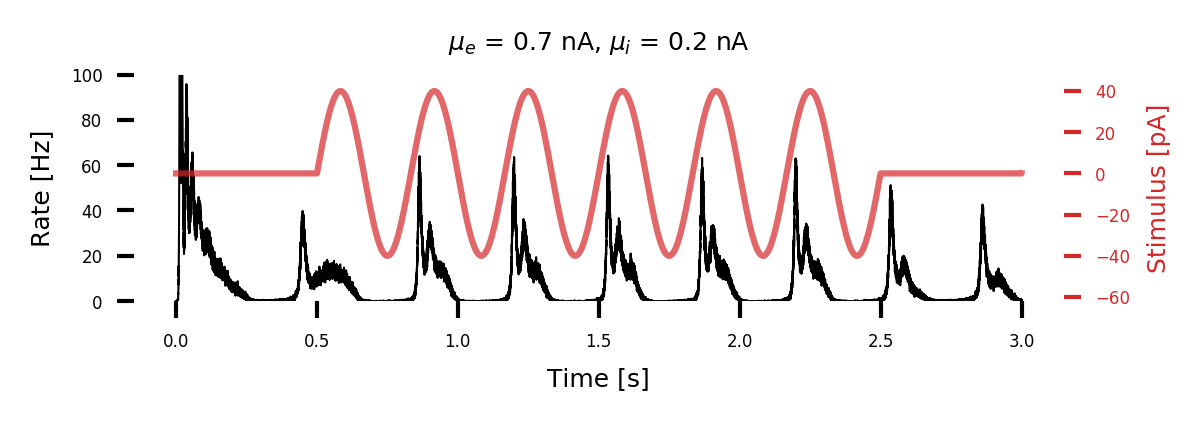

275.8


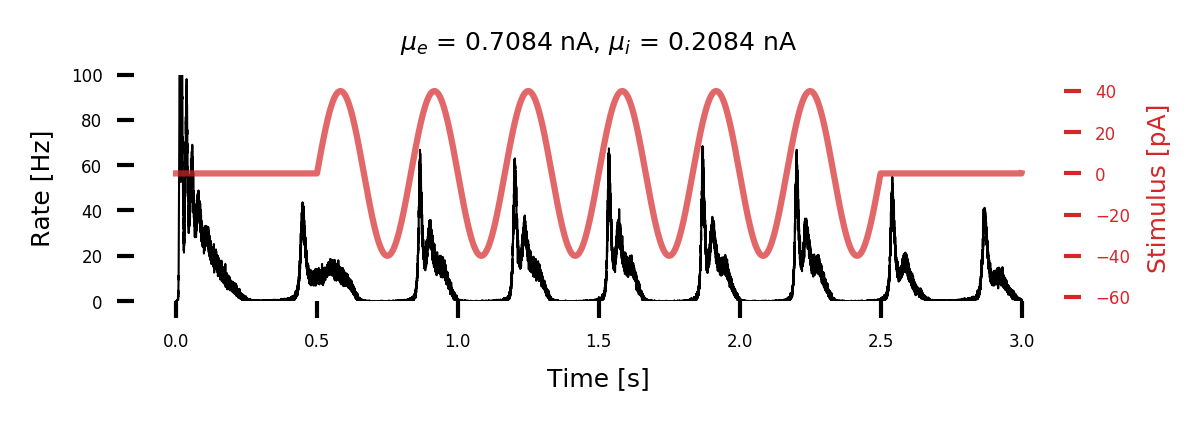

271.6


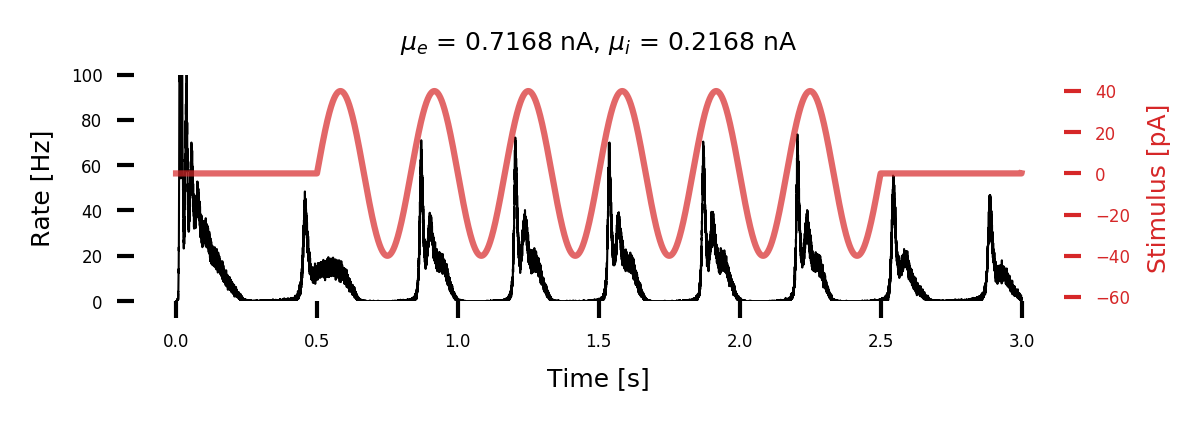

277.4


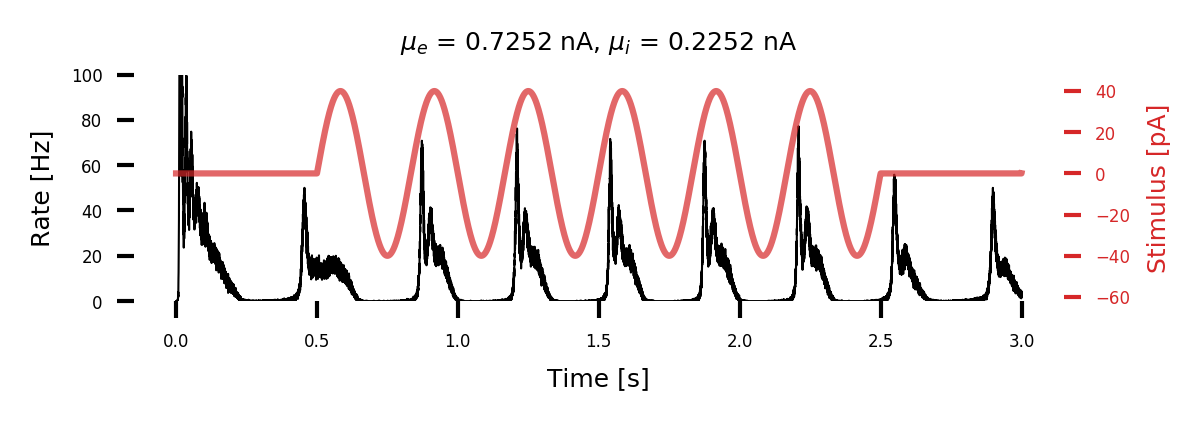

267.2


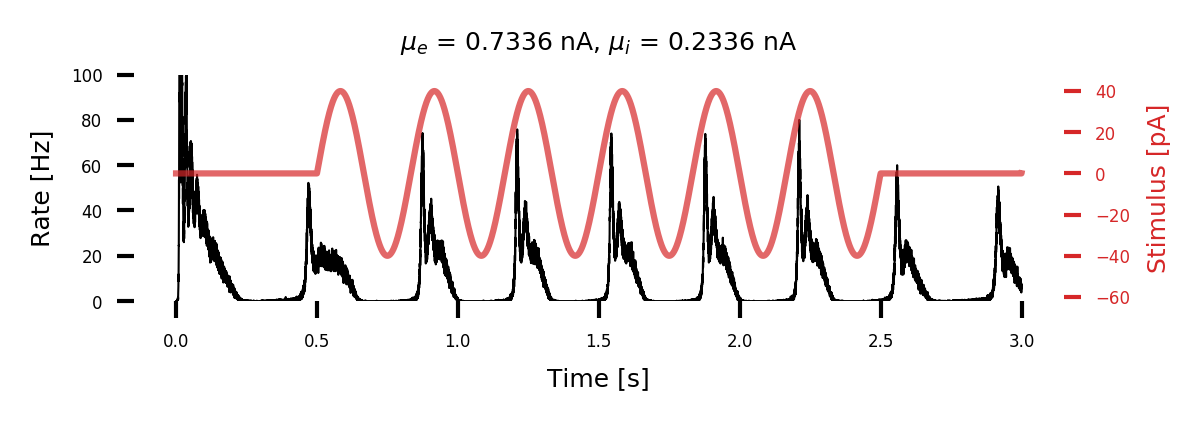

276.8


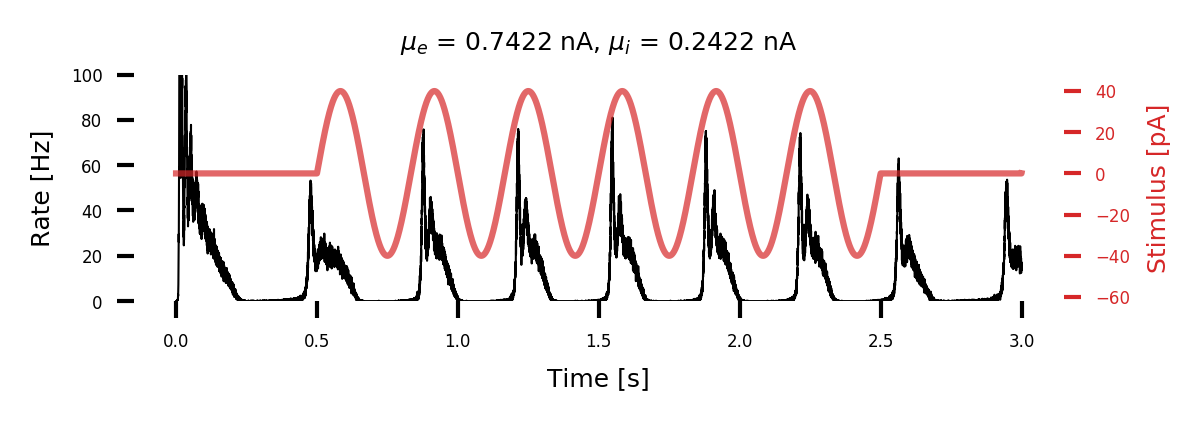

278.0


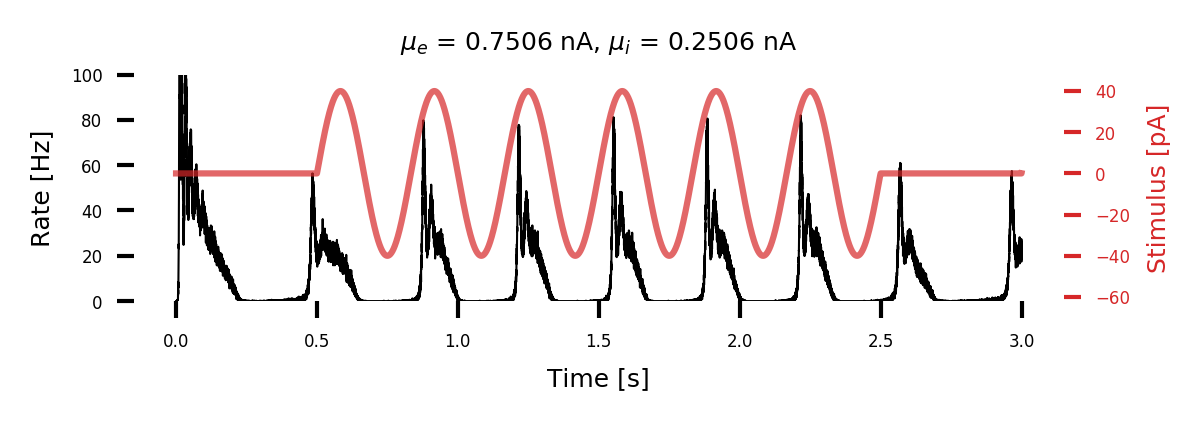

286.2


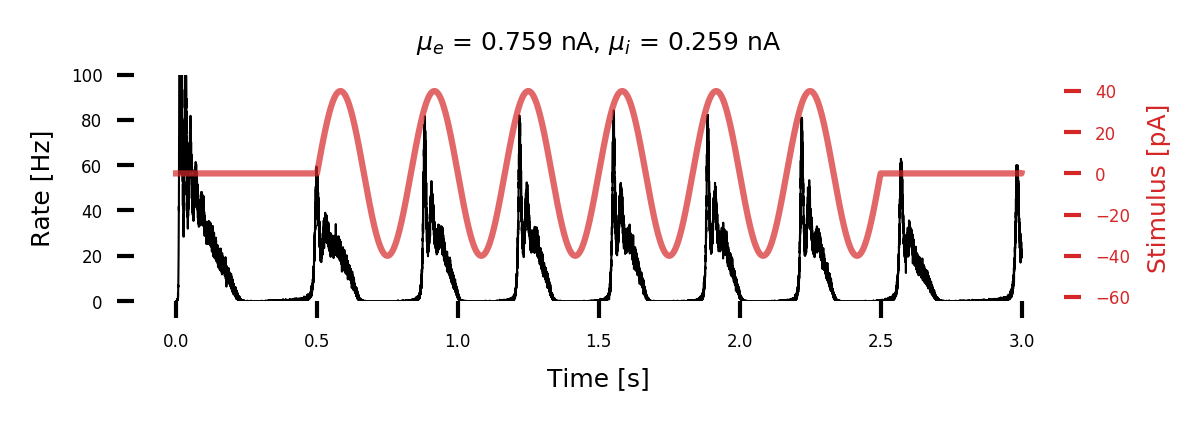

288.6


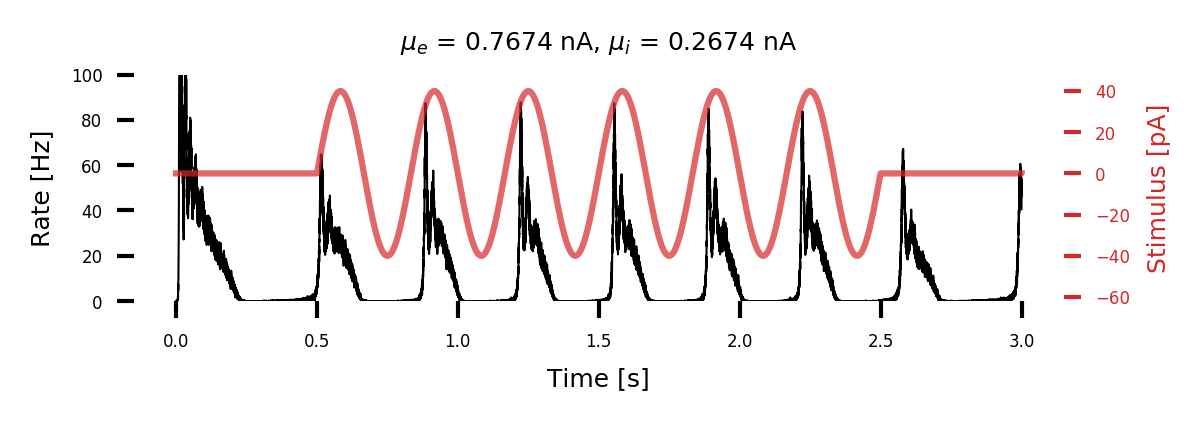

279.4


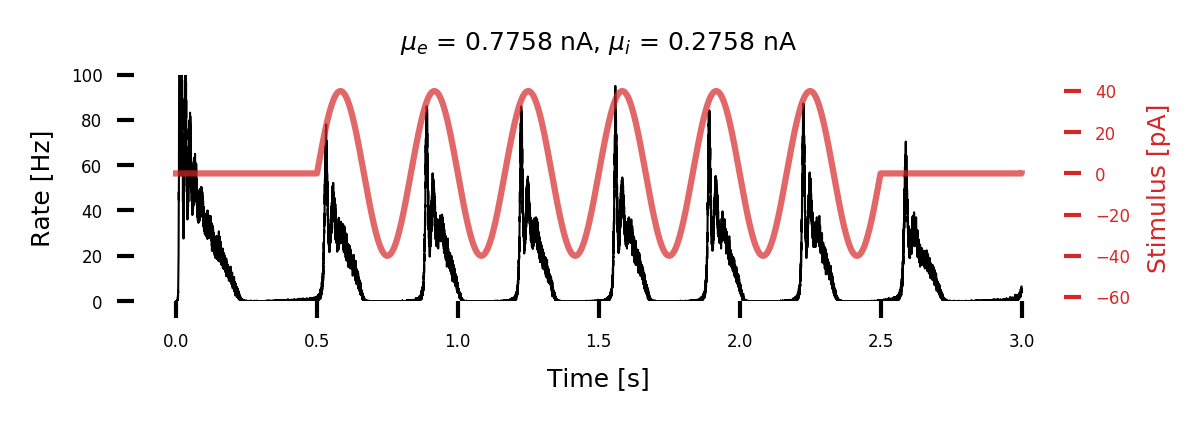

276.8


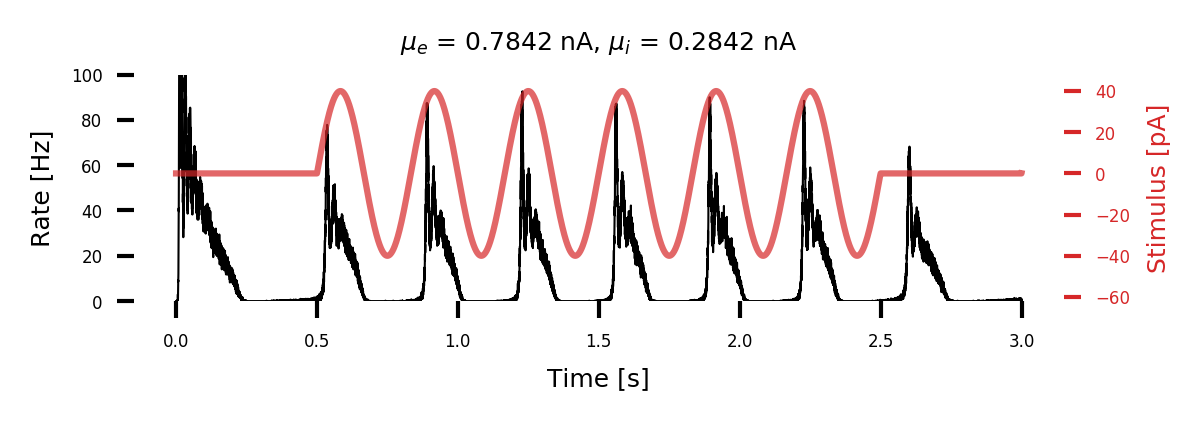

273.0


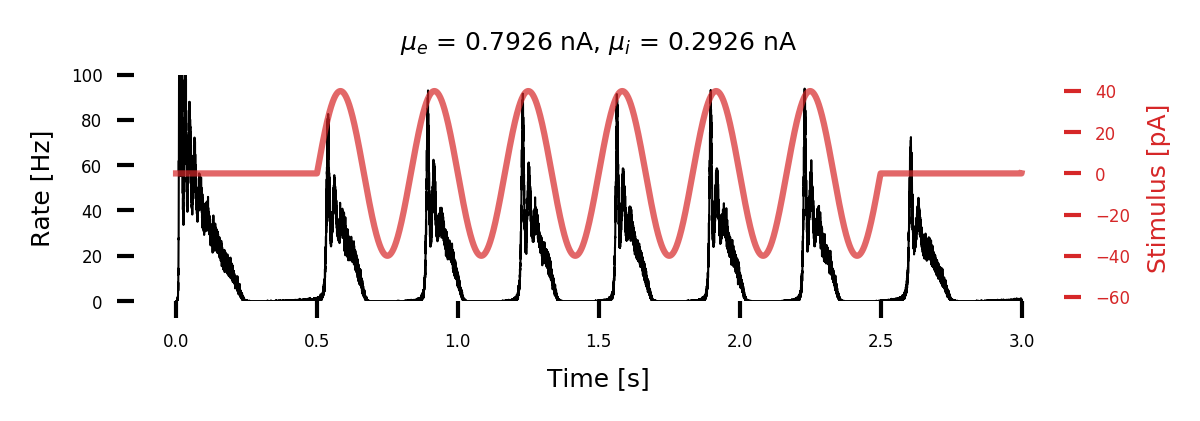

282.2


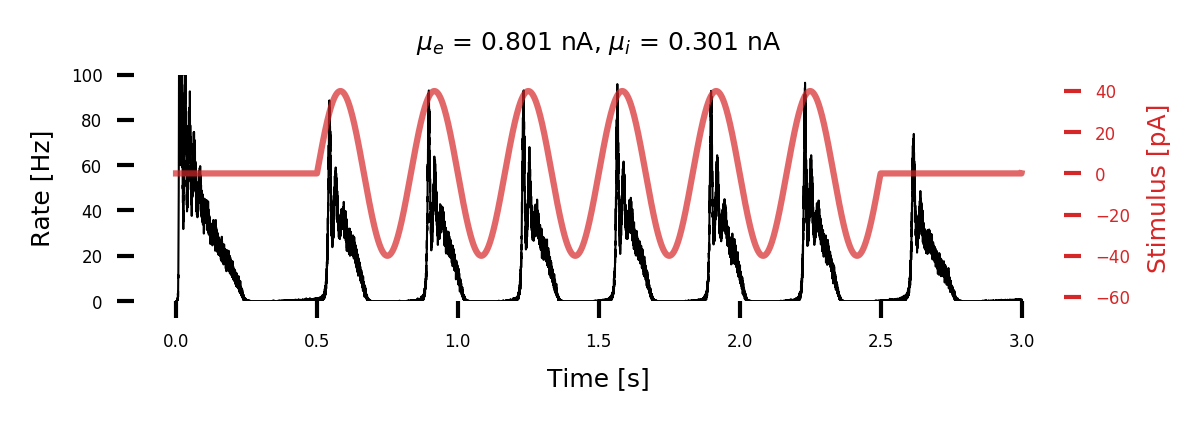

286.4


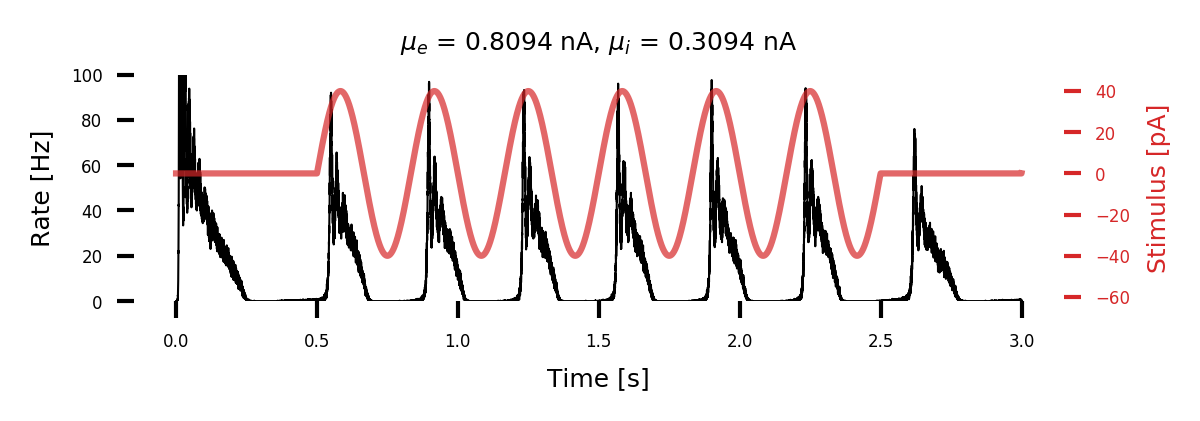

284.4


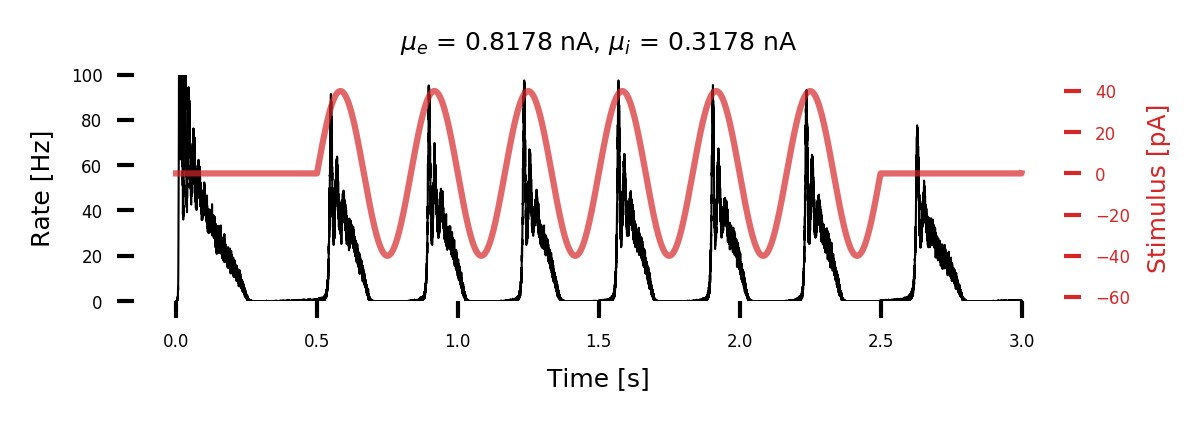

287.4


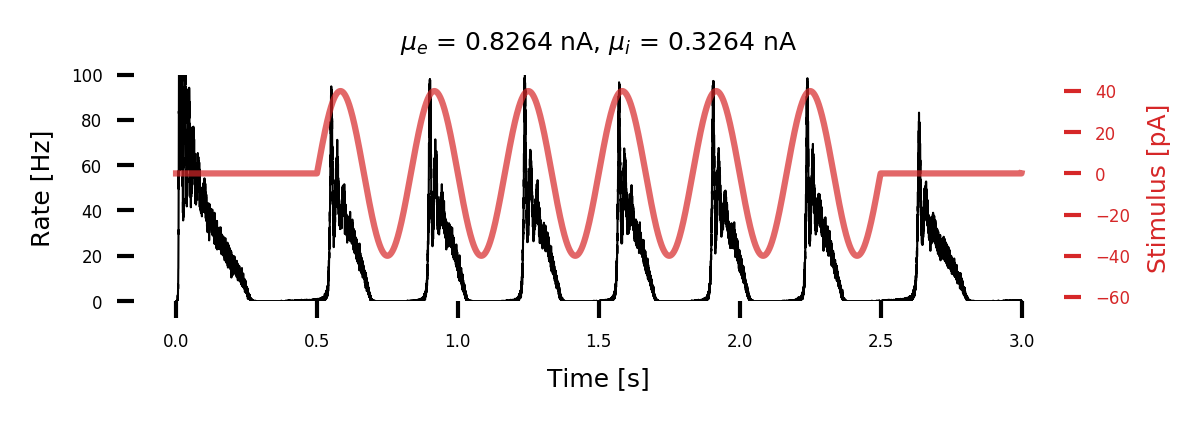

282.4


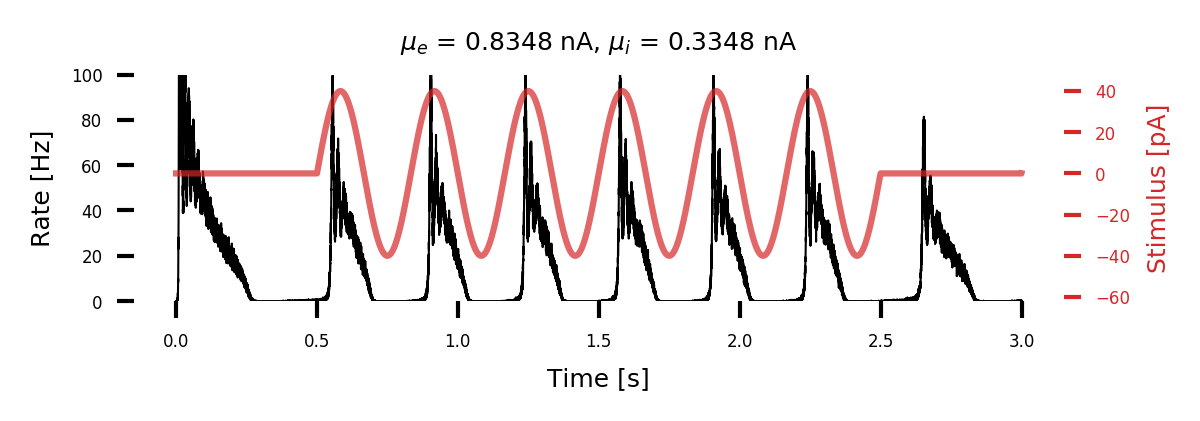

286.0


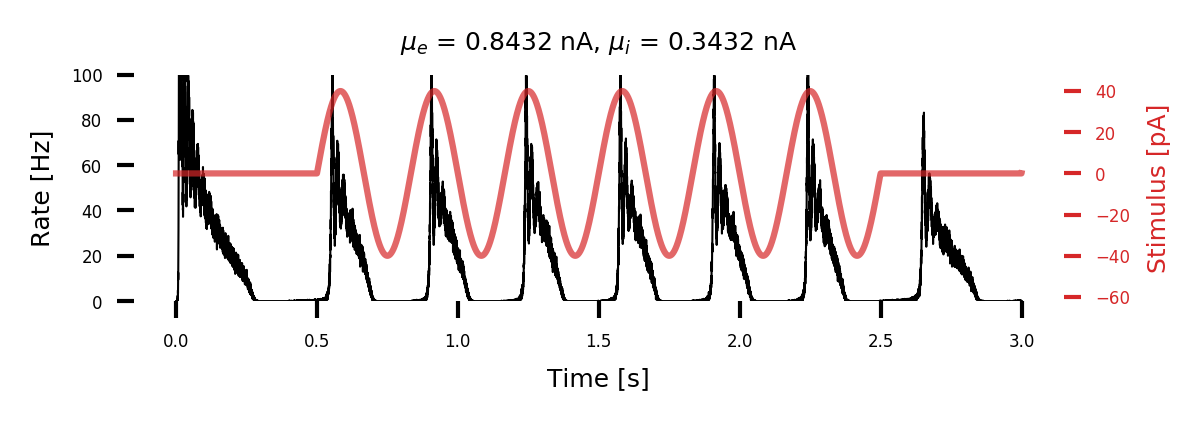

297.6


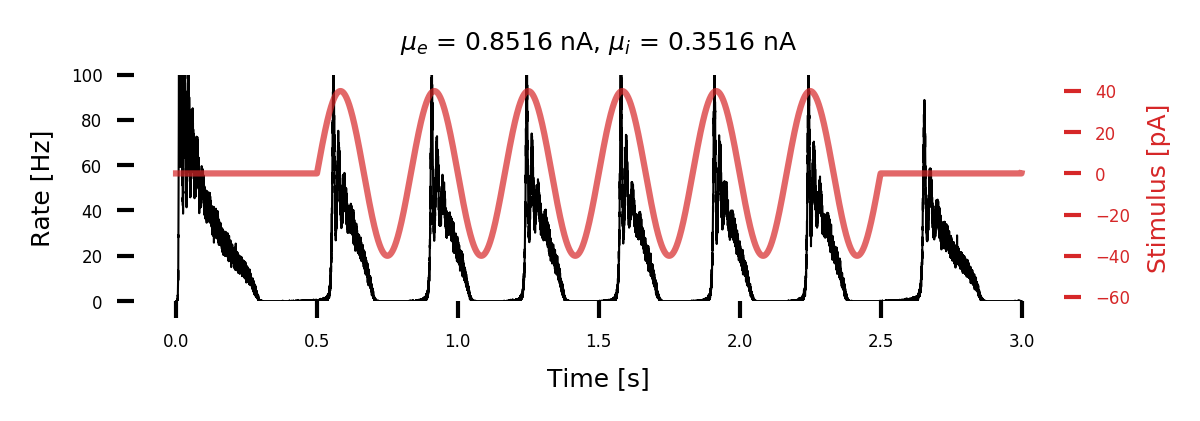

289.4


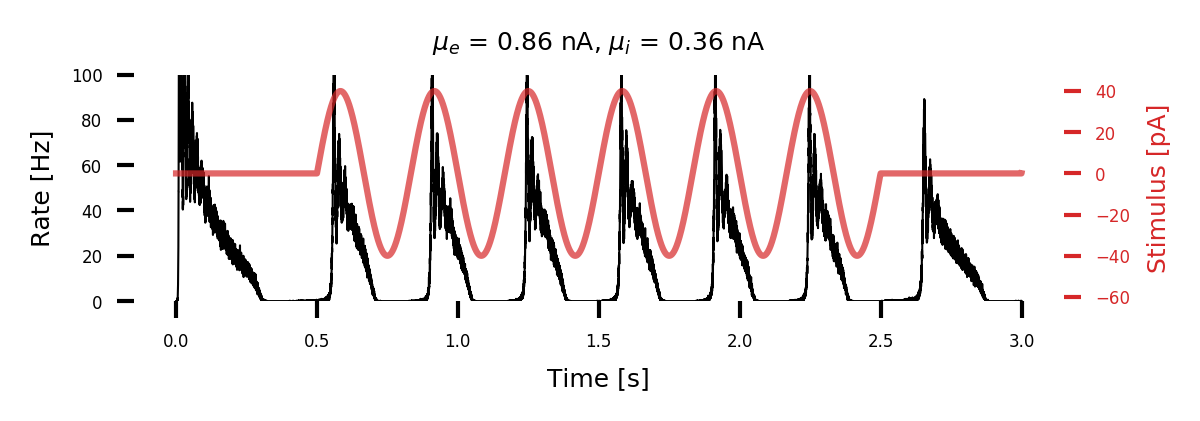

In [13]:
for resInd, res in enumerate(resultDicts):
    stimulus = res['stimulus']
    t = res['t']
    t = t/1000
    rates_exc = res['rate_exc']
    print(max(rates_exc))
    plotrange = [0.0, 3.0]

    plotIndex = (t>plotrange[0])&(t<plotrange[1])
    fig = plt.figure(figsize=(4, 1), dpi=300)
    title = "$\mu_e$ = {} nA, $\mu_i$ = {} nA".format(dfResults.iloc[resInd]['mue_ext_mean']*0.2, dfResults.iloc[resInd]['mui_ext_mean']*0.2)
    plt.title(title, fontsize=6)
    ax = plt.gca()
    ax.plot(t[plotIndex], rates_exc[plotIndex], lw=0.5, c='k') 
    ax.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False) 
    
    # STIMULUS PLOT
    ax_stimulus = ax.twinx()
    stimulus = np.tile(stimulus, 2)
    stimulus = stimulus[:len(t)]
    ax_stimulus.plot(t[plotIndex], stimulus[plotIndex]*200, c='C3', lw=1.5, alpha=0.7)  

    ax_stimulus.spines['right'].set_visible(False)
    ax_stimulus.spines['top'].set_visible(False)
    ax_stimulus.spines['bottom'].set_visible(False)
    ax_stimulus.spines['left'].set_visible(False)
    ax_stimulus.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)
    ax_stimulus.tick_params('y', colors='C3')

    ax_stimulus.set_ylim(np.round(np.min(stimulus[plotIndex]*200), 2)*1.5-0.01*200, np.round(np.max(stimulus[plotIndex]*200), 2)*1.2)

    ax.set_ylabel("Rate [Hz]", fontsize=6)
    ax.set_xlabel("Time [s]", fontsize=6)
    ax_stimulus.set_ylabel("Stimulus [pA]", fontsize=6, color='C3')
    ax.set_ylim(0, 100)
    plt.show()
    
    

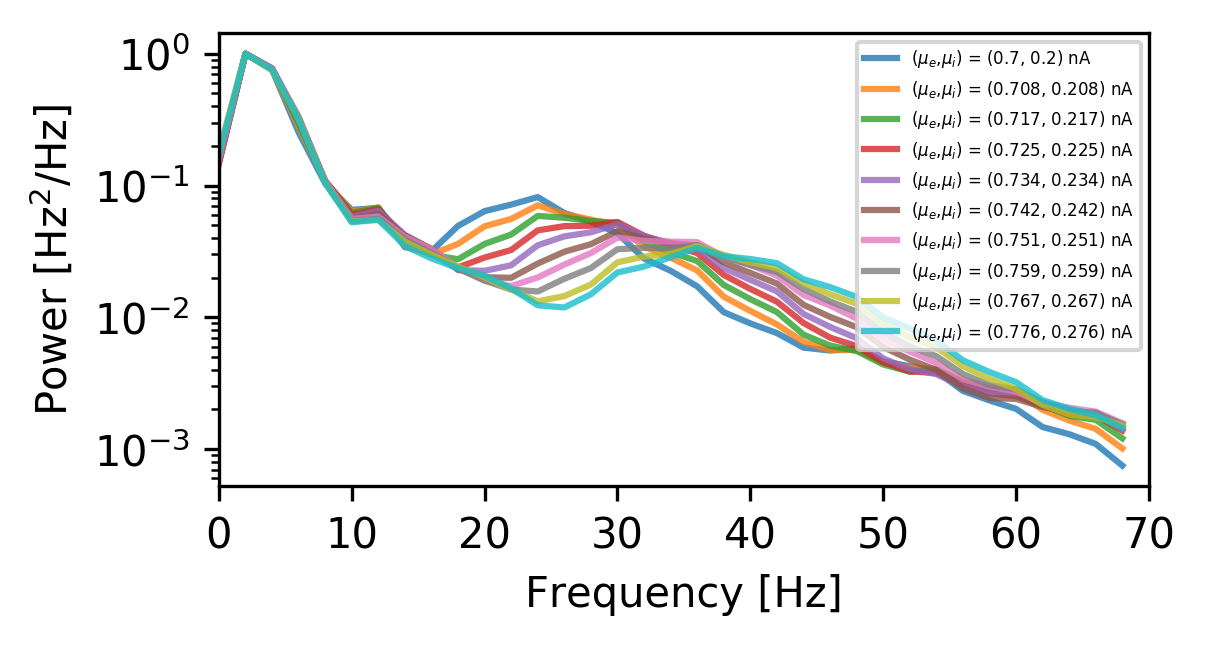

In [88]:
plt.figure(figsize=(4, 2), dpi=300)
for resInd, res in enumerate(resultDicts[:10]):
    stimulus = res['stimulus']
    t = res['t']
    t = t/1000
    title = "N = {}, $\mu_e$ = {} V/s, $\mu_i$ = {} V/s".format(params['N'], dfResults.iloc[resInd]['mue_ext_mean'], dfResults.iloc[resInd]['mui_ext_mean'])
    #### SPECTRUM
    
    oscrange = [0.5, 2.5]
    plotIndex = (t>oscrange[0])&(t<oscrange[1])
    rates_exc = res['rate_exc'][plotIndex]
    
    spectrum_windowsize = 0.5 
    f, Pxx_spec = scipy.signal.welch(
    rates_exc,
    1000/params['dt'],
    window='hanning',
    nperseg=int(spectrum_windowsize * 1000 / dt),
    scaling='spectrum')
    f = f[f < 70]
    Pxx_spec = Pxx_spec[0:len(f)]
    Pxx_spec /= np.max(Pxx_spec)

    label = "($\mu_e$,$\mu_i$) = ({:.3}, {:.3}) nA".format(dfResults.iloc[resInd]['mue_ext_mean']*0.2, dfResults.iloc[resInd]['mui_ext_mean']*0.2)
    plt.semilogy(f, Pxx_spec, alpha=0.8, label=label)

#plt.title(title, fontsize=4)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [Hz$^2$/Hz]")
plt.legend(loc=1, fontsize=4)
plt.xlim(0, 70)
plt.show()    
    

# Point A1

In [8]:
points = ['A1', 'A2', 'A3', 'B3', 'B4']
protocols = ['dc', 'dc', 'rect', 'ac', 'ac']
amps = [0.3, 0.2, 0.5, 0.4, 0.4]
freqs = [2, 2, 3, 3, 4]

params = fp.loadpoint_network(params, 'A1')
params['load_point'] = 'none' # need to set this so it won't be overriden by rm.runModels
params['sigma_ou'] = 0.0
params['duration'] = 3000.0            
params['N'] = 1000
params['model'] = 'brian'
stim = protocols[0]
stim_amp = amps[0]
stim_freq = 0.5
nostim_time = 500
n_periods = 0

In [9]:
params['seed'] = 42

Simulating 1000 excitatory and 1000 inhibitory neurons (total 2000) ...
E spikes: 1702 I spikes: 1027
runtime: 25.7


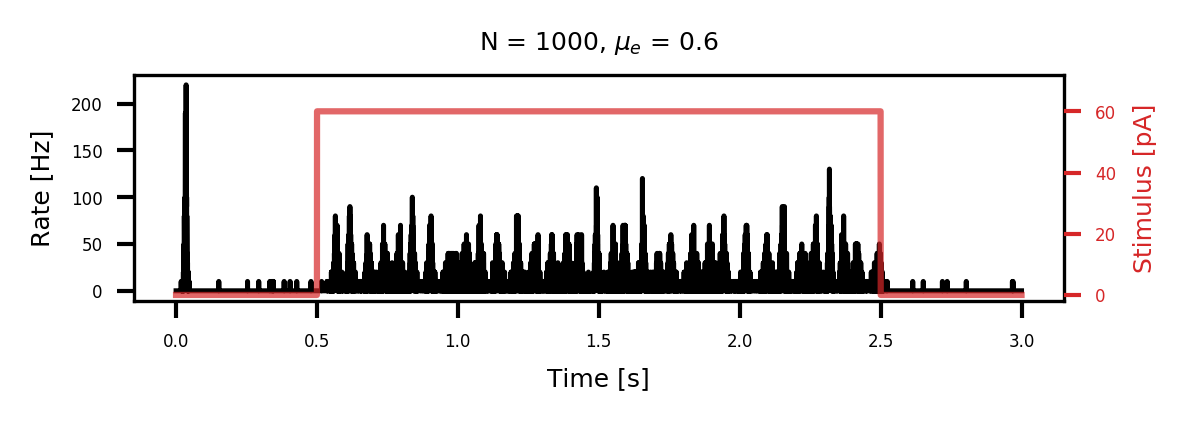

In [17]:
params = fp.loadpoint_network(params, 'A1')
params['load_point'] = 'none' # need to set this so it won't be overriden by rm.runModels
params['sigma_ou'] = 0.0
params['duration'] = 3000.0            
params['N'] = 1000
params['model'] = 'brian'
stim = protocols[0]
stim_amp = amps[0]
stim_freq = 0.5
nostim_time = 500
n_periods = 0

params['seed'] = 42
for i in range(1):
    stimulus = construct_stimulus(stim, stim_amp = stim_amp, stim_freq=stim_freq, nostim_before=nostim_time, n_periods=n_periods)
    params['ext_exc_current'] = stimulus 

    t, rates_exc, rates_inh, stimulus = rm.runModels(manual_params=params)
    t/=1000


    plotrange = [0.0, 3.2]

    plotIndex = (t>plotrange[0])&(t<plotrange[1])
    fig = plt.figure(figsize=(4, 1), dpi=300)
    plt.title("N = {}, $\mu_e$ = {}".format(params['N'], params['mui_ext_mean']), fontsize=6)
    ax = plt.gca()
    ax.plot(t[plotIndex], rates_exc[plotIndex], lw=1.2, c='k') 
    ax.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)

    # STIMULUS PLOT
    ax_stimulus = ax.twinx()
    stimulus = np.tile(stimulus, 2)
    stimulus = stimulus[:len(t)]
    ax_stimulus.plot(t[plotIndex], stimulus[plotIndex]*200, c='C3', lw=1.5, alpha=0.7)  

    ax_stimulus.spines['right'].set_visible(False)
    ax_stimulus.spines['top'].set_visible(False)
    ax_stimulus.spines['bottom'].set_visible(False)
    ax_stimulus.spines['left'].set_visible(False)
    ax_stimulus.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)
    ax_stimulus.tick_params('y', colors='C3')

    ax_stimulus.set_ylim(np.round(np.min(stimulus[plotIndex]*200), 2)*1.5-0.01*200, np.round(np.max(stimulus[plotIndex]*200), 2)*1.2)

    ax.set_ylabel("Rate [Hz]", fontsize=6)
    ax.set_xlabel("Time [s]", fontsize=6)
    ax_stimulus.set_ylabel("Stimulus [pA]", fontsize=6, color='C3')
    #ax.set_ylim(0, 60)
    plt.show()

In [18]:
paths.HDF_DIR = '/mnt/fastio/cakan/hdf-reviewer-questions'
paths.BRIAN2_COMPILE_DIR = '/mnt/fastio/cakan/brian2_compile/'

import pypet as pp
import datetime
import pypet_parameters as pe
import pandas as pd

parametrization = pp.cartesian_product({
    'seed':[ int(elem) for elem in np.linspace(1.0, 1.8, 20)],
    'N' : [5000, 10000, 25000, 50000]
})
print("{} parameterizations".format(len(parametrization[parametrization.keys()[0]])))

# ---- initialize pypet environment ----
trajectoryName = 'results' + datetime.datetime.now().strftime("-%Y-%m-%d-%HH-%MM-%SS")
HDF_FILE = os.path.join(paths.HDF_DIR, 'stimulus_adex_reviewer-A1.hdf')
trajectoryFileName = HDF_FILE

import multiprocessing
ncores = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncores))



env = pp.Environment(trajectory=trajectoryName,filename=trajectoryFileName,
                    file_title='adex network bifurcation diagrams with different coupling strengths J',
                    large_overview_tables=True,
                    multiproc=True,           
                    ncores=ncores,
                    wrap_mode='QUEUE',
                    log_stdout = False
                    )

# Get the trajectory from the environment
traj = env.v_trajectory
trajectoryName = traj.v_name

pe.add_parameters(traj, params)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/fastio/cakan/hdf-reviewer-questions/stimulus_adex_reviewer.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.


80 parameterizations
Number of cores: 80


In [19]:
traj.f_explore(parametrization)
env.f_run(rm.runModels, {'manual_params':params})
env.f_disable_logging()
print("Done.")

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-12-11-22H-25M-11S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2019-12-11-22H-25M-11S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2019-12-11-22H-25M-11S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-12-11-22H-25M-11S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

Simulating 10000 excitatory and 10000 inhibitory neurons (total 20000) ...
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
Simulating 25000 excitatory and 25000 inhibitory neurons (total 50000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 25000 excitatory and 25000 inhibitory neurons (total 50000) ...
Simulating 10000 excitatory and 10000 inhibitory neurons (total 20000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
Simulating 10000 excitatory and 10000 inhibitory neurons (total 20000) ...
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
Simulating 25000 excitatory and 25000 inhibitory neurons (total 50000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 10000 excitatory an

MainProcess pypet INFO     PROGRESS: Finished  4/80 runs [=                   ]  5.0%, remaining: 0:39:54


E spikes: 1780 I spikes: 1075
E spikes: 1804 I spikes: 1004
runtime: 107.7
E spikes: 1774 I spikes: 1039
runtime: 107.5
runtime: 108.3
E spikes: 1804 I spikes: 1079


MainProcess pypet INFO     PROGRESS: Finished  8/80 runs [==                  ] 10.0%, remaining: 0:19:22


E spikes: 1775 I spikes: 1092
runtime: 109.3
runtime: 109.7
E spikes: 1732 I spikes: 1018
runtime: 119.2
E spikes: 1808 I spikes: 1053


MainProcess pypet INFO     PROGRESS: Finished 12/80 runs [===                 ] 15.0%, remaining: 0:13:09


runtime: 119.8
E spikes: 1792 I spikes: 1007
runtime: 122.1
E spikes: 1730 I spikes: 1026
runtime: 124.0
E spikes: 1754 I spikes: 1063
E spikes: 1778 I spikes: 1025
runtime: 122.9
runtime: 124.3


MainProcess pypet INFO     PROGRESS: Finished 16/80 runs [====                ] 20.0%, remaining: 0:09:36


E spikes: 1784 I spikes: 1019
E spikes: 1814 I spikes: 1014
runtime: 124.6
runtime: 125.6
E spikes: 1791 I spikes: 1023
runtime: 121.6


MainProcess pypet INFO     PROGRESS: Finished 20/80 runs [=====               ] 25.0%, remaining: 0:07:20


E spikes: 1738 I spikes: 995
runtime: 161.0
E spikes: 1750 I spikes: 1025
runtime: 157.5
E spikes: 1796 I spikes: 1075
runtime: 163.3
E spikes: 1781 I spikes: 1061
runtime: 162.9
E spikes: 1757 I spikes: 1064
runtime: 161.7


MainProcess pypet INFO     PROGRESS: Finished 24/80 runs [======              ] 30.0%, remaining: 0:10:03


E spikes: 1774 I spikes: 1047
runtime: 167.5
E spikes: 1688 I spikes: 1054
runtime: 168.6
E spikes: 1763 I spikes: 1018
runtime: 166.5


MainProcess pypet INFO     PROGRESS: Finished 28/80 runs [=======             ] 35.0%, remaining: 0:08:06


E spikes: 1813 I spikes: 1048
runtime: 176.5
E spikes: 1794 I spikes: 1042
E spikes: 1774 I spikes: 1058
runtime: 166.3
runtime: 174.6
E spikes: 1725 I spikes: 988
runtime: 170.6
E spikes: 1793 I spikes: 993
runtime: 188.1


MainProcess pypet INFO     PROGRESS: Finished 32/80 runs [========            ] 40.0%, remaining: 0:06:53


E spikes: 1769 I spikes: 1086
runtime: 148.6
E spikes: 1783 I spikes: 1064
runtime: 169.1
E spikes: 1831 I spikes: 995
runtime: 190.6


MainProcess pypet INFO     PROGRESS: Finished 36/80 runs [=========           ] 45.0%, remaining: 0:06:16


E spikes: 1766 I spikes: 1030
runtime: 205.1
E spikes: 1772 I spikes: 1010
runtime: 189.8
E spikes: 1831 I spikes: 1098
runtime: 197.2
E spikes: 1765 I spikes: 1064
runtime: 212.0


MainProcess pypet INFO     PROGRESS: Finished 40/80 runs [==========          ] 50.0%, remaining: 0:05:23


E spikes: 1796 I spikes: 1045
runtime: 306.3
E spikes: 1795 I spikes: 1056
runtime: 323.6
E spikes: 1814 I spikes: 1037
runtime: 310.8
E spikes: 1735 I spikes: 1053
runtime: 330.4


MainProcess pypet INFO     PROGRESS: Finished 44/80 runs [===========         ] 55.0%, remaining: 0:09:37


E spikes: 1798 I spikes: 1045
runtime: 333.7
E spikes: 1820 I spikes: 1081
runtime: 349.1
E spikes: 1756 I spikes: 1061
runtime: 375.9
E spikes: 1762 I spikes: 1037
runtime: 354.6


MainProcess pypet INFO     PROGRESS: Finished 48/80 runs [============        ] 60.0%, remaining: 0:08:14


E spikes: 1759 I spikes: 1049
runtime: 375.1
E spikes: 1755 I spikes: 1041
runtime: 357.5
E spikes: 1785 I spikes: 1022
runtime: 369.0
E spikes: 1800 I spikes: 1031
runtime: 363.7


MainProcess pypet INFO     PROGRESS: Finished 52/80 runs [=============       ] 65.0%, remaining: 0:06:48


E spikes: 1768 I spikes: 1075
runtime: 353.1
E spikes: 1759 I spikes: 1067
runtime: 381.6
E spikes: 1805 I spikes: 1029
runtime: 364.8
E spikes: 1810 I spikes: 1042
runtime: 344.8
E spikes: 1753 I spikes: 1014


MainProcess pypet INFO     PROGRESS: Finished 56/80 runs [==============      ] 70.0%, remaining: 0:05:31


runtime: 369.5
E spikes: 1763 I spikes: 987
runtime: 350.4
E spikes: 1768 I spikes: 1010
runtime: 380.7
E spikes: 1741 I spikes: 1071
runtime: 375.9


MainProcess pypet INFO     PROGRESS: Finished 60/80 runs [===============     ] 75.0%, remaining: 0:04:28


E spikes: 1743 I spikes: 1023
runtime: 504.1
E spikes: 1765 I spikes: 1059
runtime: 680.3
E spikes: 1737 I spikes: 1068
runtime: 681.4
E spikes: 1762 I spikes: 1018
runtime: 679.7


MainProcess pypet INFO     PROGRESS: Finished 64/80 runs [================    ] 80.0%, remaining: 0:07:38


E spikes: 1776 I spikes: 1039
runtime: 678.8
E spikes: 1797 I spikes: 1069
runtime: 645.0
E spikes: 1780 I spikes: 1070
runtime: 625.7
E spikes: 1805 I spikes: 1039
runtime: 654.9
E spikes: 1736 I spikes: 1024
runtime: 652.5


MainProcess pypet INFO     PROGRESS: Finished 68/80 runs [=================   ] 85.0%, remaining: 0:05:30


E spikes: 1738 I spikes: 1064
runtime: 676.9
E spikes: 1742 I spikes: 990
runtime: 640.6
E spikes: 1765 I spikes: 1029
runtime: 647.4


MainProcess pypet INFO     PROGRESS: Finished 72/80 runs [==================  ] 90.0%, remaining: 0:03:29


E spikes: 1765 I spikes: 1003
runtime: 650.5
E spikes: 1789 I spikes: 1067
runtime: 657.0
E spikes: 1838 I spikes: 1017
runtime: 671.7
E spikes: 1806 I spikes: 1031
runtime: 669.2
E spikes: 1782 I spikes: 985
runtime: 657.9


MainProcess pypet INFO     PROGRESS: Finished 76/80 runs [=================== ] 95.0%, remaining: 0:01:40


E spikes: 1734 I spikes: 1029
runtime: 651.5
E spikes: 1716 I spikes: 1054
runtime: 646.3
E spikes: 1800 I spikes: 1060
runtime: 662.1


MainProcess pypet INFO     PROGRESS: Finished 80/80 runs [====================]100.0%
MainProcess pypet.environment.MultiprocContext INFO     The Storage Queue will no longer accept new data. Hang in there for a little while. There still might be some data in the queue that needs to be stored.
MainProcess pypet.environment.MultiprocContext INFO     The Storage Queue has joined.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-12-11-22H-25M-11S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2019-12-11-22H-25M-11S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
FINISHED all runs of trajectory
`results-2019-12-11-22H-25M-11S`.
************************************************************

MainProcess pypet.environment.Environment INFO     
*****************************************

Done.


In [60]:
HDF_FILE = os.path.join(paths.HDF_DIR, 'stimulus_adex_reviewer-A1.hdf')
trajectoryFileName = HDF_FILE

In [61]:
# ---- load pypet trajectory "trajectoryFileName" ----
print("Analyzing File \"{}\"".format(trajectoryFileName))
print("All Trajectories:")
print(pe.getTrajectoryNameInsideFile(trajectoryFileName))
trajectoryName = pe.getTrajectoryNameInsideFile(trajectoryFileName)[-1]

print("Analyzing trajectory \"{}\".".format(trajectoryName))
trajLoaded = pp.Trajectory(trajectoryName,add_time=False)
trajLoaded.f_load(trajectoryName,filename=trajectoryFileName, force=True)
trajLoaded.v_auto_load = True
print("{} results found".format(len(trajLoaded.f_get_results())))



nResults = len(trajLoaded.f_get_run_names()) # number of results in trajectory 
dt = trajLoaded.f_get_parameters()['parameters.simulation.dt'].f_get() # dt of simulation

# ---- explored parameter list ----
exploredParameters = trajLoaded.f_get_explored_parameters()
niceParKeys = [p.split('.')[-1] for p in exploredParameters.keys()]

# ---- lcreate pandas df with results as keys ----
dfResults = pd.DataFrame(columns=niceParKeys,dtype=object)

# range of parameters
for nicep, p in zip(niceParKeys,exploredParameters.keys()):
    dfResults[nicep] = exploredParameters[p].f_get_range()
    
    
# ---- make a dictionary with results ----
resultDicts = []
makeDict = True

#measures = ['domfr_exc', 'domfr_power_exc', 'max_exc', 'min_exc', 'updowndiff_exc', 'domfr_inh','domfr_power_inh', 'max_inh', 'min_inh', 'updowndiff_inh'] 
measures = ['max_exc']

for rInd in range(nResults):
    
    #for measure in measures:
        #dfResults.loc[rInd, measure] = func.analyse_run(measure, trajLoaded.results[rInd].f_to_dict(), dt)    
    if makeDict:
            resultDicts.append(trajLoaded.results[rInd].f_to_dict())
            
print("done.")    

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/fastio/cakan/hdf-reviewer-questions/stimulus_adex_reviewer-A1.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2019-12-11-22H-25M-11S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.


Analyzing File "/mnt/fastio/cakan/hdf-reviewer-questions/stimulus_adex_reviewer-A1.hdf"
All Trajectories:
[u'results-2019-12-11-22H-25M-11S']
Analyzing trajectory "results-2019-12-11-22H-25M-11S".
80 results found
done.


180.0


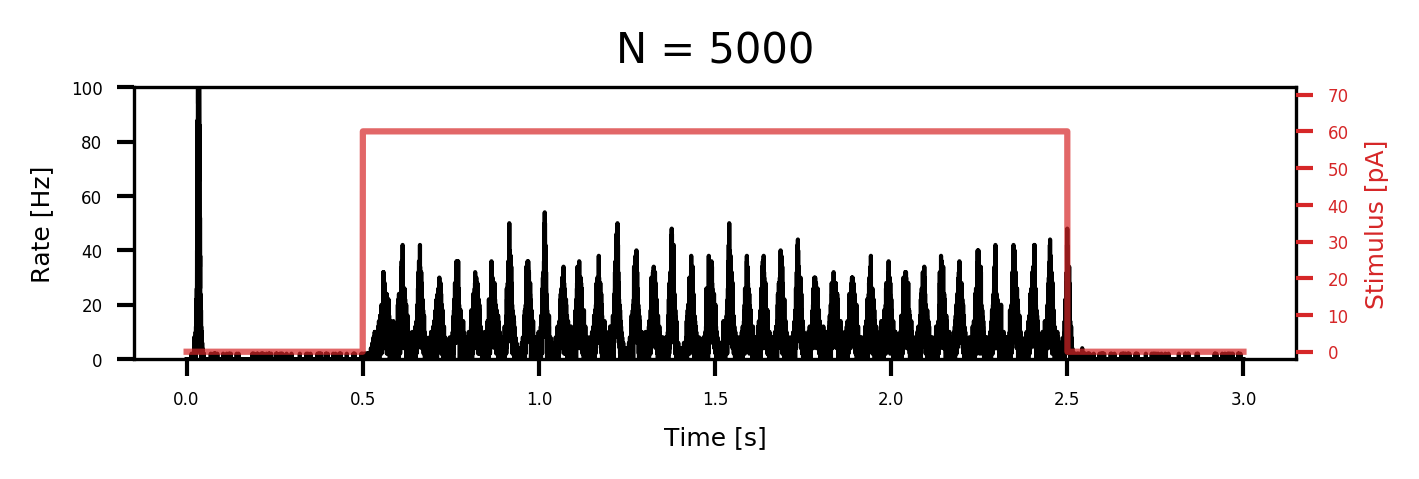

172.0


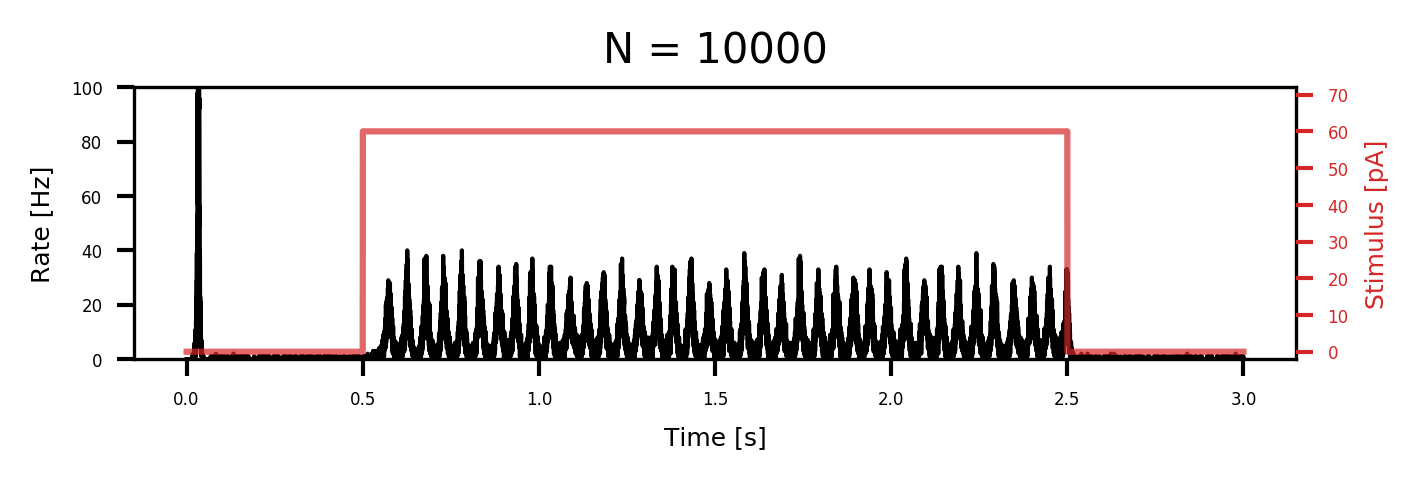

156.4


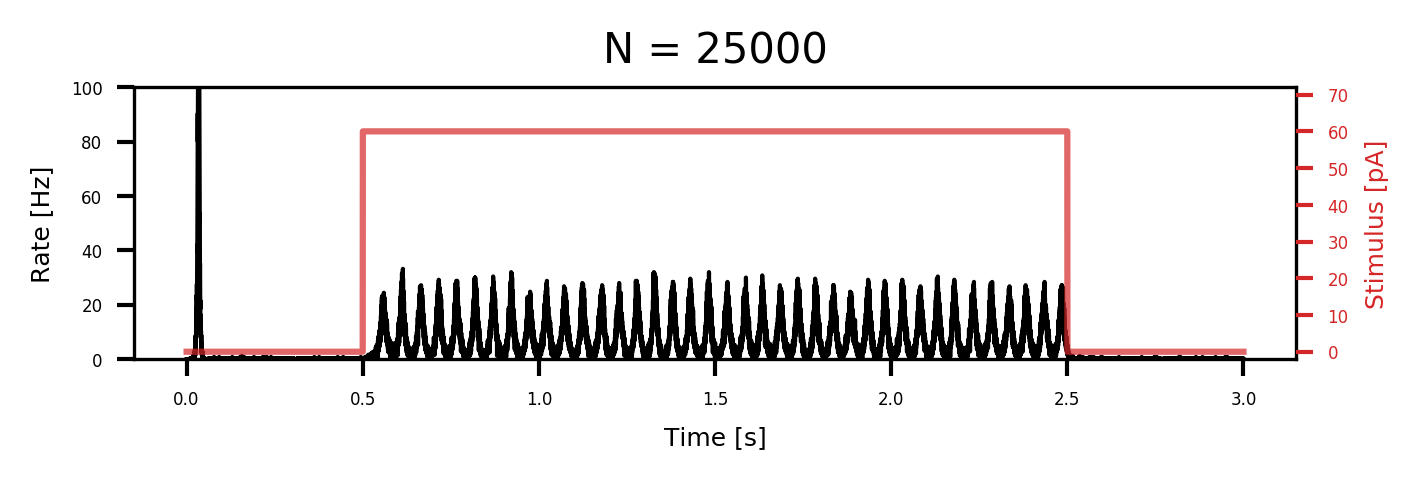

155.8


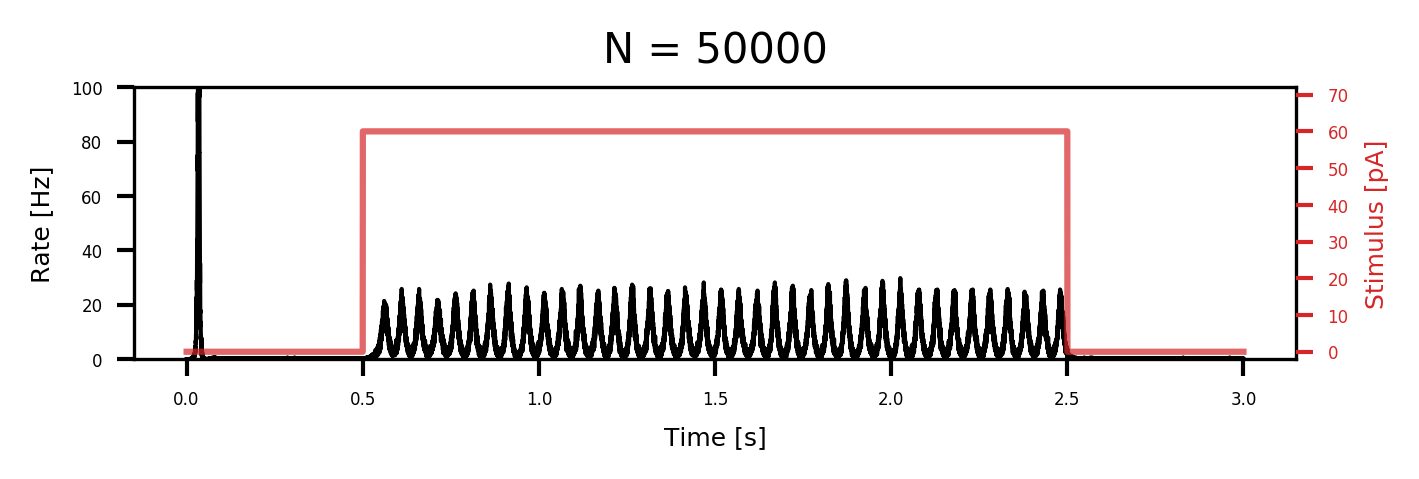

In [21]:
for resInd, res in enumerate(resultDicts[:4]):
    stimulus = res['stimulus']
    t = res['t']
    t = t/1000
    rates_exc = res['rate_exc']
    print(max(rates_exc))
    plotrange = [0.0, 3.0]
    
    plotIndex = (t>plotrange[0])&(t<plotrange[1])
    fig = plt.figure(figsize=(5, 1.2), dpi=300)
    plt.title("N = {}".format(dfResults.iloc[resInd]['N']), fontsize=10)
    ax = plt.gca()
    ax.plot(t[plotIndex], rates_exc[plotIndex], lw=1.0, c='k') 
    ax.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)
    
    # STIMULUS PLOT
    ax_stimulus = ax.twinx()
    stimulus = np.tile(stimulus, 2)
    stimulus = stimulus[:len(t)]
    ax_stimulus.plot(t[plotIndex], stimulus[plotIndex]*200, c='C3', lw=1.5, alpha=0.7)  
    
    ax_stimulus.spines['right'].set_visible(False)
    ax_stimulus.spines['top'].set_visible(False)
    ax_stimulus.spines['bottom'].set_visible(False)
    ax_stimulus.spines['left'].set_visible(False)
    ax_stimulus.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)
    ax_stimulus.tick_params('y', colors='C3')
    
    ax_stimulus.set_ylim(np.round(np.min(stimulus[plotIndex]*200), 2)*1.5-0.01*200, np.round(np.max(stimulus[plotIndex]*200), 2)*1.2)
    
    ax.set_ylabel("Rate [Hz]", fontsize=6)
    ax.set_xlabel("Time [s]", fontsize=6)
    ax_stimulus.set_ylabel("Stimulus [pA]", fontsize=6, color='C3')
    ax.set_ylim(0, 100)
    plt.show()

In [22]:
len(resultDicts)

80

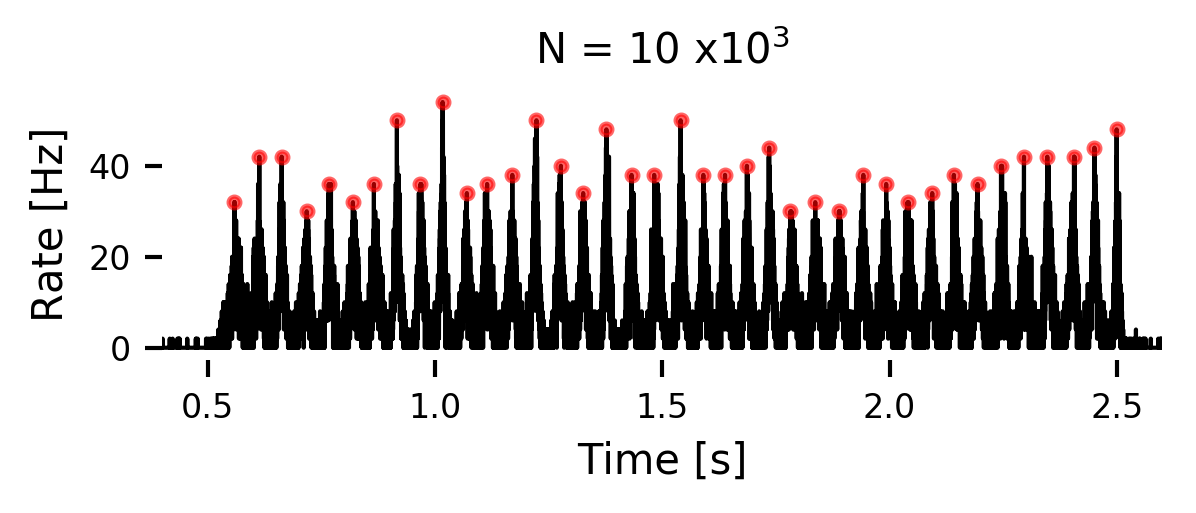

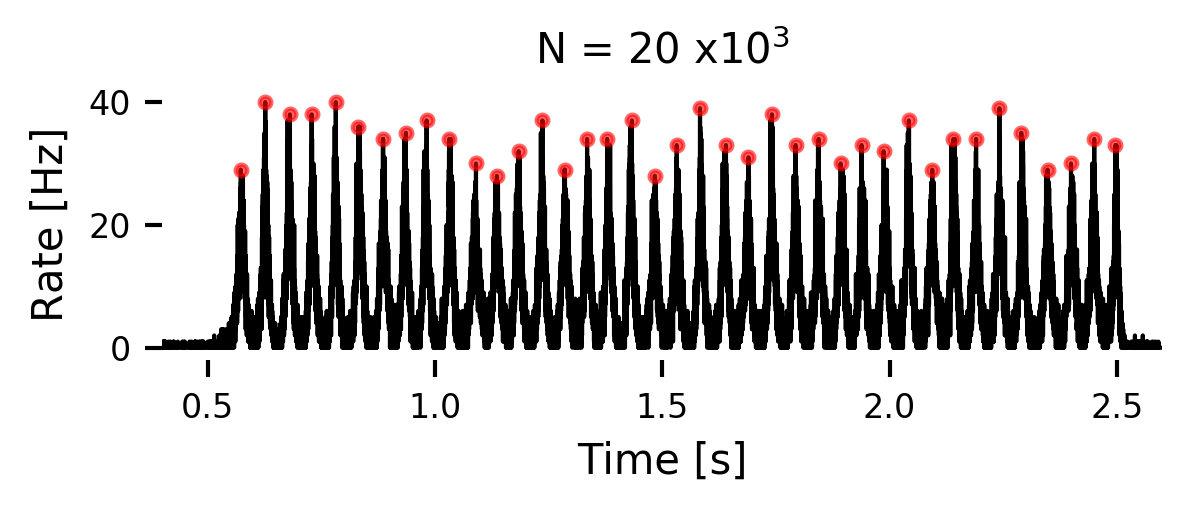

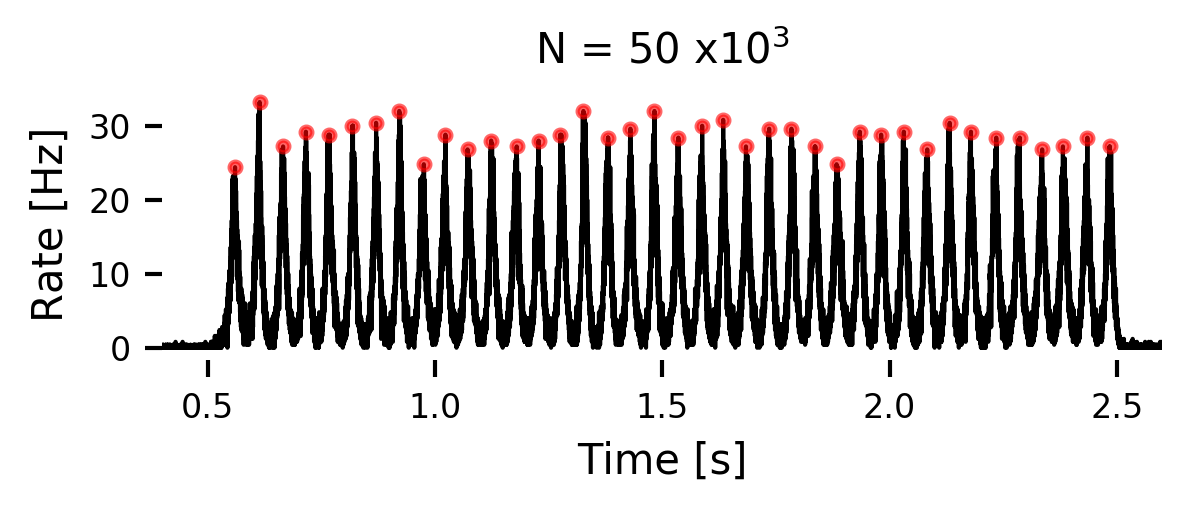

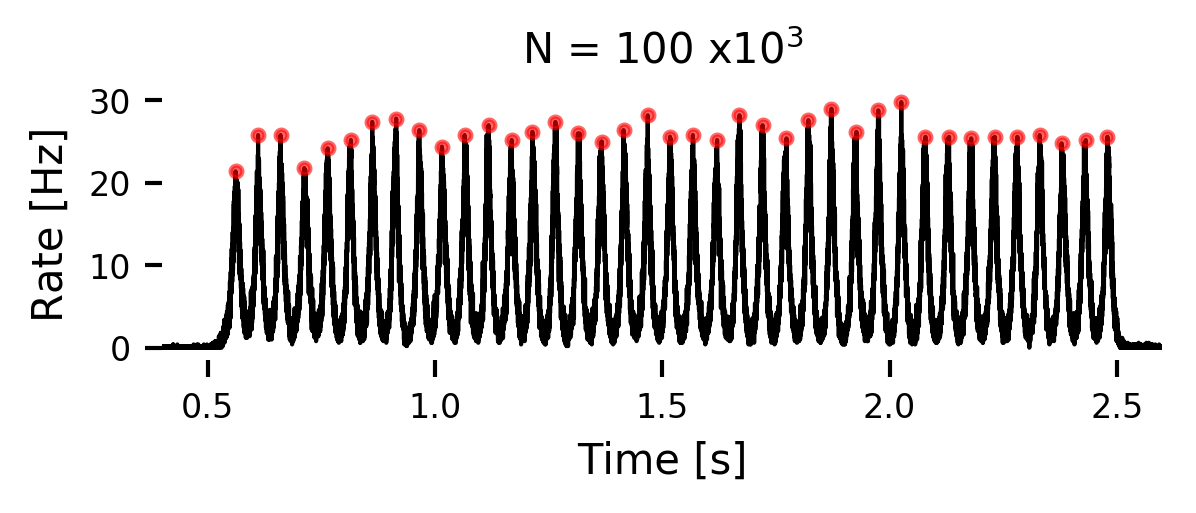

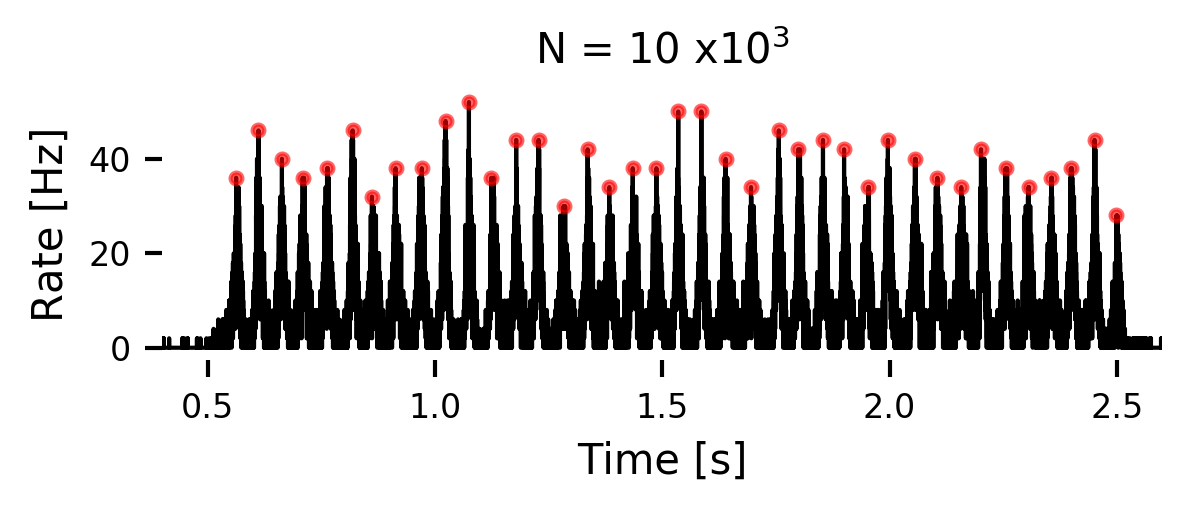

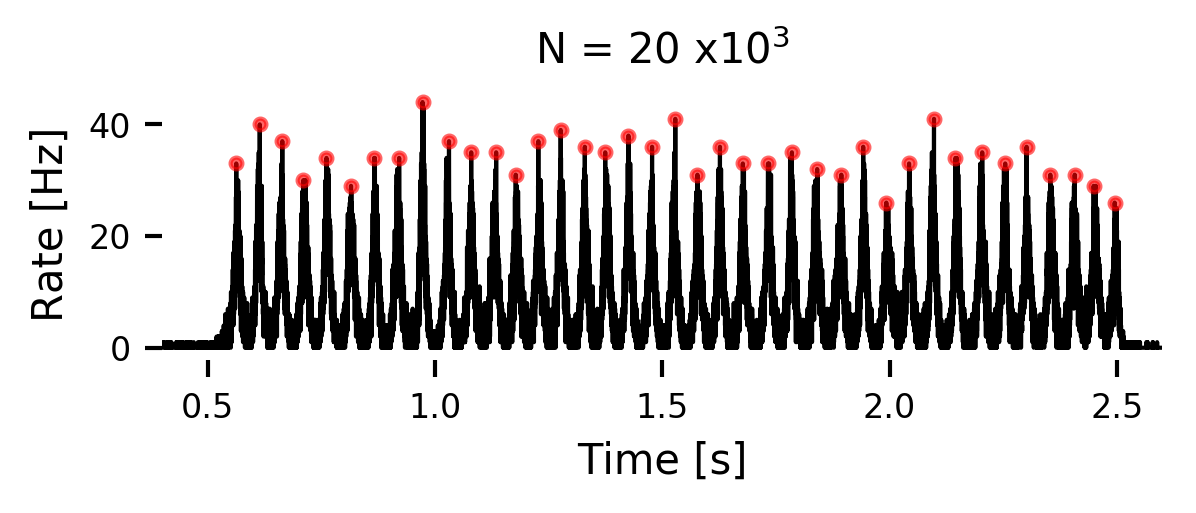

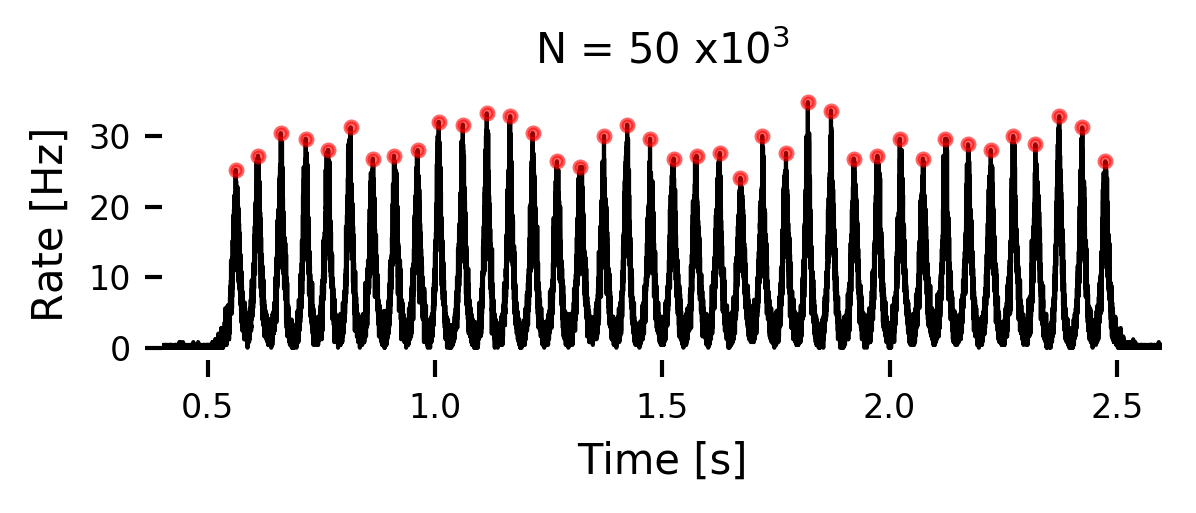

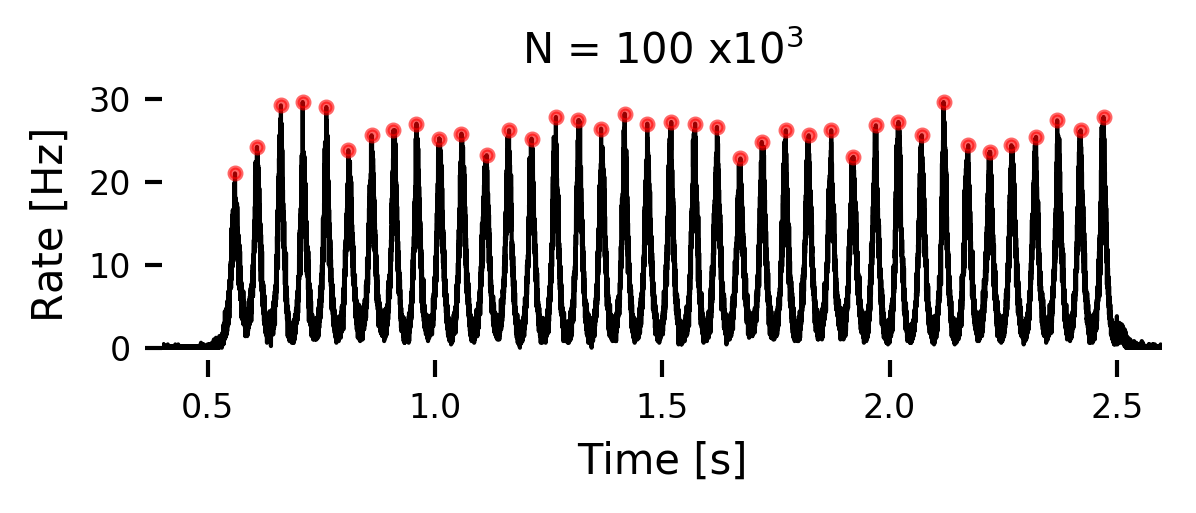

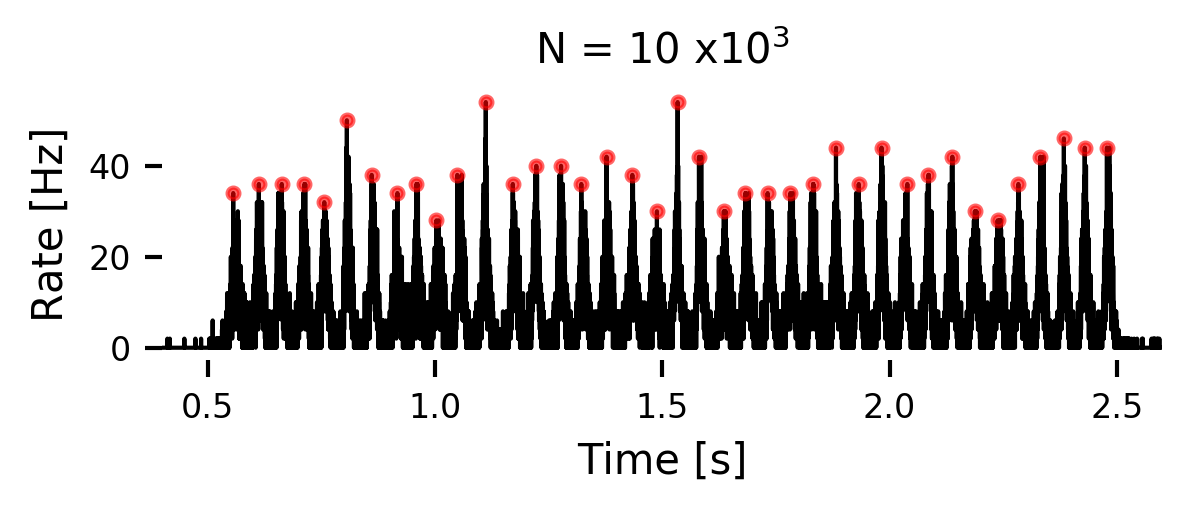

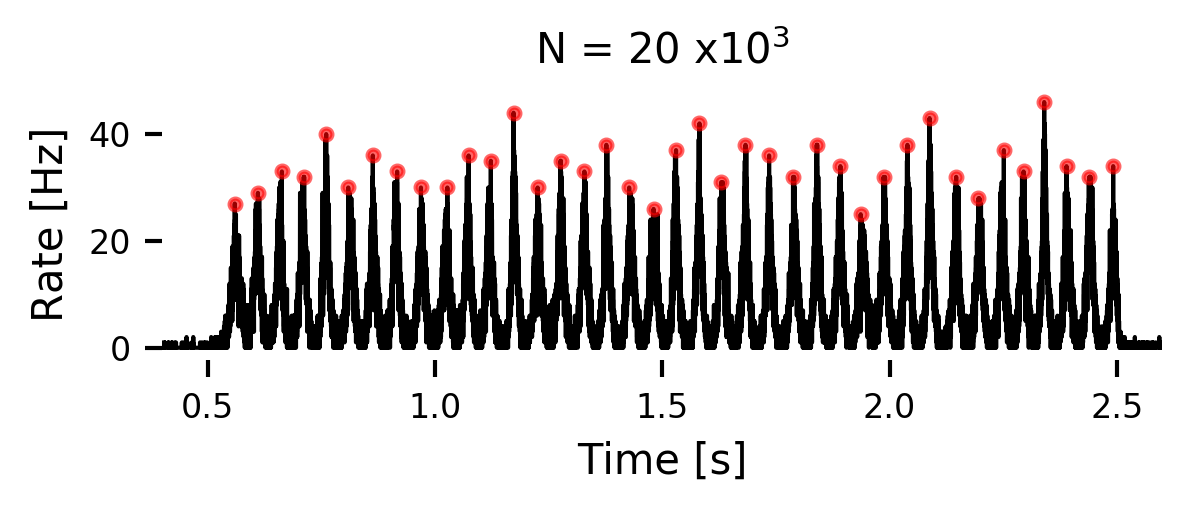

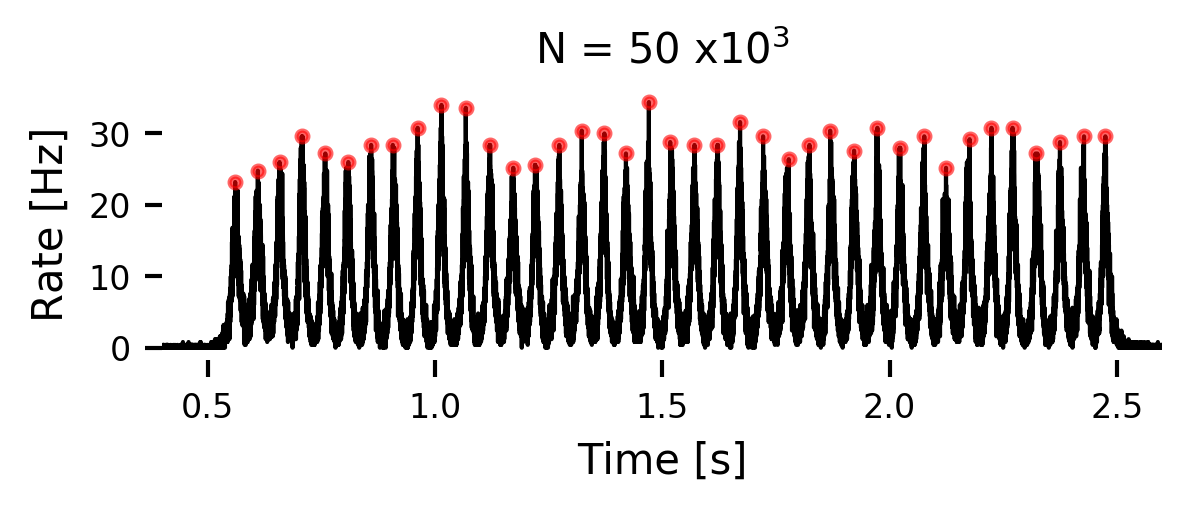

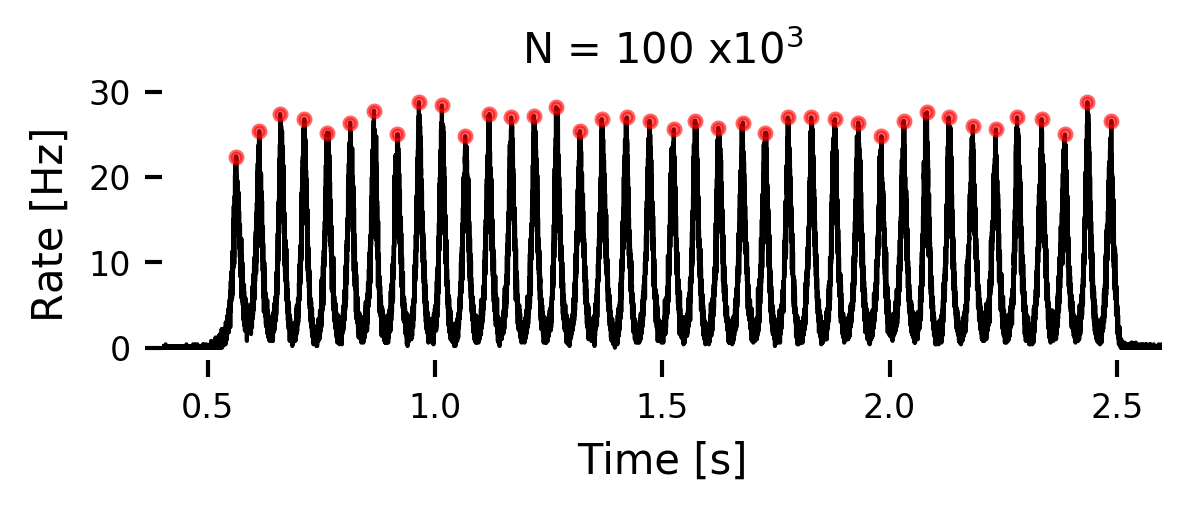

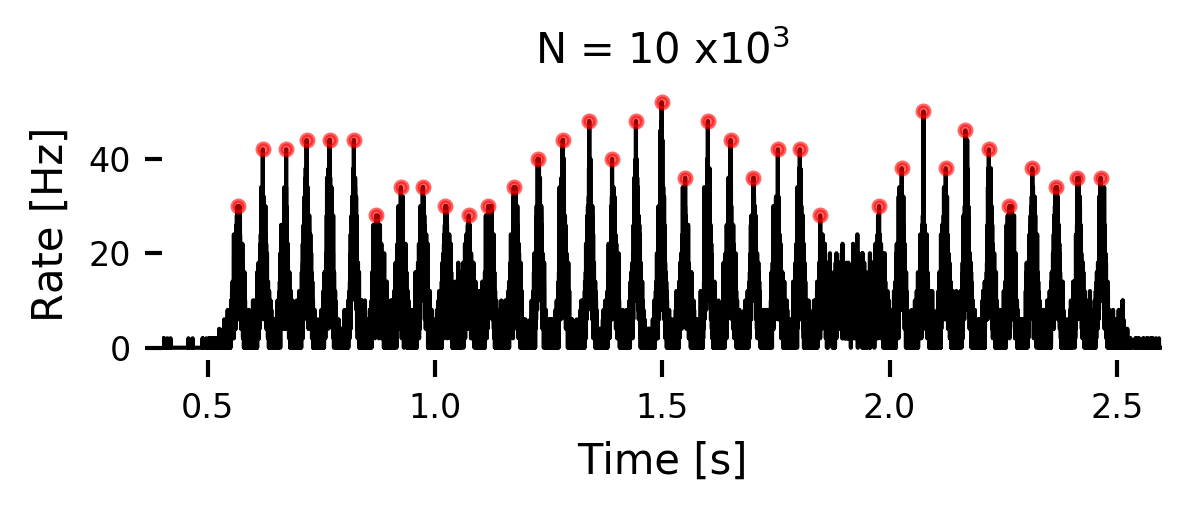

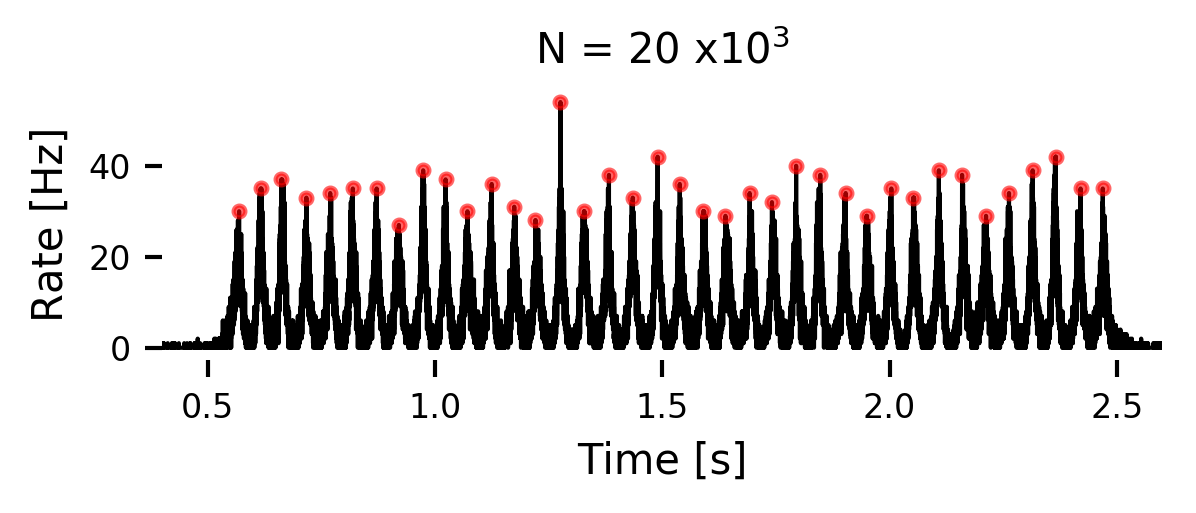

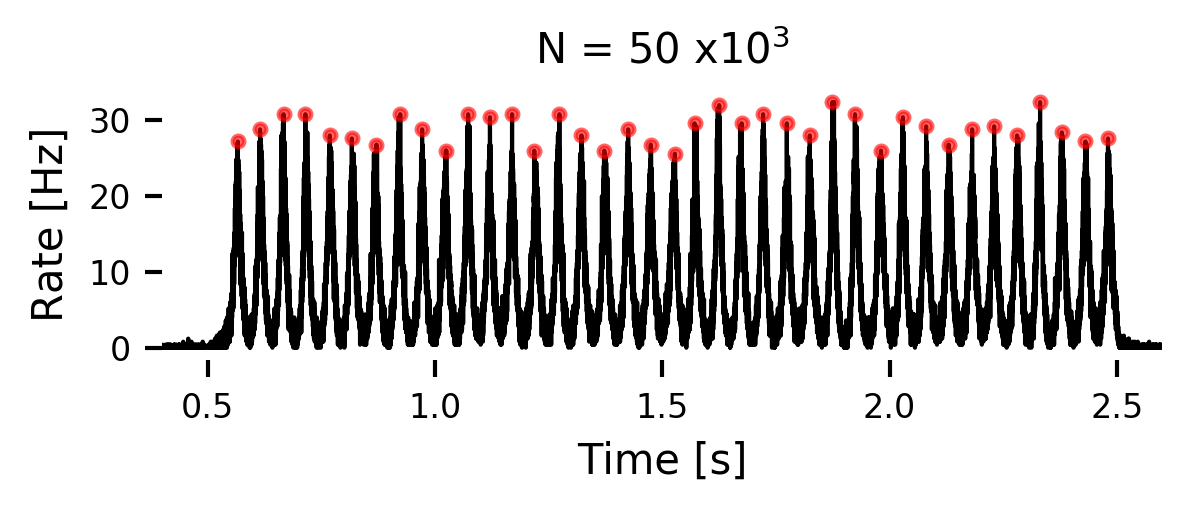

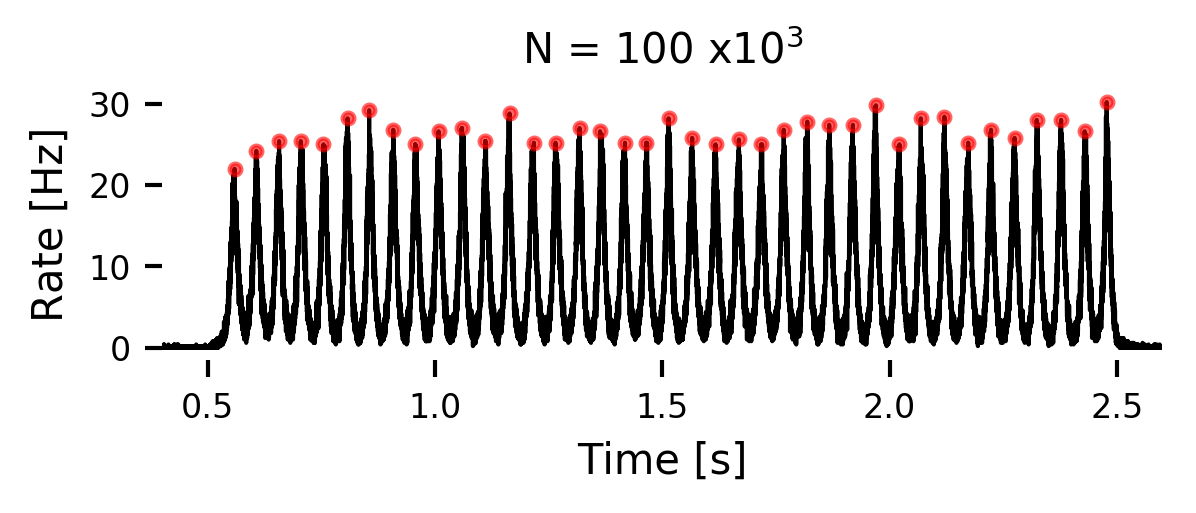

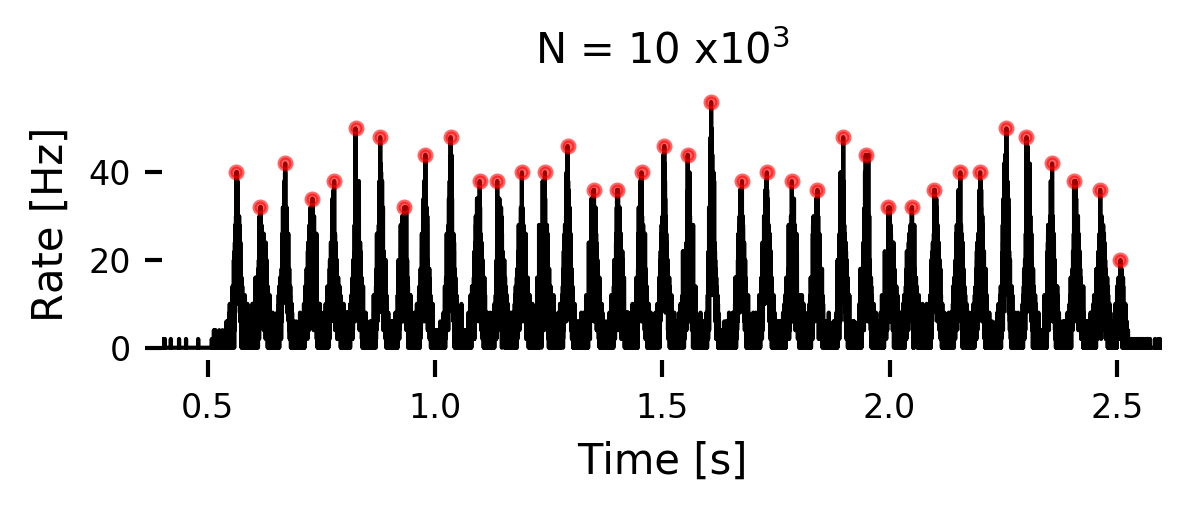

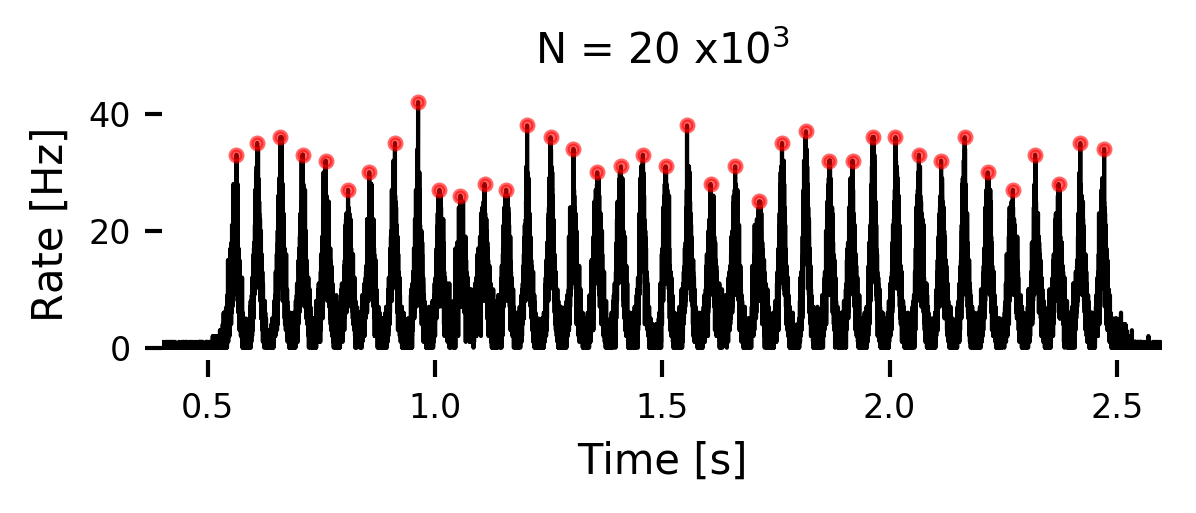

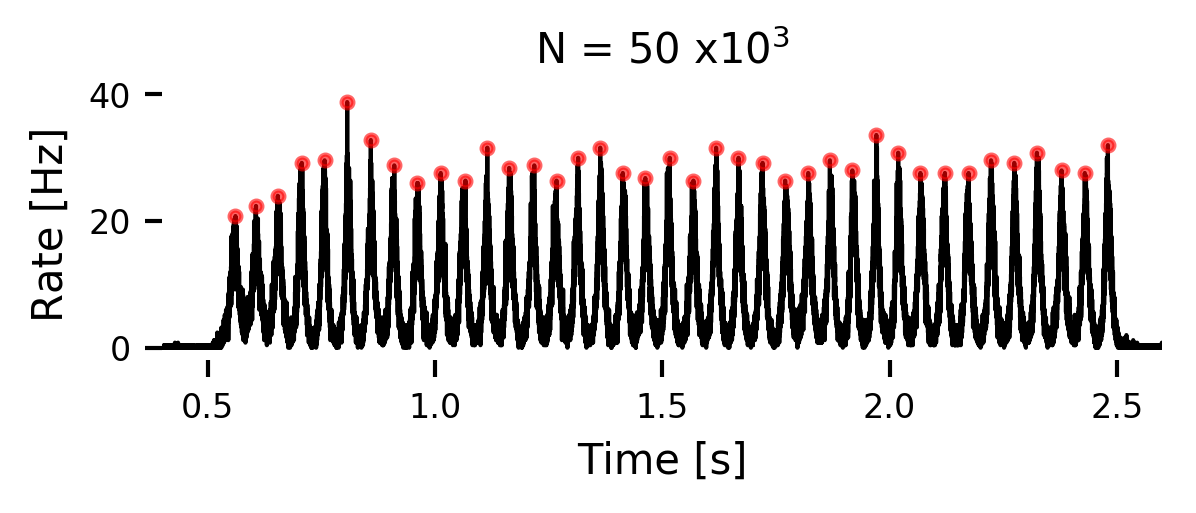

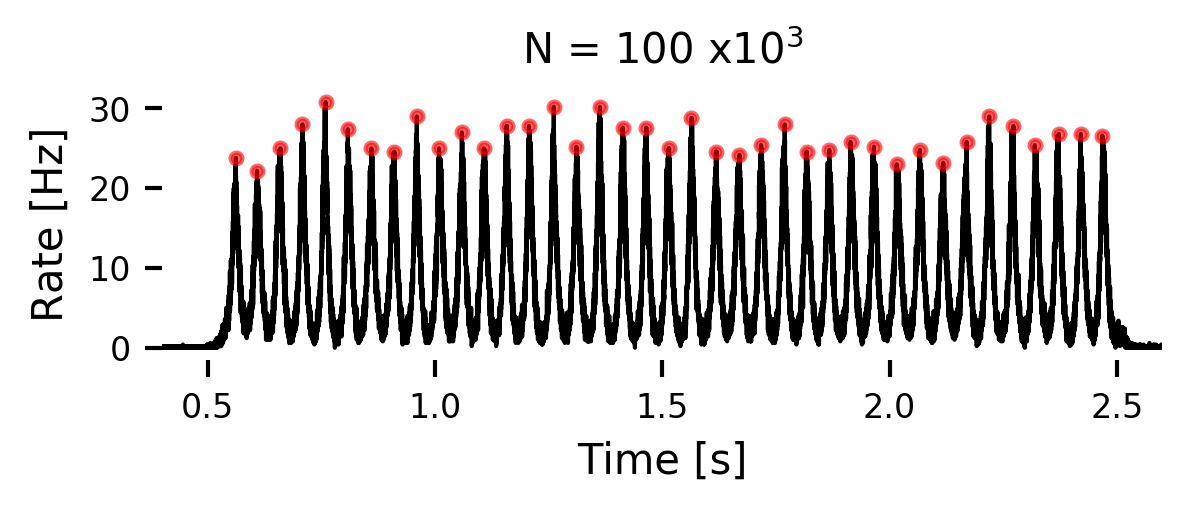

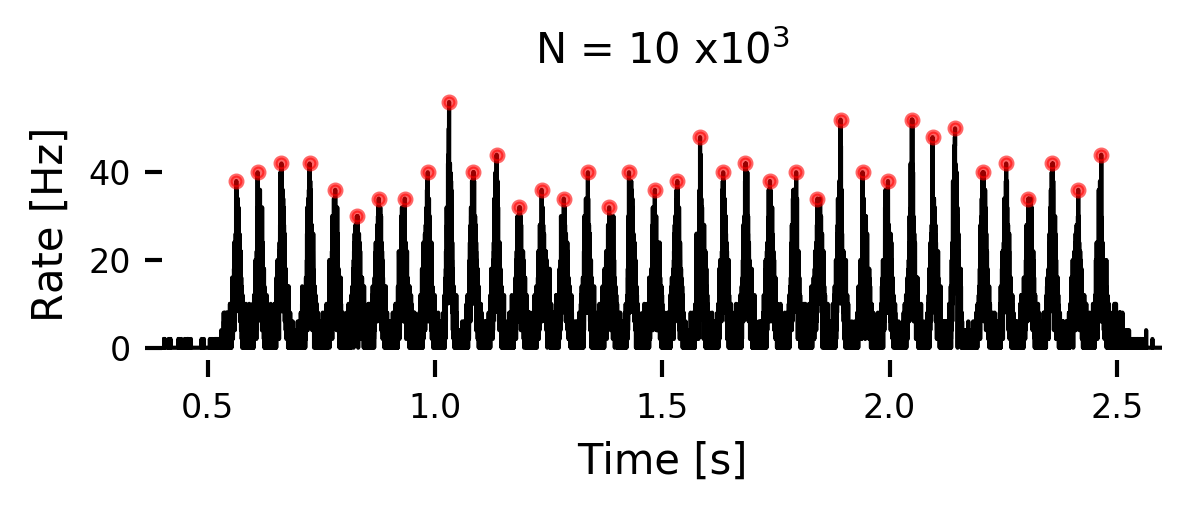

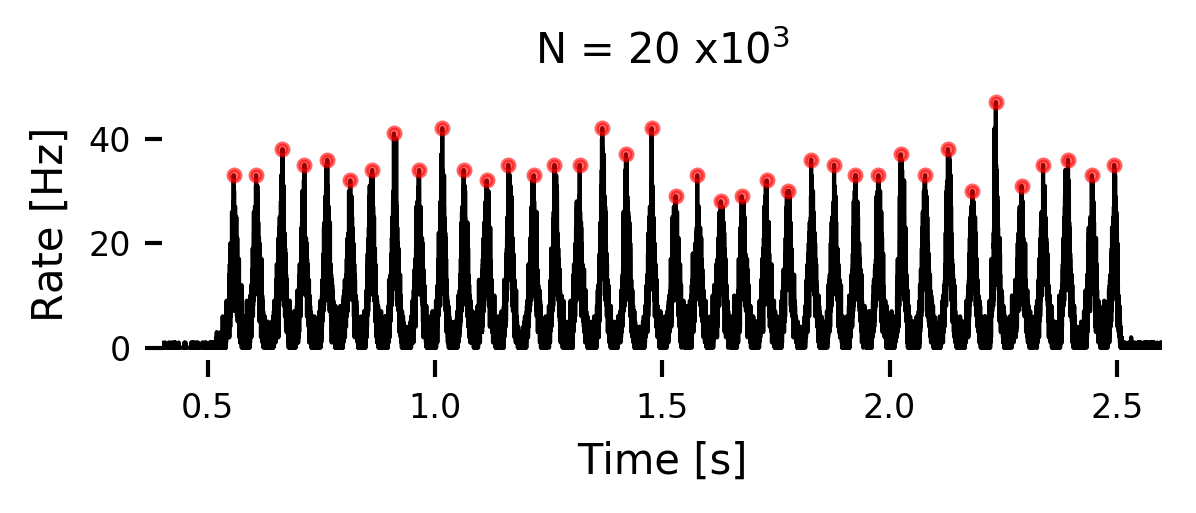

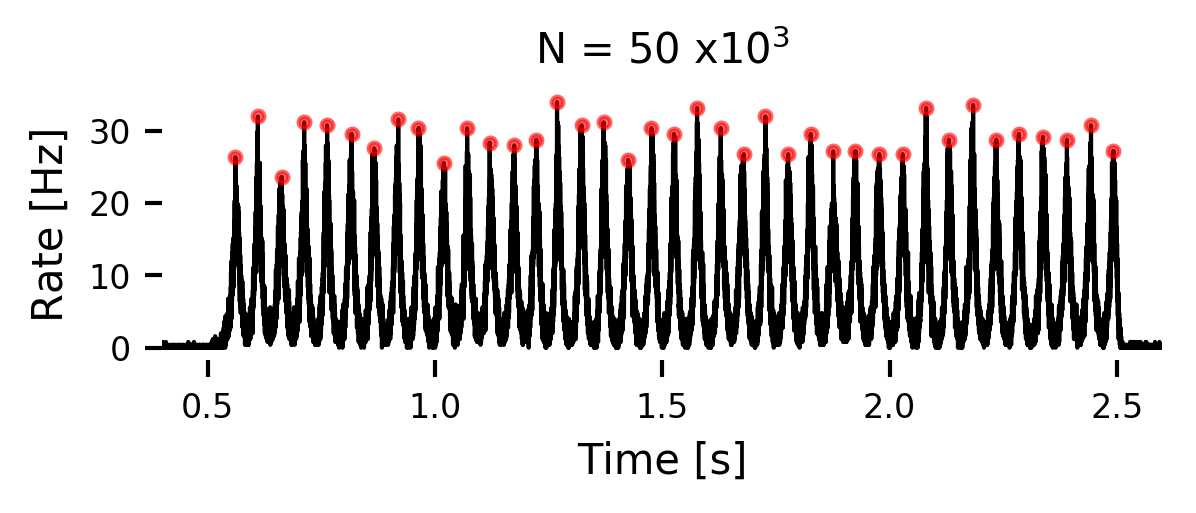

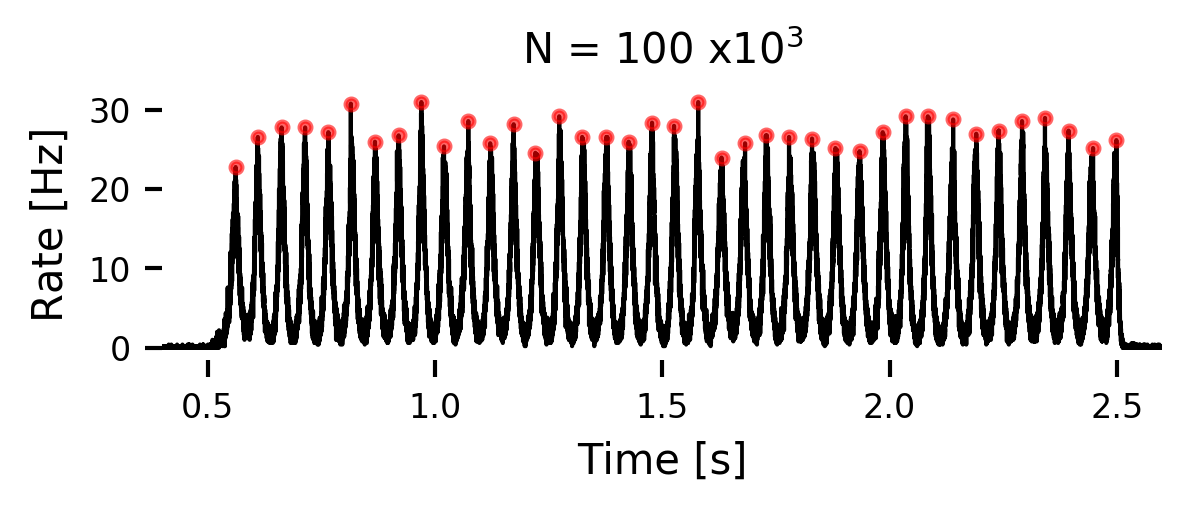

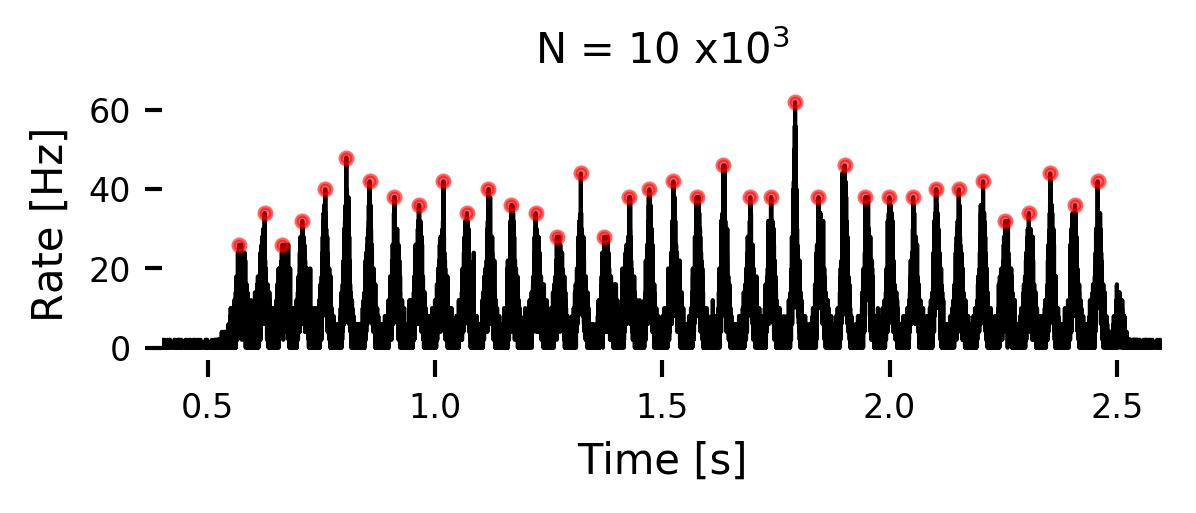

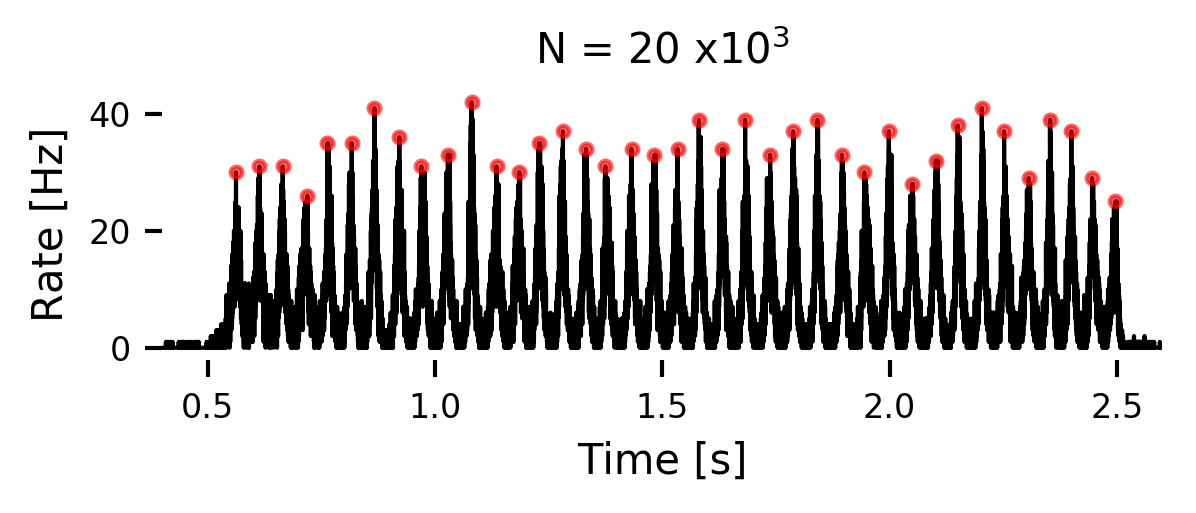

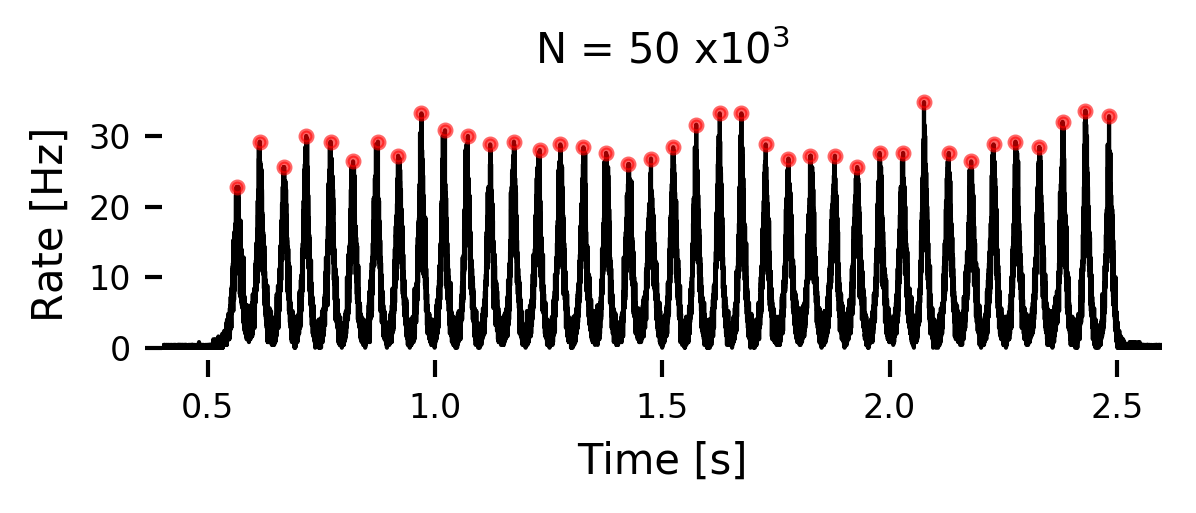

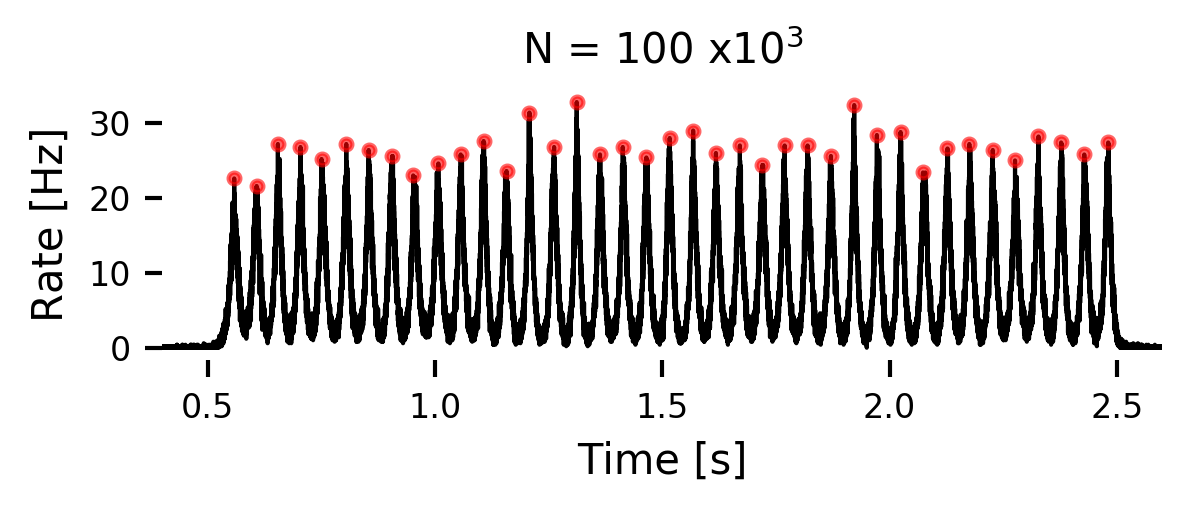

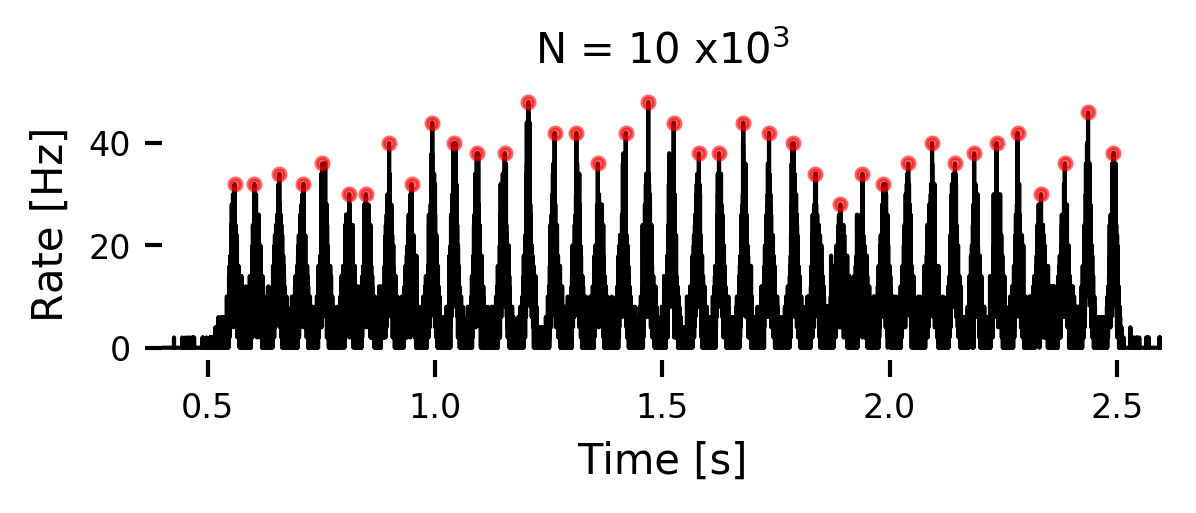

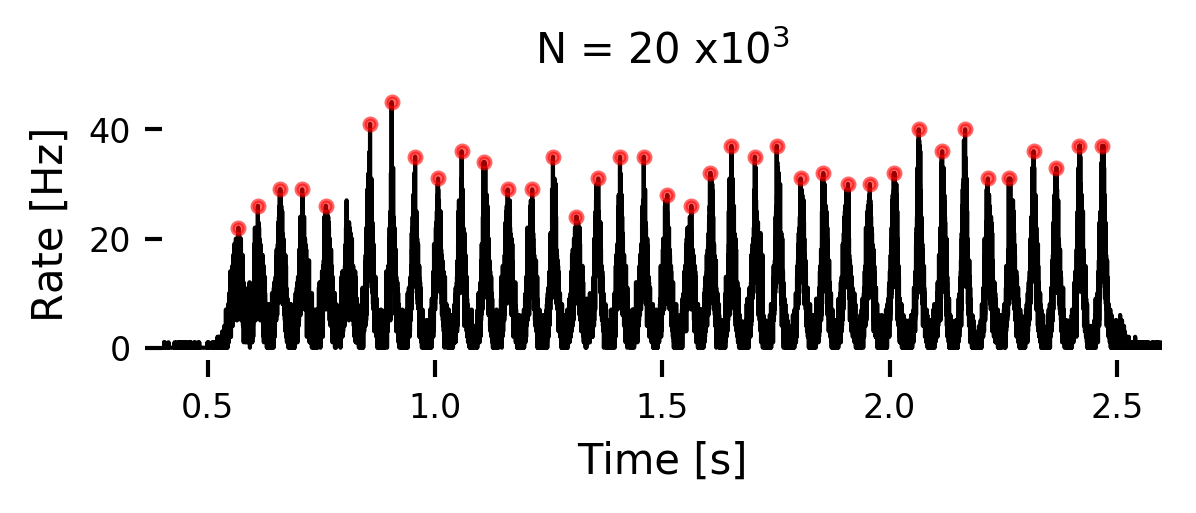

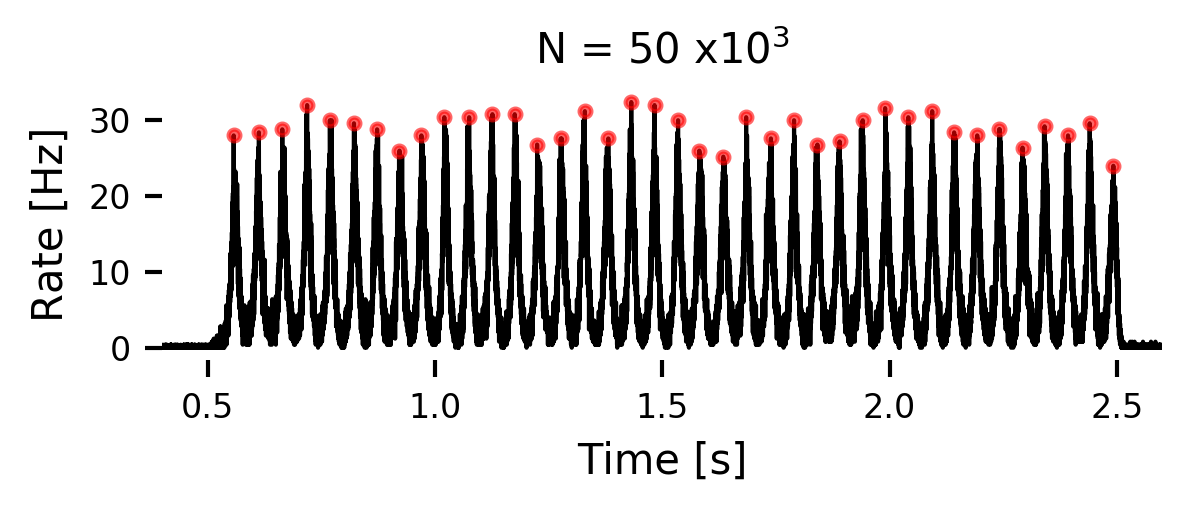

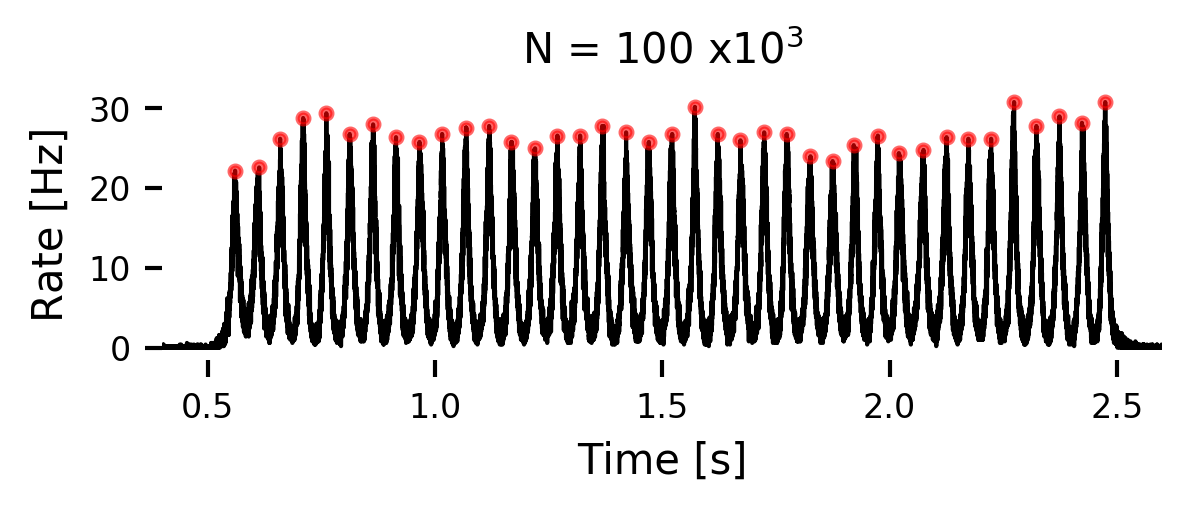

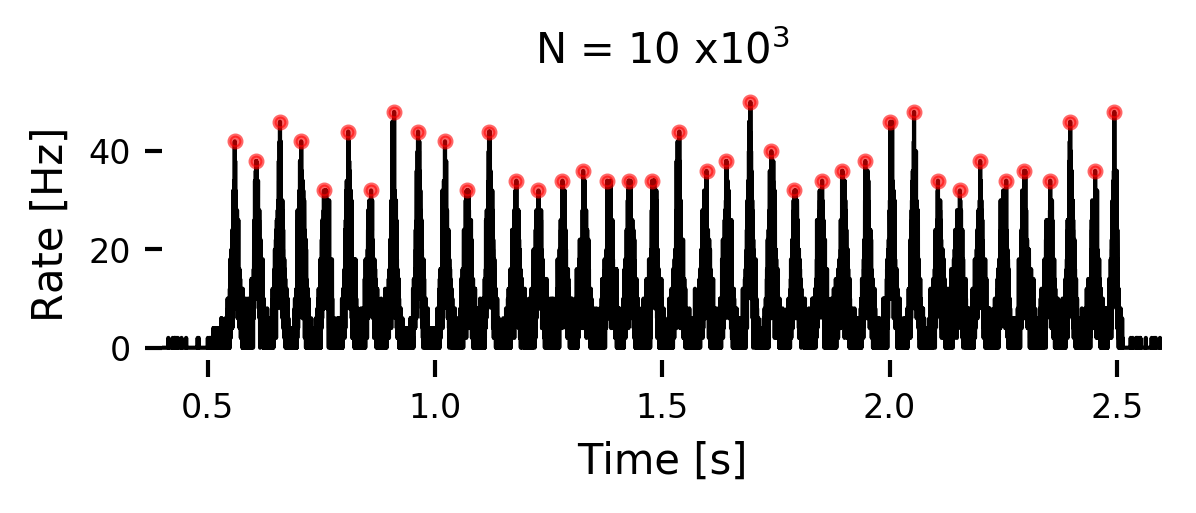

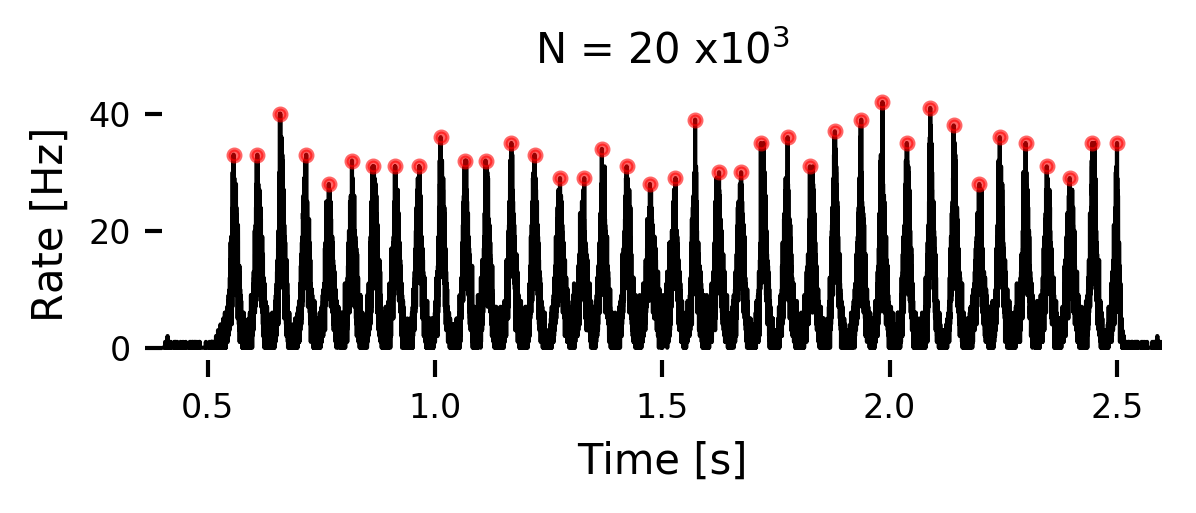

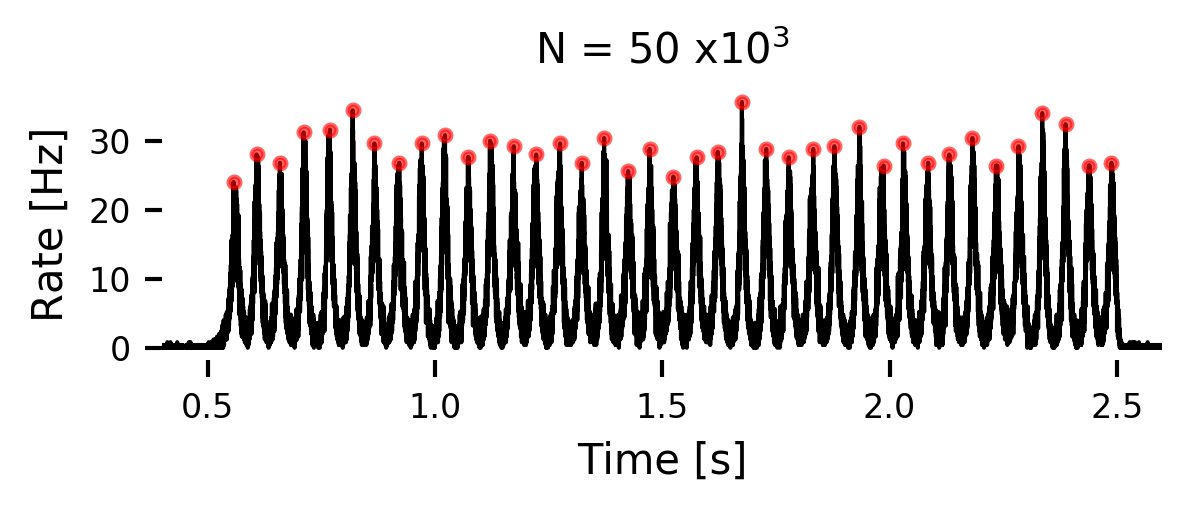

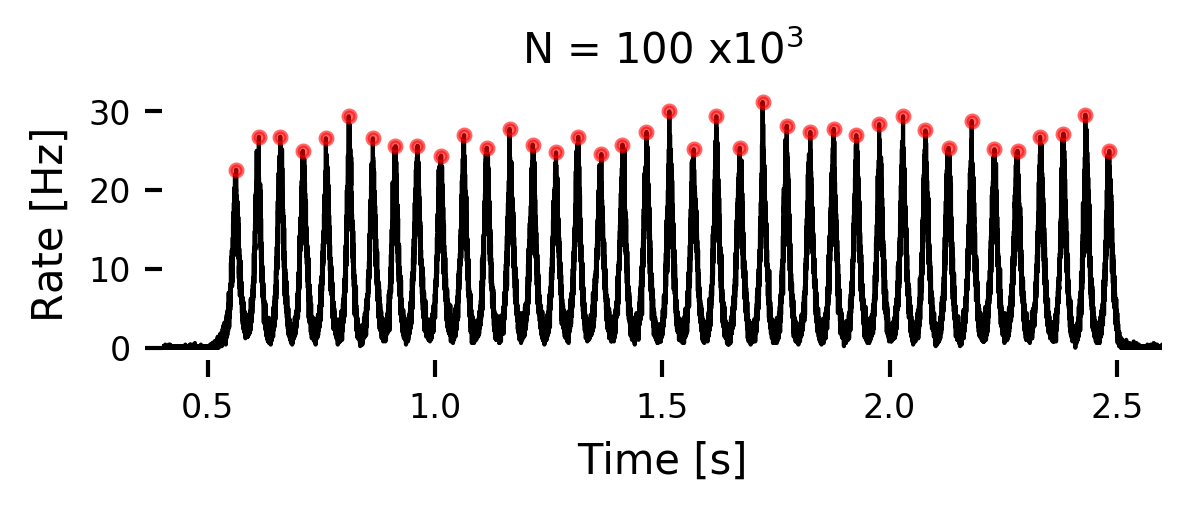

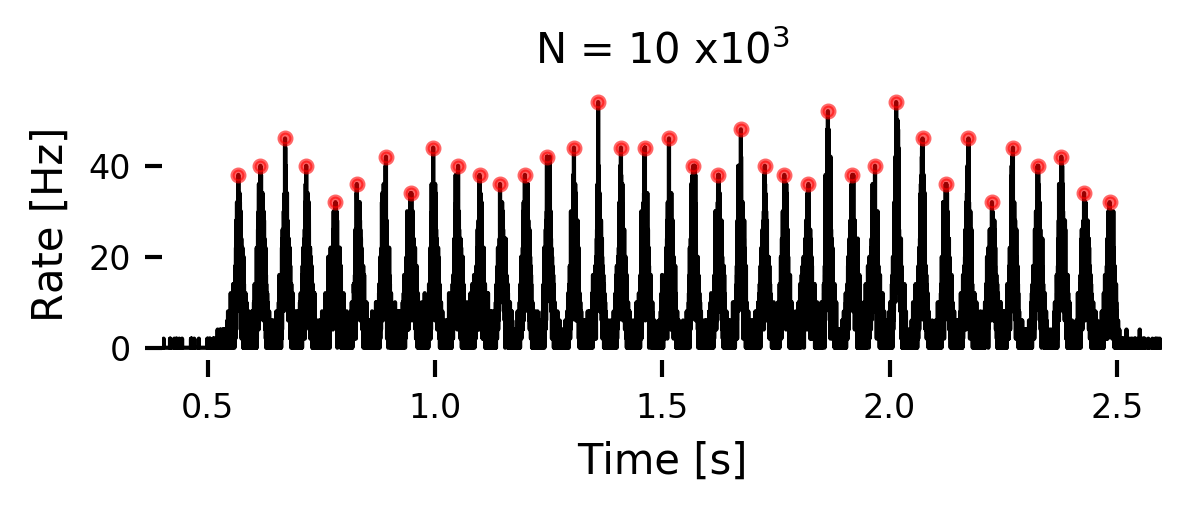

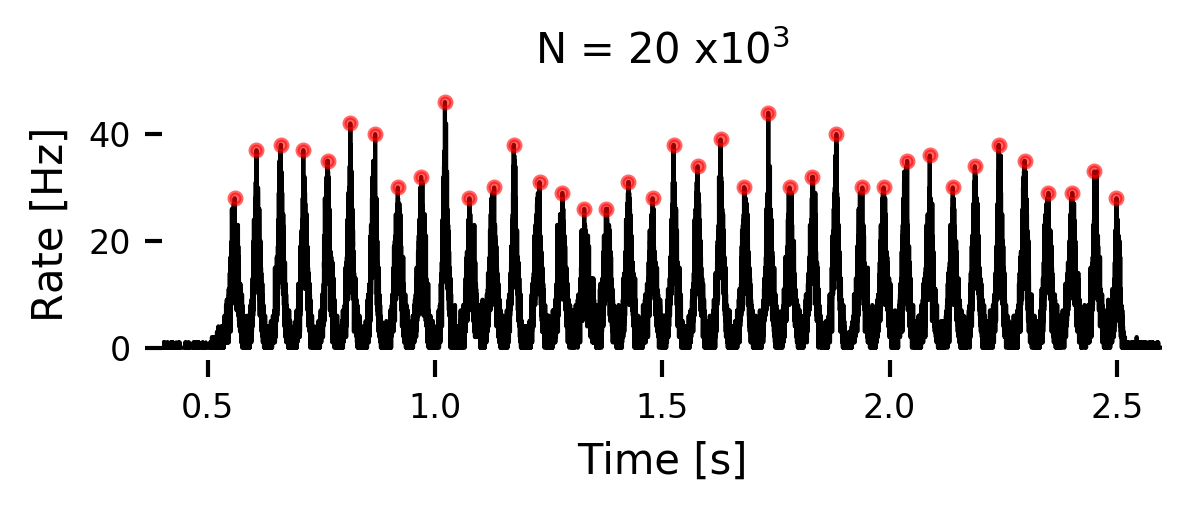

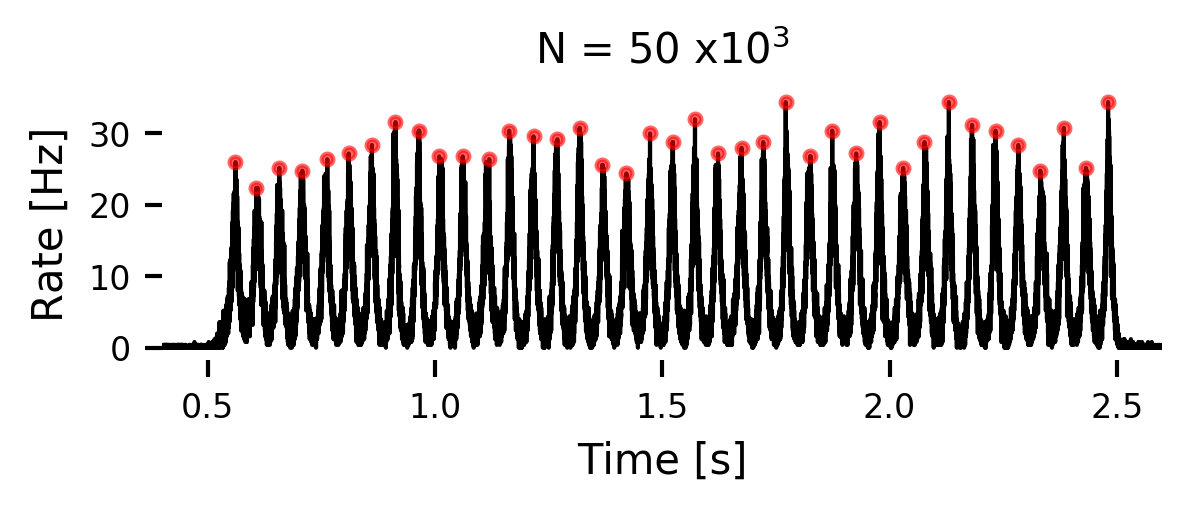

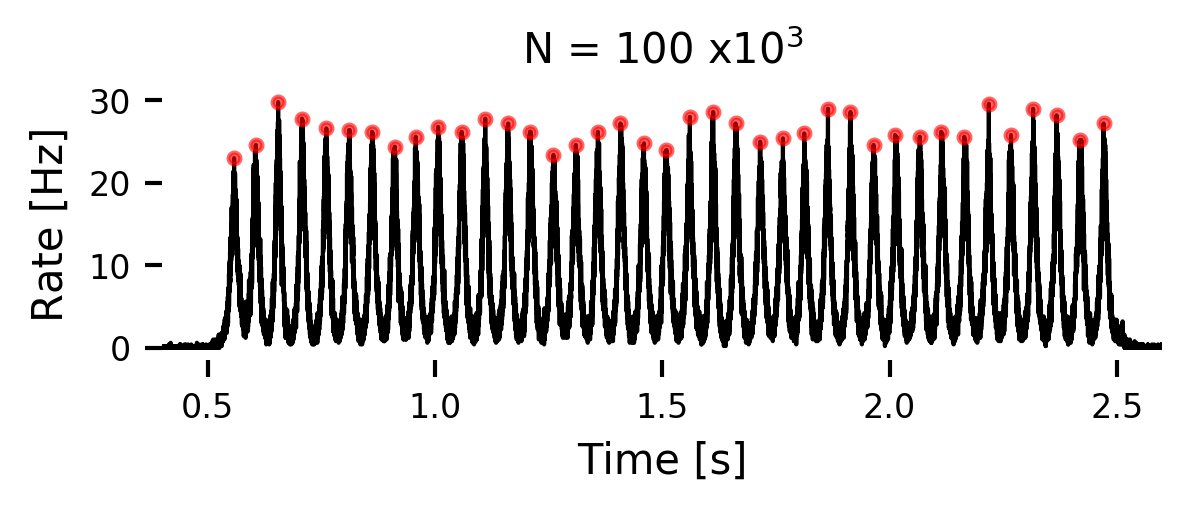

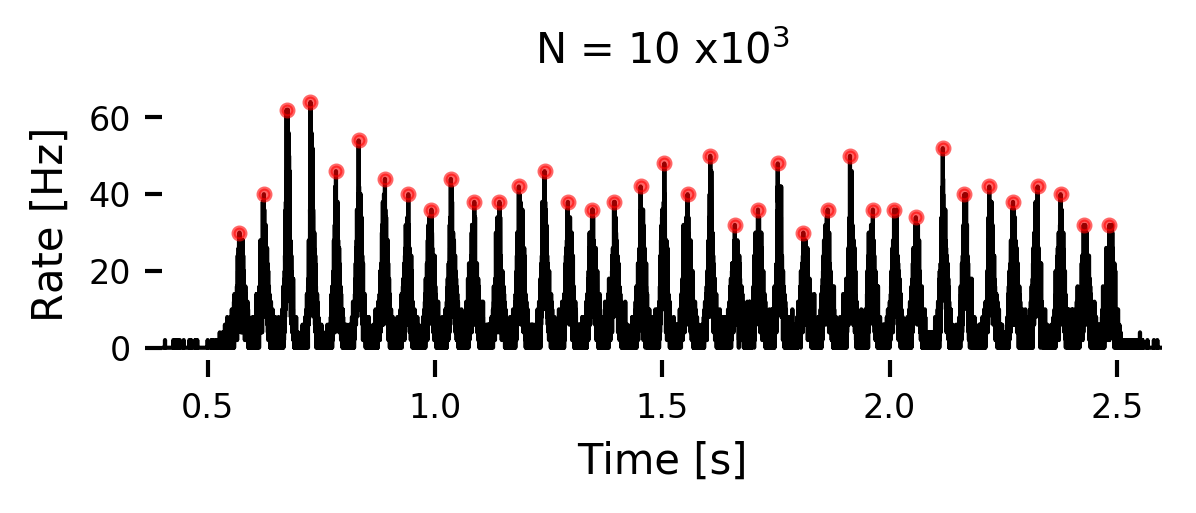

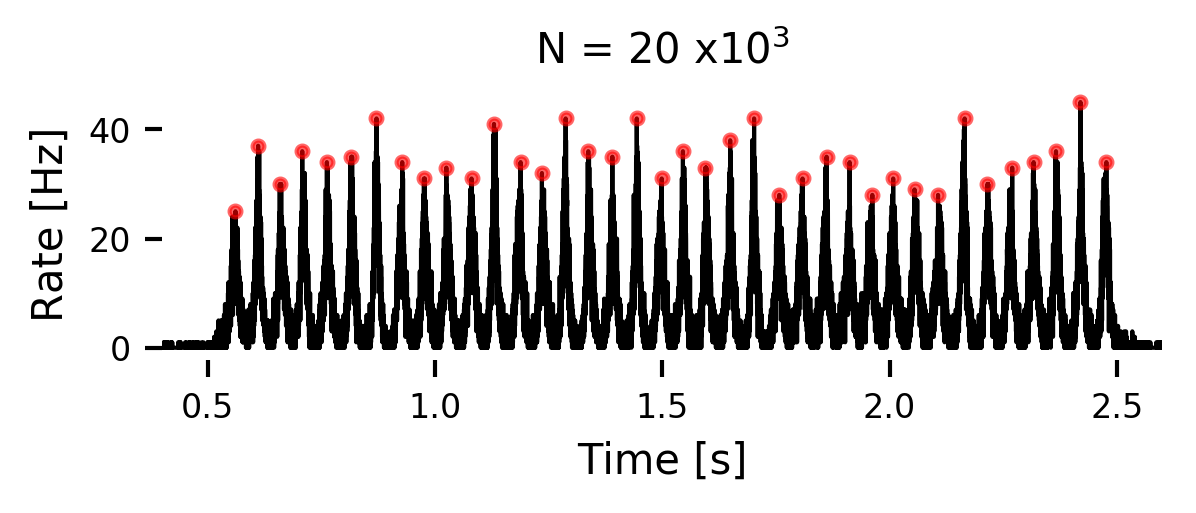

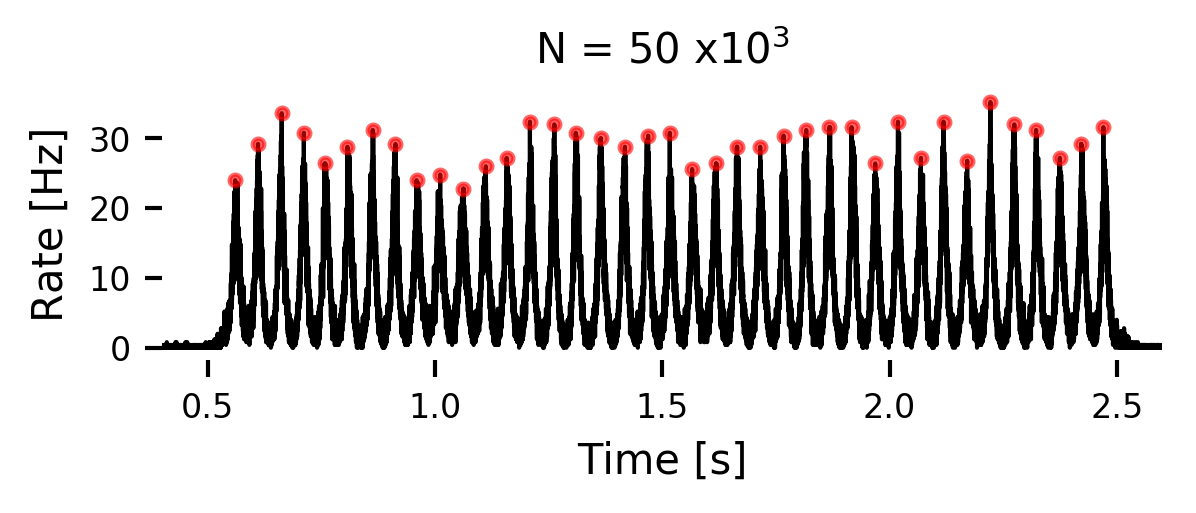

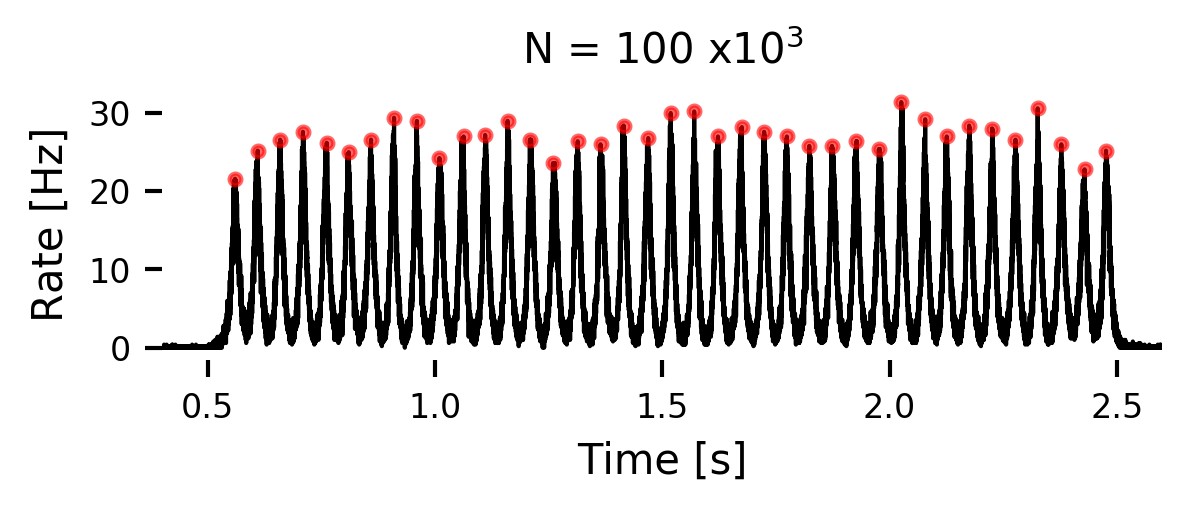

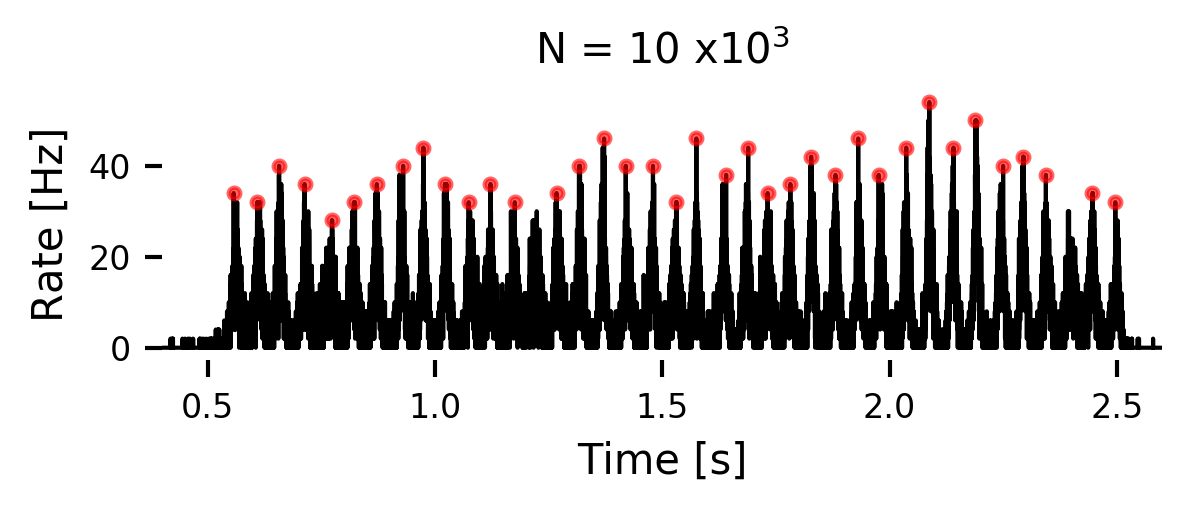

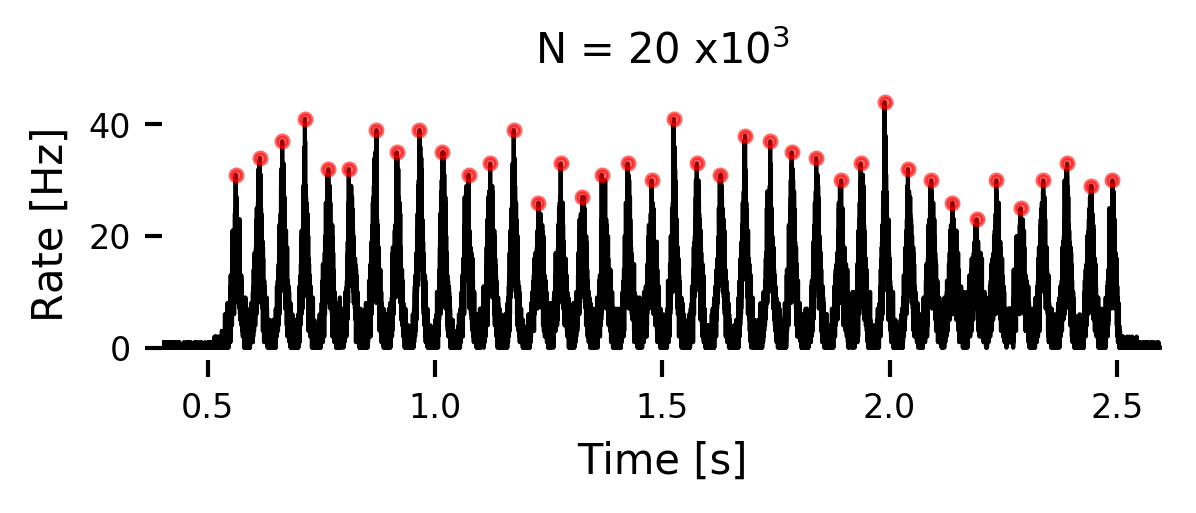

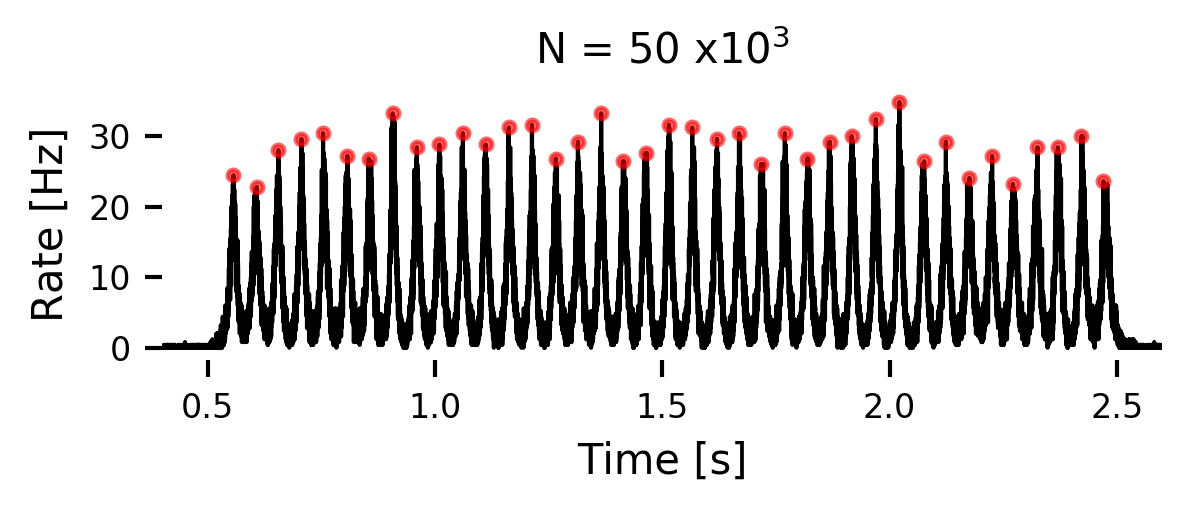

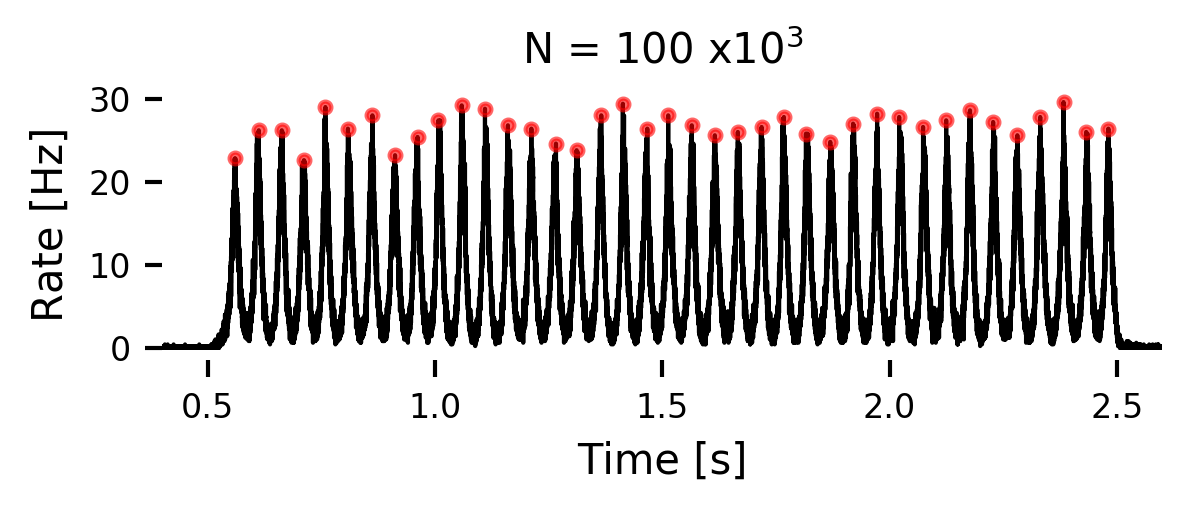

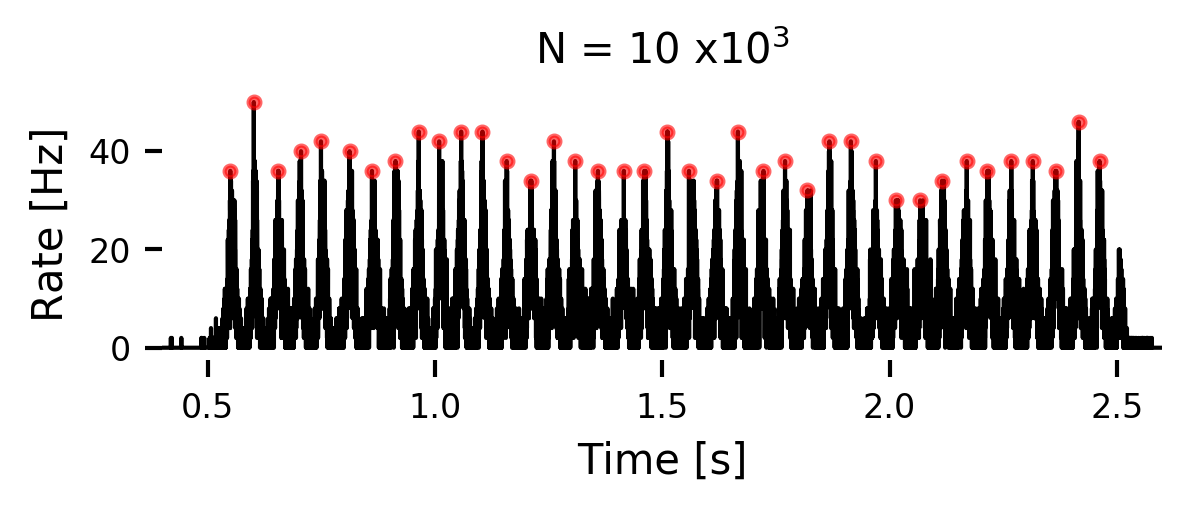

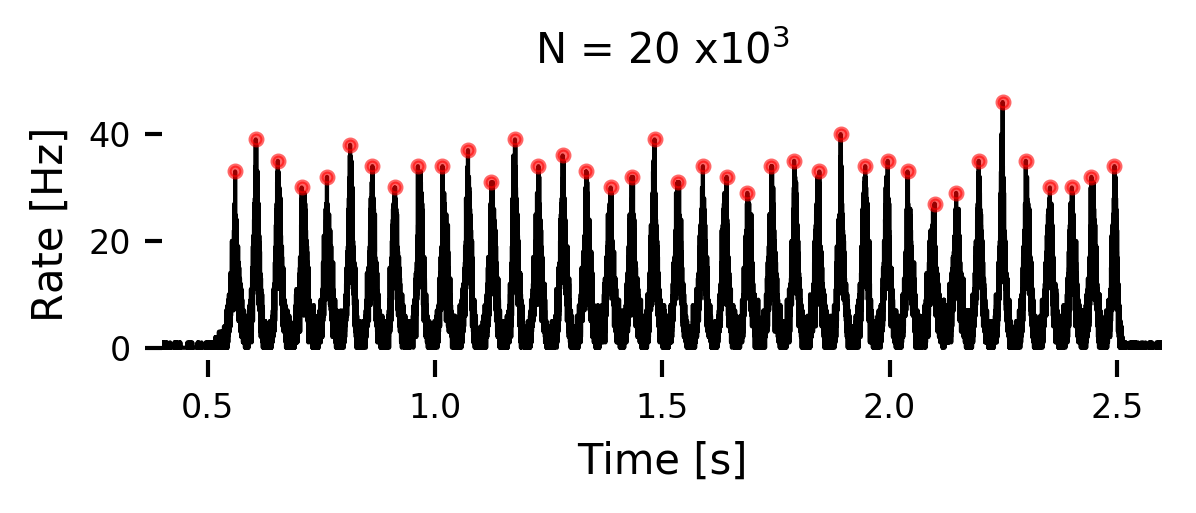

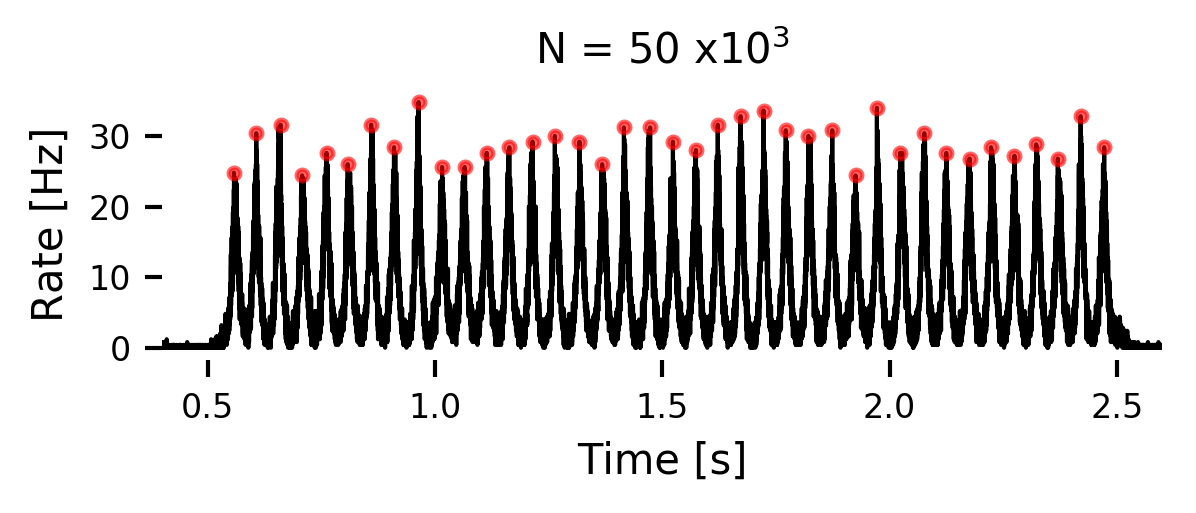

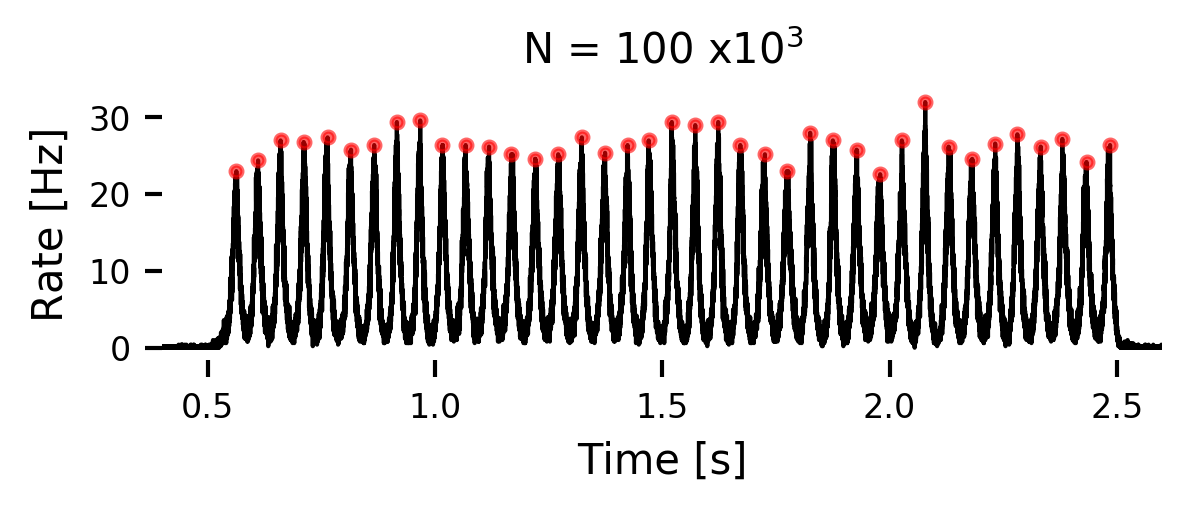

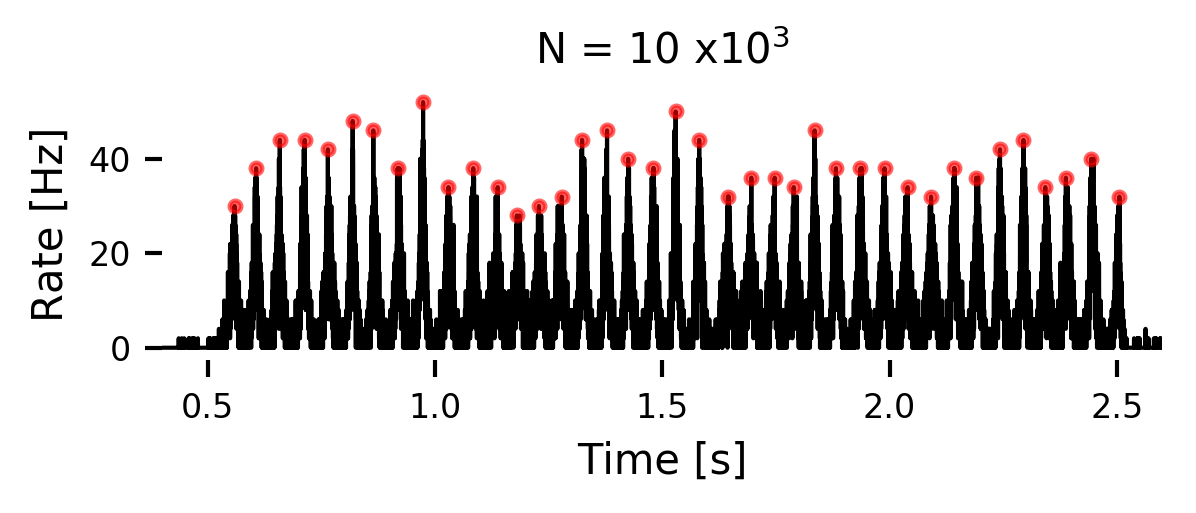

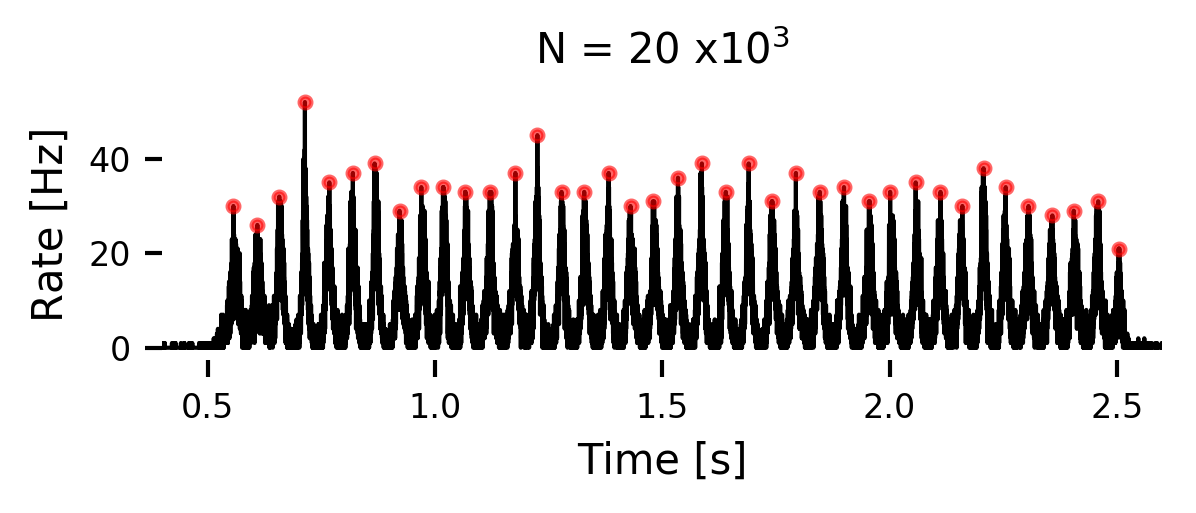

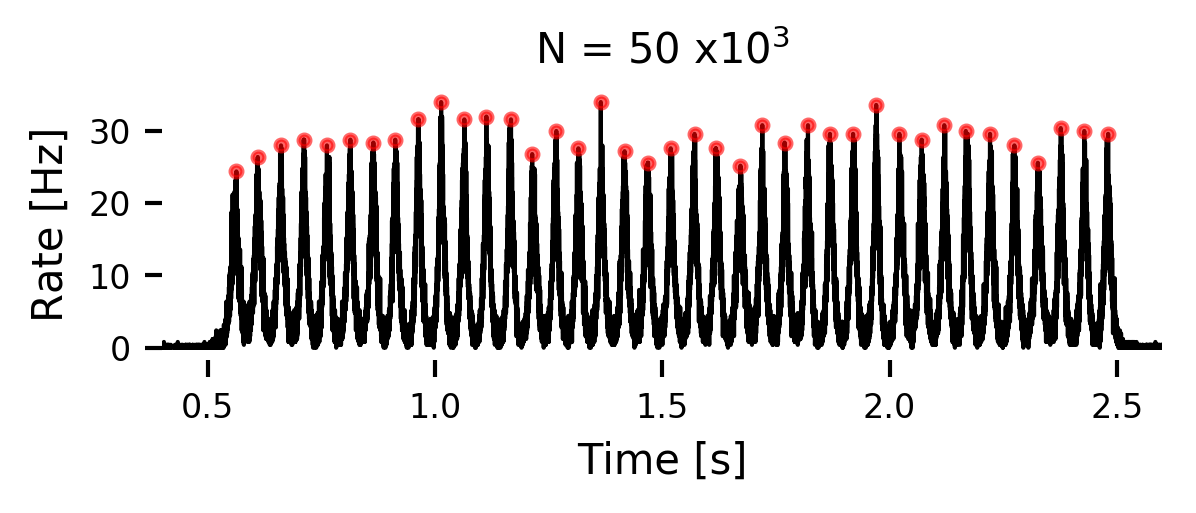

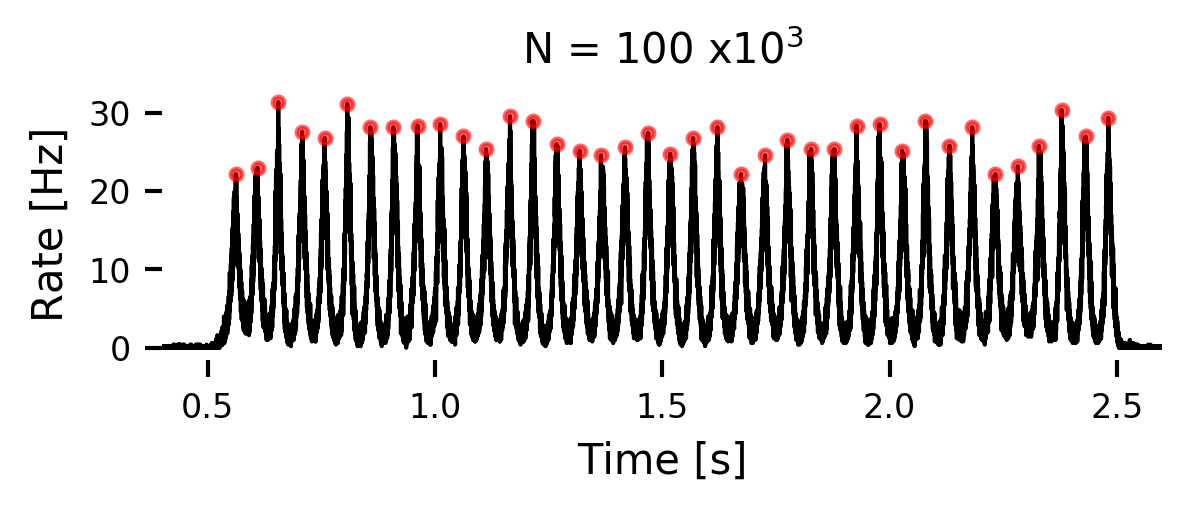

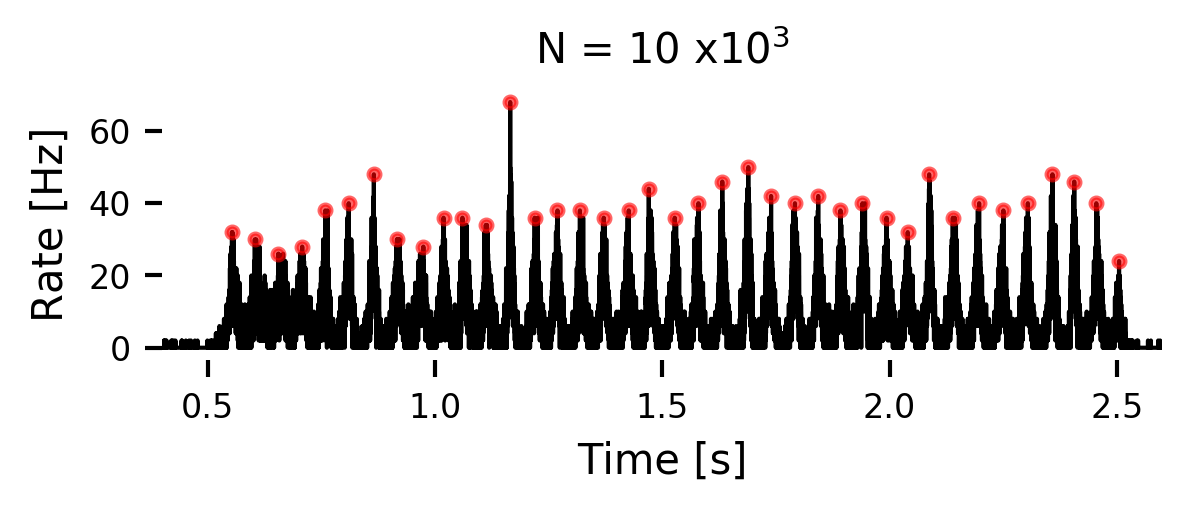

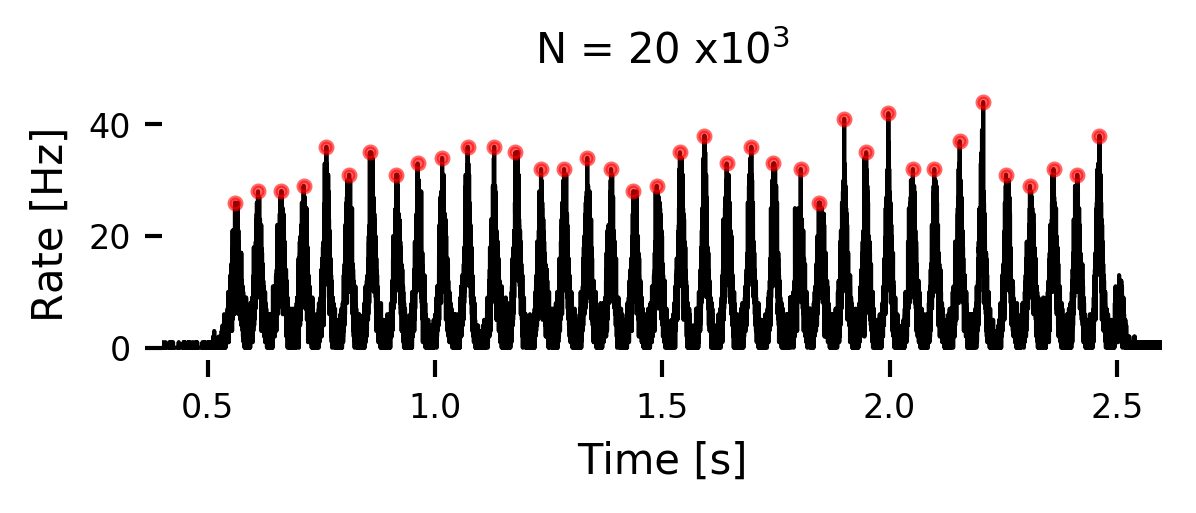

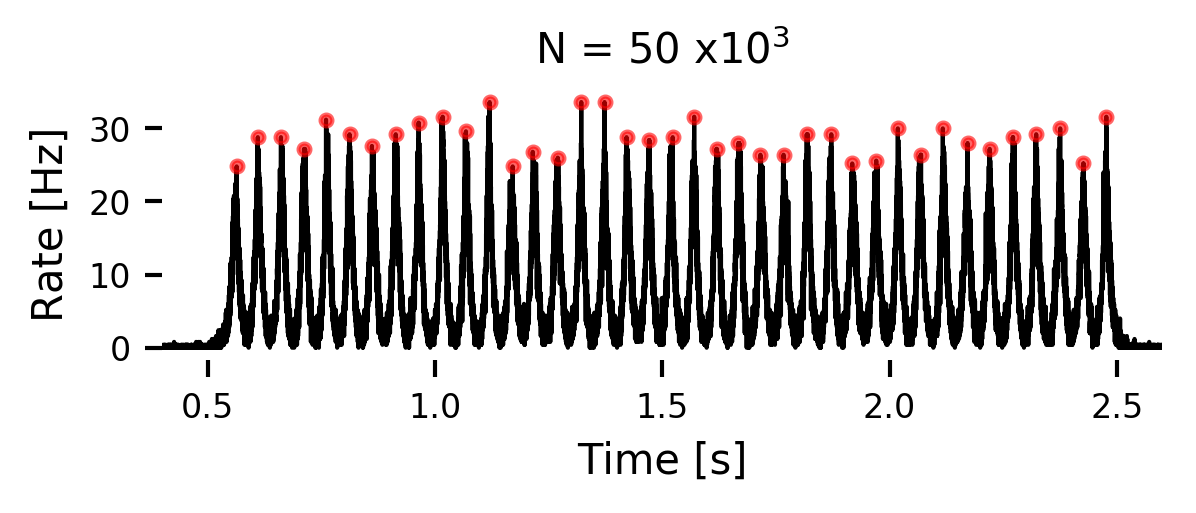

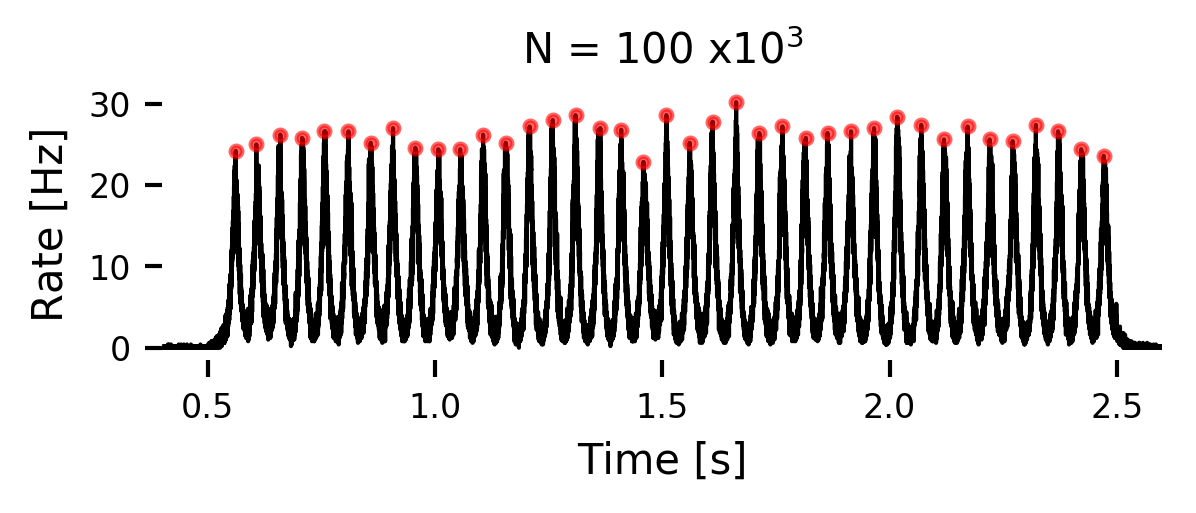

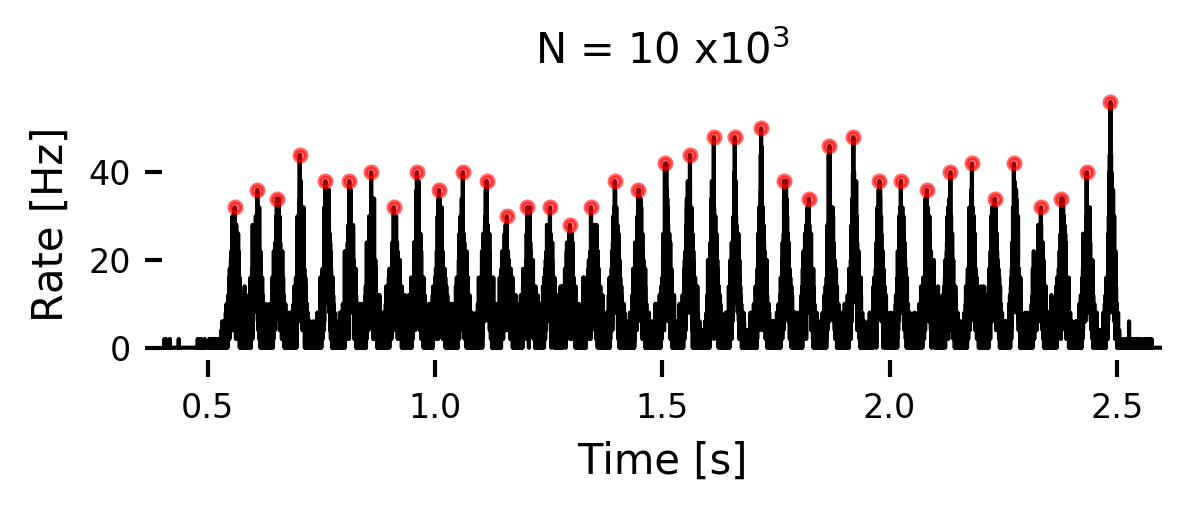

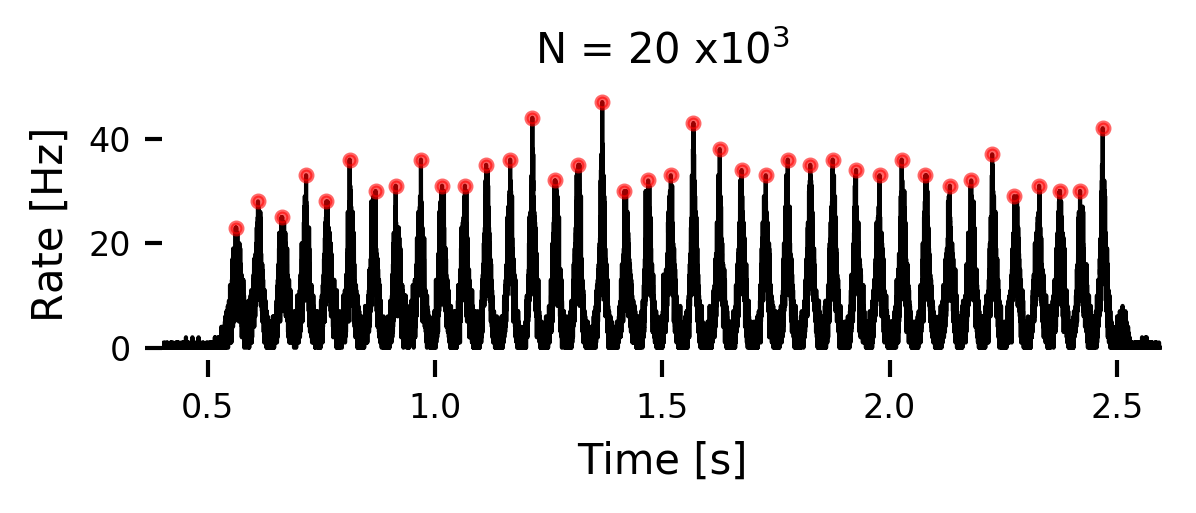

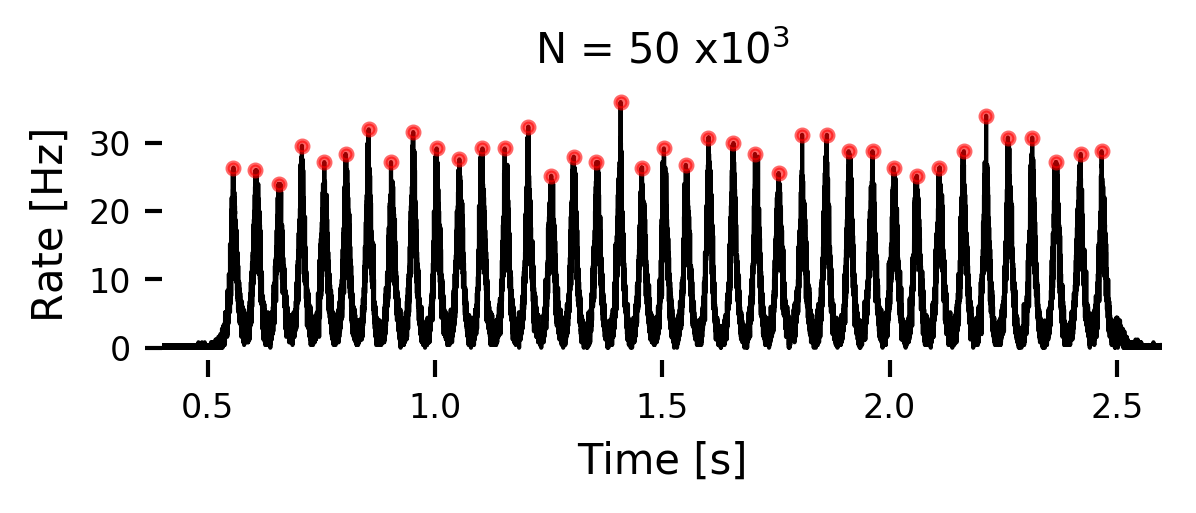

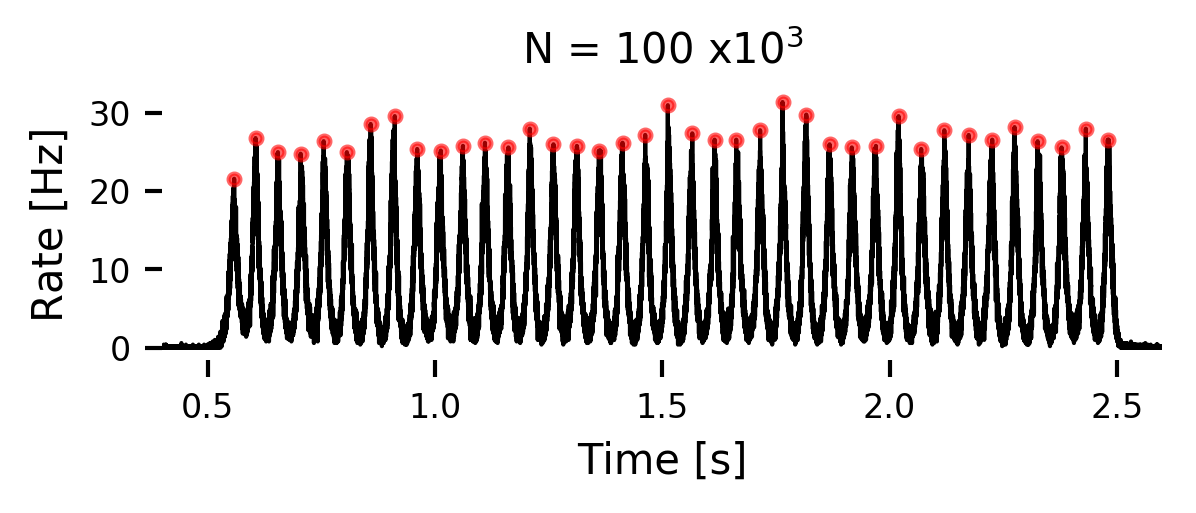

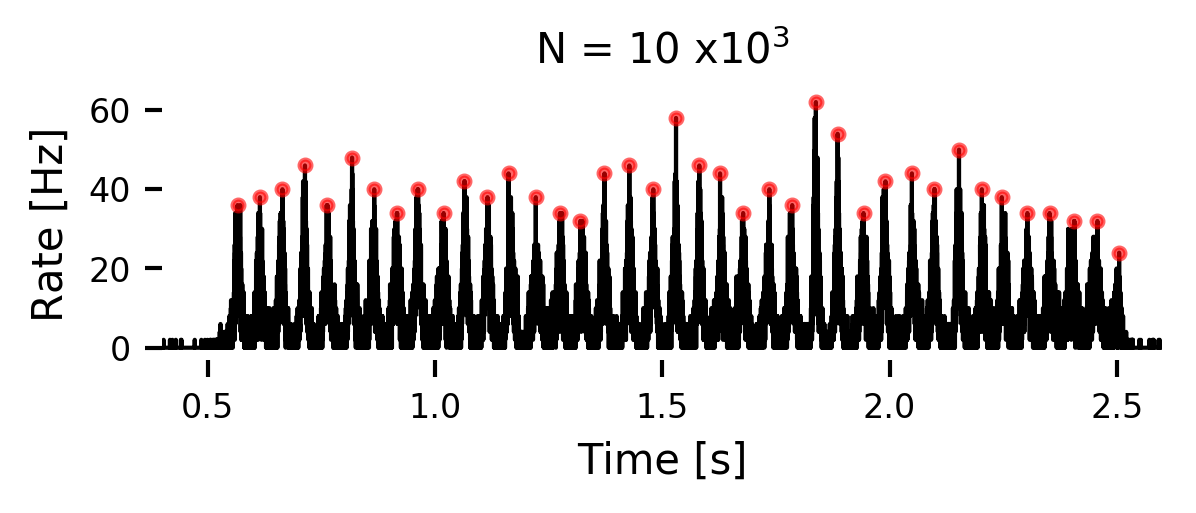

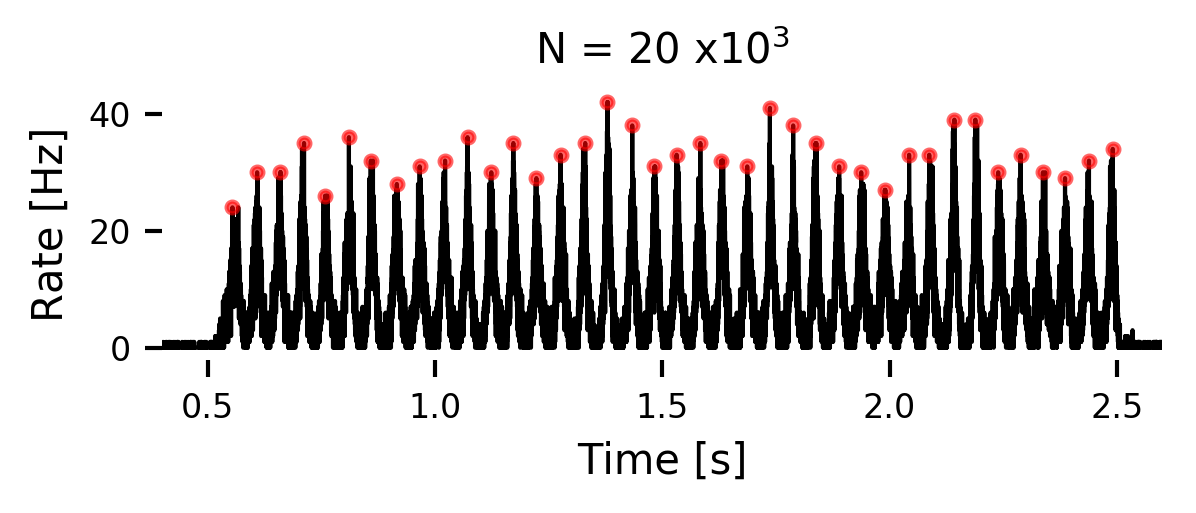

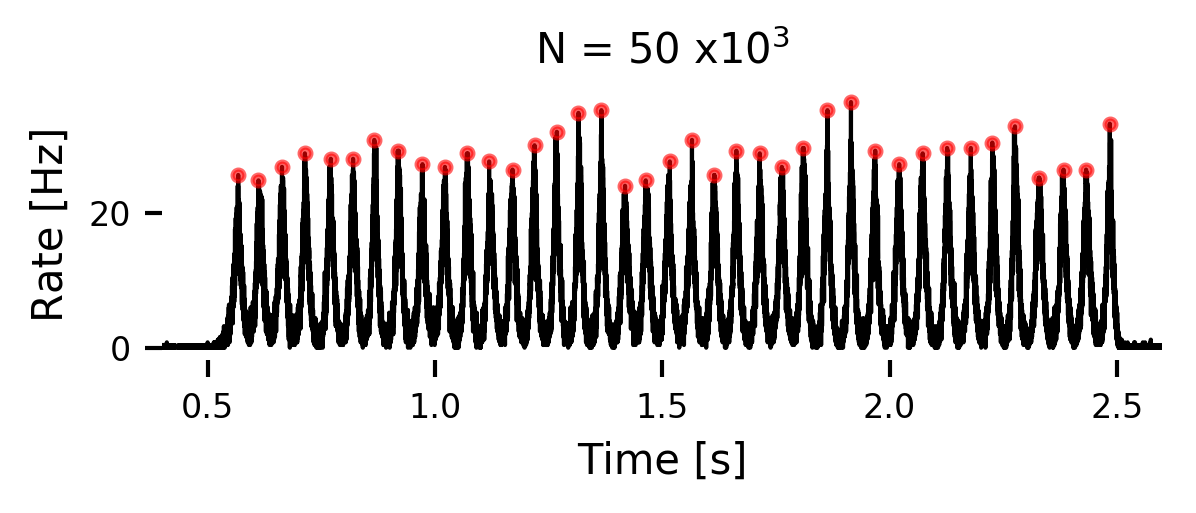

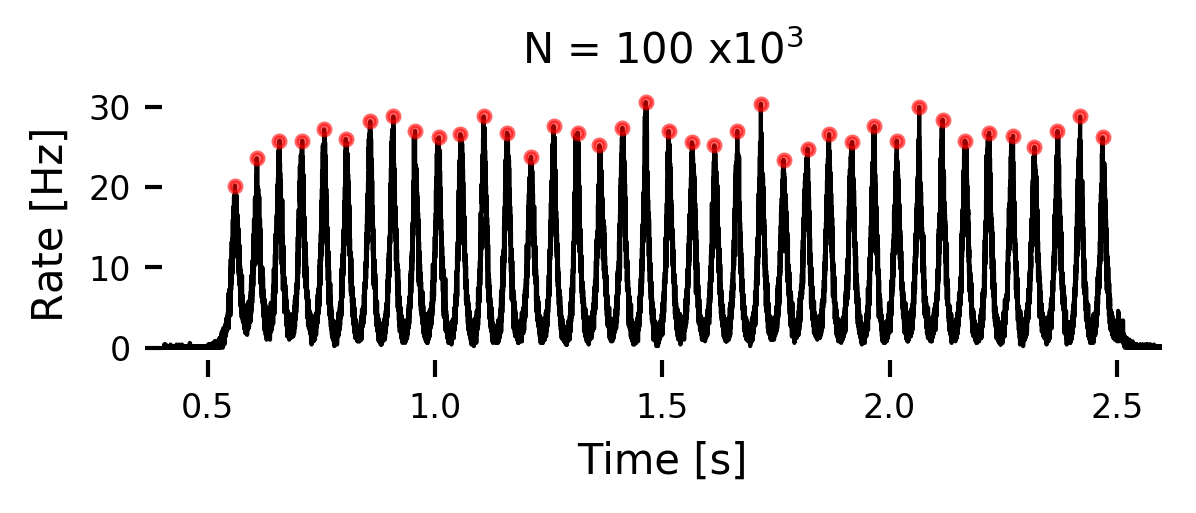

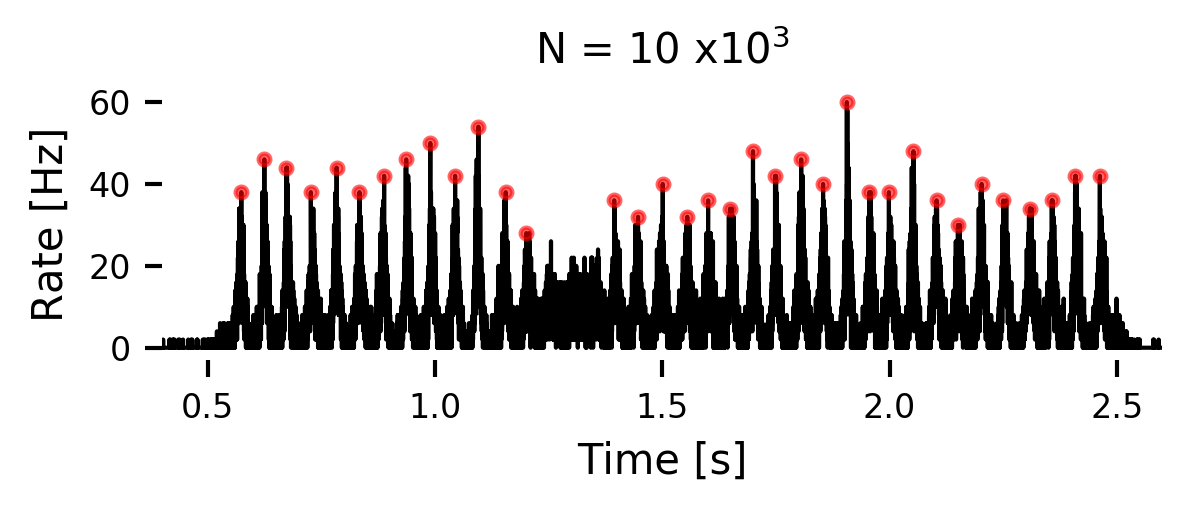

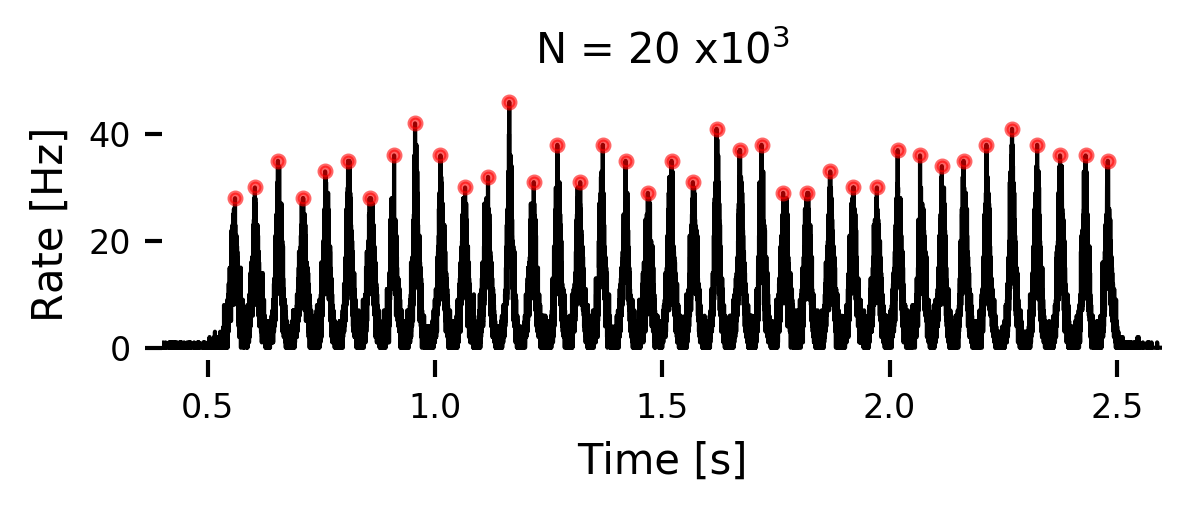

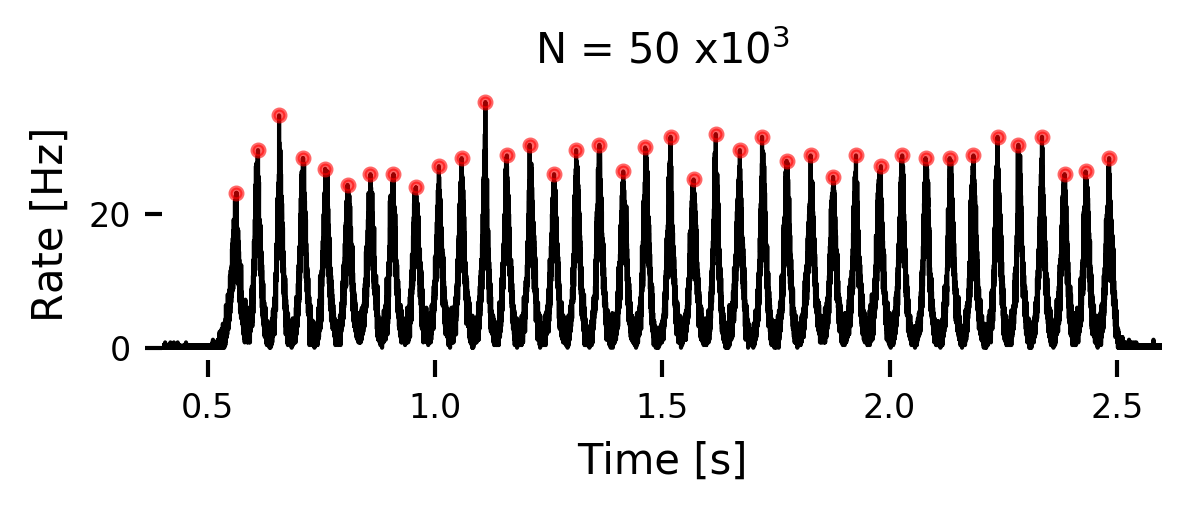

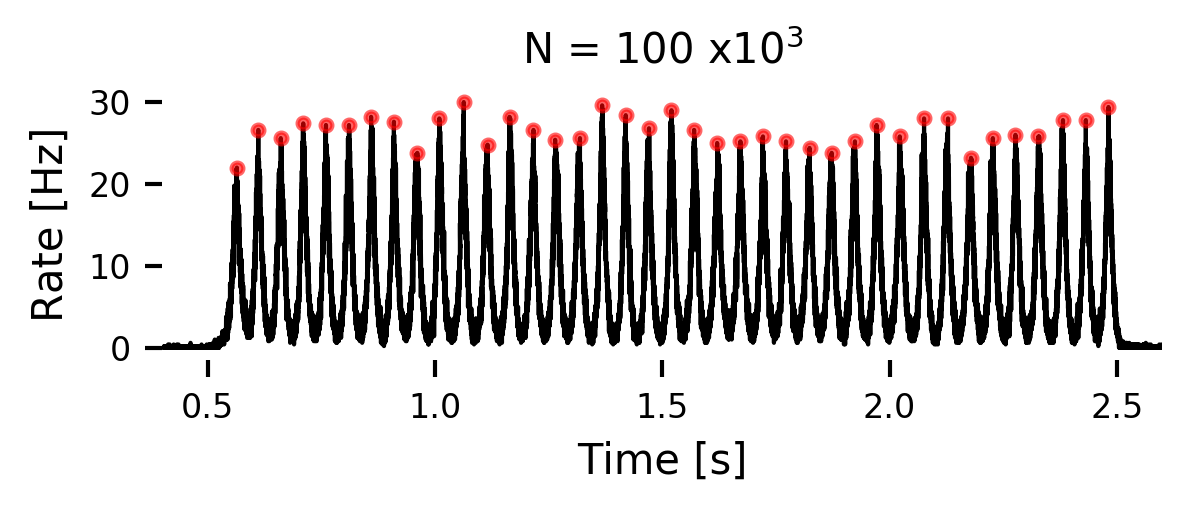

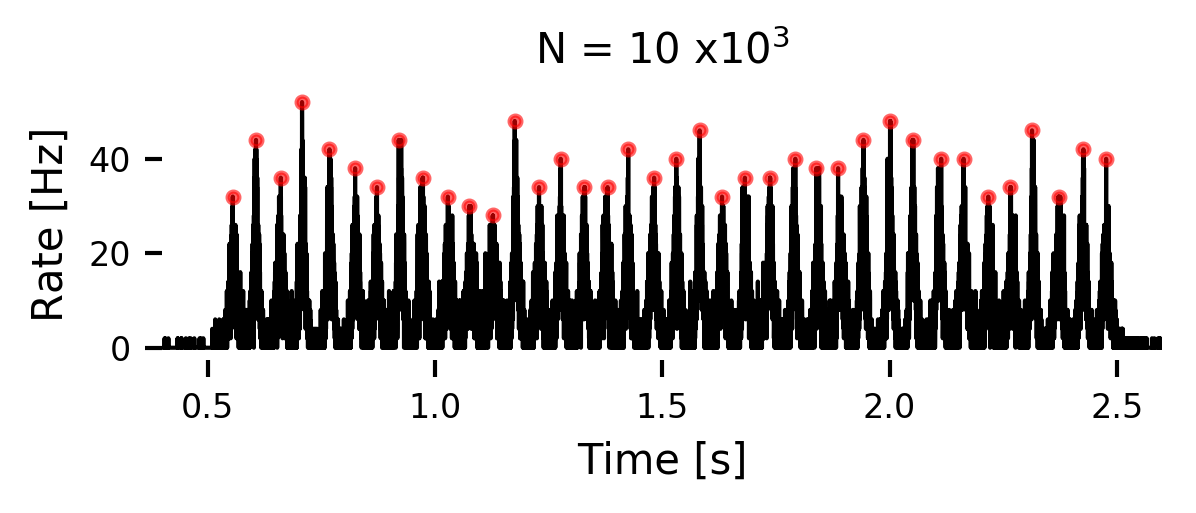

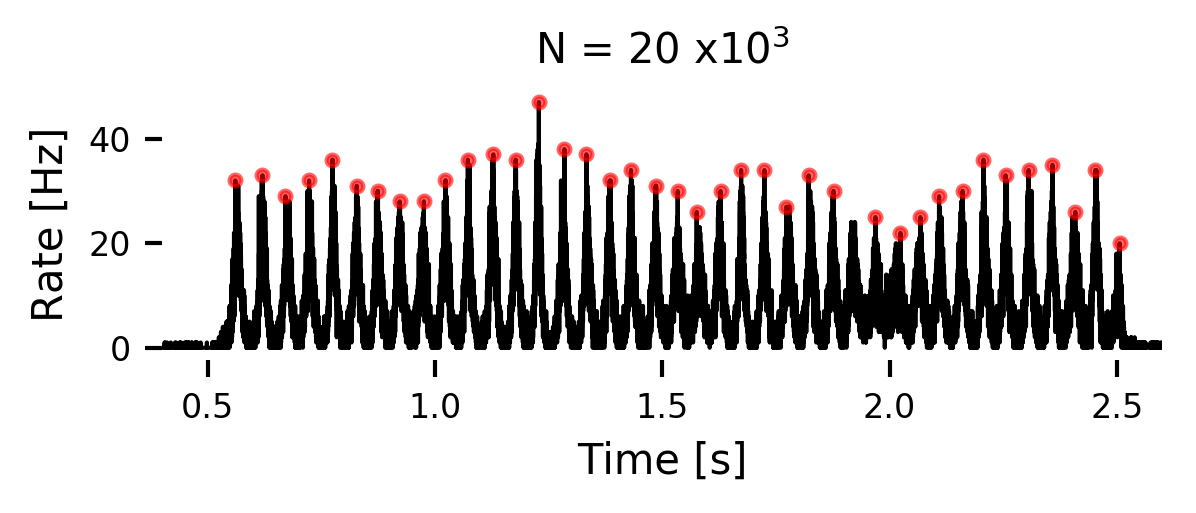

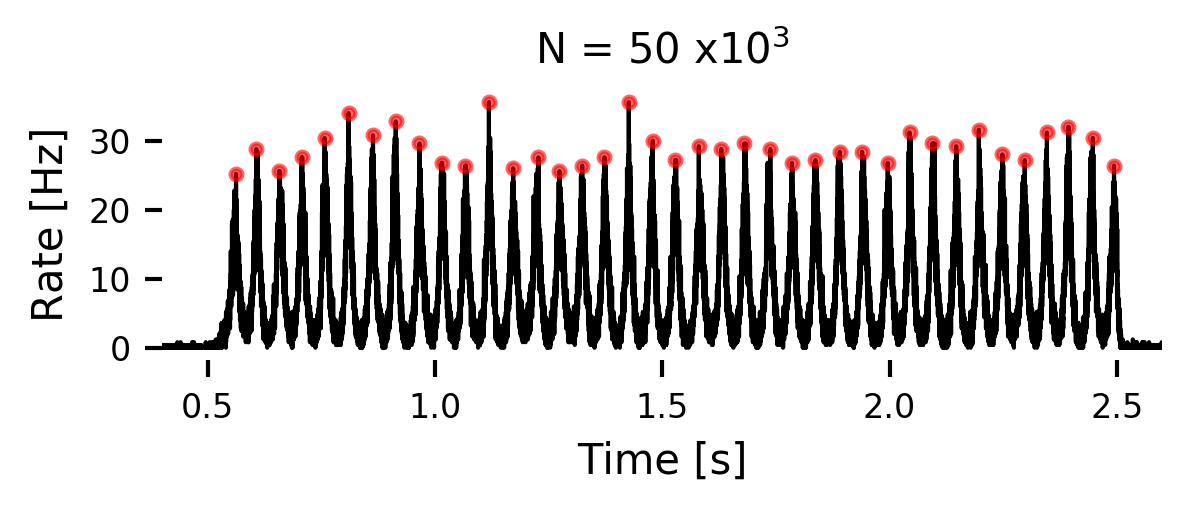

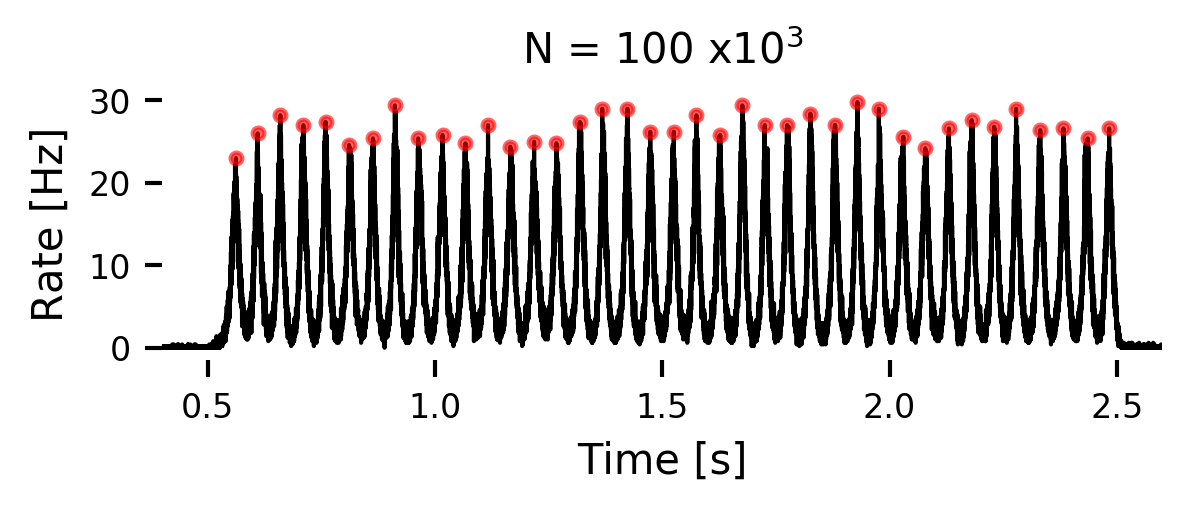

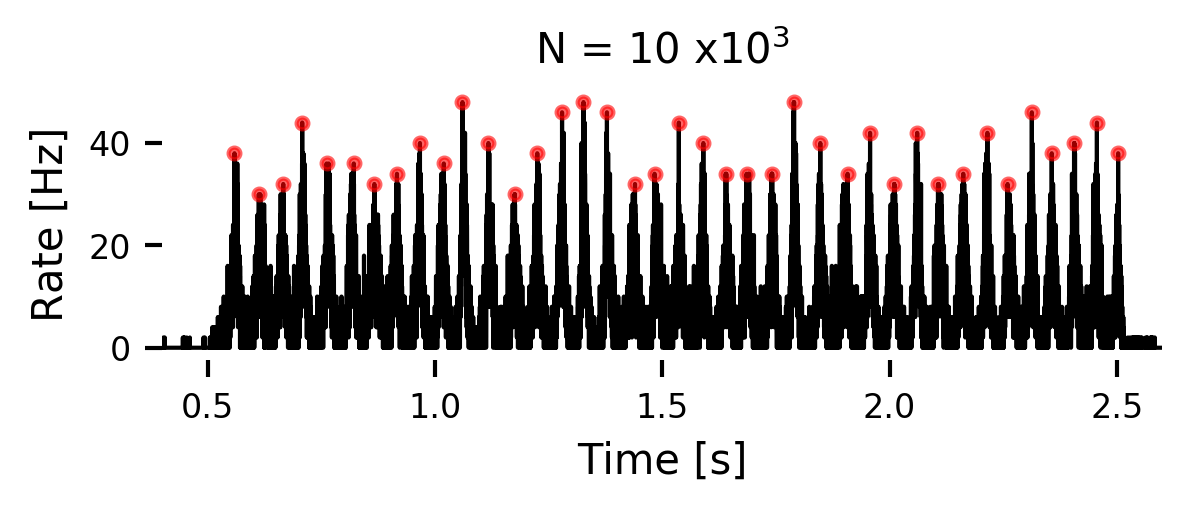

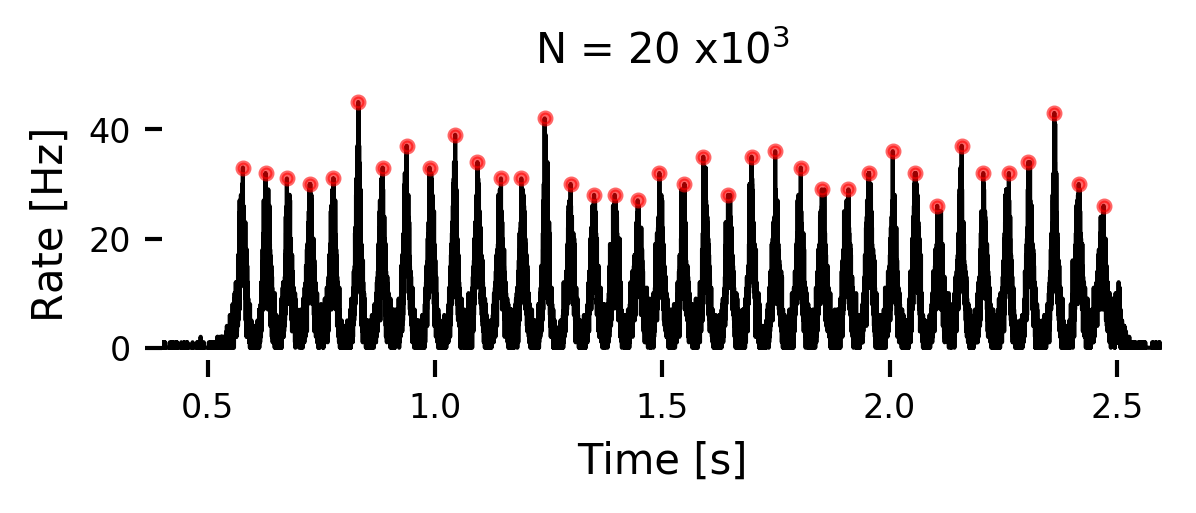

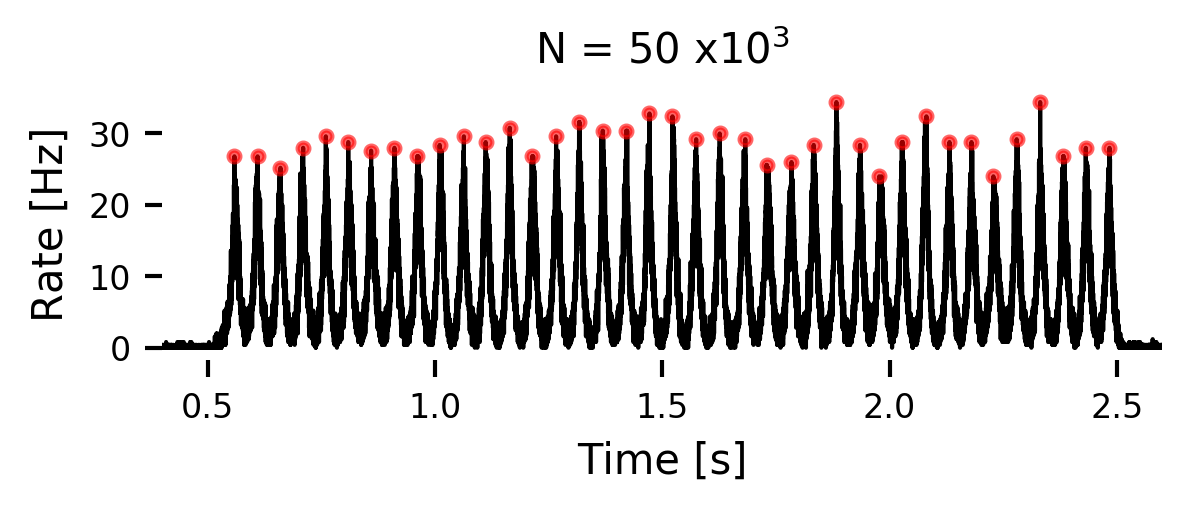

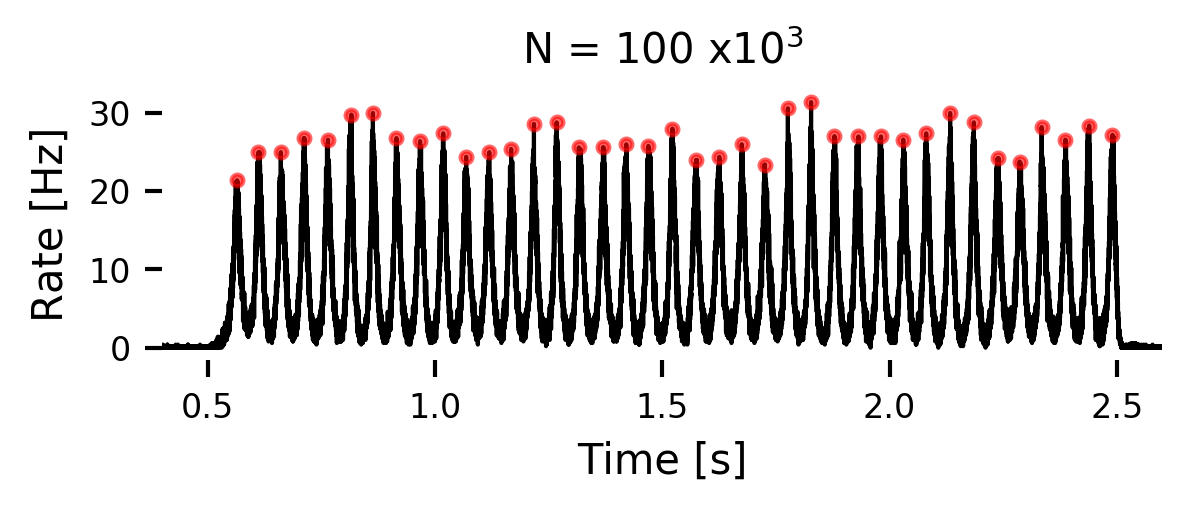

In [23]:
# find peaks and plot amplitudes of the oscillation depending on N

realpeaks = {}

for resInd, res in enumerate(resultDicts[:]):
    stimulus = res['stimulus']
    t = res['t']
    t = t/1000
    rates_exc = res['rate_exc']
    plotrange = [0.4, 2.6]
    
    N = dfResults.iloc[resInd]['N']
    
    if N not in realpeaks:
        realpeaks[N] = []
    
    smoothing = 50.0
    #peakrange=[0.1, 0.2]
    peakrange=[50, 600]
        # find peaks
    if smoothing > 0:
        a = scipy.ndimage.filters.gaussian_filter(rates_exc, smoothing) # smooth data
    maximalist = scipy.signal.find_peaks_cwt(a, np.arange(peakrange[0], peakrange[1]))
    maximalist = np.append(maximalist, len(rates_exc)-1).astype(int)
    
    plotIndex = (t>plotrange[0])&(t<plotrange[1])
    fig = plt.figure(figsize=(4.3, 1.2), dpi=300)
    plt.title("N = {} x$10^3$".format(N*2/1000), fontsize=10)
    ax = plt.gca()
    ax.plot(t[plotIndex], rates_exc[plotIndex], lw=1.0, c='k', zorder=0)
    #ax.plot(t[plotIndex], a[plotIndex], lw=0.8, c='deepskyblue', zorder=0, alpha=0.9)

    cwt_peak_amplitudes = []
    real_peak_amplitudes = []
    
    for m in maximalist:
        if t[m]>0.45 and t[m]<2.55:
            pm = 100 # steps to consider before and after cwt peak
            #plt.scatter(t[m], a[m], c='b', s=8, zorder=1)
            cwt_peak_amplitudes.append(rates_exc[m])
            peak_snippet = rates_exc[m-pm:m+pm]
            #plt.plot(rates_exc[m-100:m+100])
            real_peak_location = np.argmax(peak_snippet)
            real_peak_amplitude = rates_exc[m-pm+real_peak_location]
            plt.scatter(t[m-pm+real_peak_location], real_peak_amplitude, c='r', zorder=2, s=8, alpha=0.6)
            real_peak_amplitudes.append(real_peak_amplitude)
            realpeaks[N].append(real_peak_amplitude)
    
    plt.xlim(0.4, 2.6)
    plt.xticks([0.5, 1.0, 1.5, 2.0, 2.5])

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(direction='out', length=4, width=1, colors='k', labelsize=8)
    #ax.tick_params('y', )
    plt.xlabel("Time [s]")
    plt.ylabel("Rate [Hz]")
    plt.show()
    

In [8]:
Ns = np.asarray(list(realpeaks.keys()))
Ns.sort()
means = np.asarray([np.mean(realpeaks[N]) for N in Ns])
stds = np.asarray([np.std(realpeaks[N]) for N in Ns])

fig, axs = plt.subplots(1, 2, figsize=(9, 2), dpi=300)
plt.subplots_adjust(bottom=0.15, wspace=0.25)
Ns /= 1000
Ns = Ns*2 # two populations

axs[0].semilogx(Ns, means, c='k', marker='o', label='mean $\mu$')
axs[0].fill_between(Ns, means-stds, means+stds, color='r', alpha=0.4, label='std dev $\sigma$')
#axs[0].set_ylim(0, 48)
axs[0].set_ylabel("Amplitude [Hz]")
axs[0].legend(loc=0)

axs[1].semilogx(Ns, stds/means, c='k', marker='o')
axs[1].set_ylabel("$CV \, (\,\\frac{{\sigma}}{{\mu}}}\,$)")

for ax in axs:
    ax.set_xticks(Ns)
    ax.set_xticklabels(Ns)
    ax.set_xlabel("Neurons N (x$10^3$)")
    
#plt.ylabel("CV(amplitudes)")

#plt.grid(axis='x', lw=0.5, c='k', alpha=0.5)

#for N in Ns:
    #plt.scatter(N, np.mean(realpeaks[N]), c='k')
    #plt.scatter(N, np.mean(realpeaks[N])+np.std(realpeaks[N]), c='r')

NameError: name 'realpeaks' is not defined

## frequencies

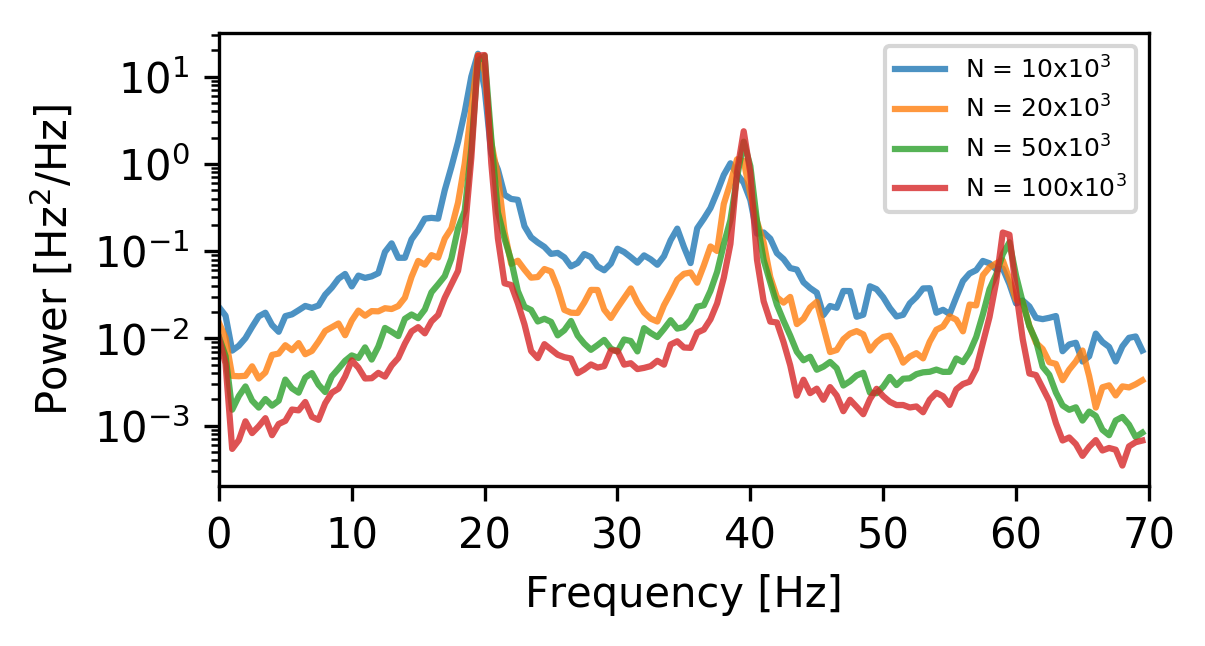

In [75]:
Ns = np.unique(dfResults['N'])
Ns.sort()
Ns /= 1000
Ns = Ns*2 # two populations

spectra = {}

for resInd, res in enumerate(resultDicts[:]):
    stimulus = res['stimulus']
    t = res['t']
    t = t/1000
    rates_exc = res['rate_exc']
    N = dfResults.iloc[resInd]['N']
    
    plotrange = [0.5, 2.5]
    plotIndex = (t>plotrange[0])&(t<plotrange[1])
    rates_exc = rates_exc[plotIndex]
    
    spectrum_windowsize = 2.0 
    f, Pxx_spec = scipy.signal.welch(
    rates_exc,
    1000/params['dt'],
    window='hanning',
    nperseg=int(spectrum_windowsize * 1000 / dt),
    scaling='spectrum')
    f = f[f < 70]
    Pxx_spec = Pxx_spec[0:len(f)]
    Pxx_spec /= np.max(Pxx_spec)
    
    if N not in spectra:
        spectra[N] = Pxx_spec
    else:
        spectra[N] += Pxx_spec

plt.figure(figsize=(4, 2), dpi=300)
Ns = np.unique(dfResults['N'])
for N in Ns:
    cols = ['C0', 'C1', 'C2', 'C3']
    plt.semilogy(f, spectra[N], c=cols[np.where(Ns==N)[0][0]], label='N = {}x10$^3$'.format(N*2/1000), alpha=0.8)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [Hz$^2$/Hz]")
plt.legend(loc=1, fontsize=6)
plt.xlim(0, 70)
plt.show()

In [69]:
np.unique(dfResults['N'])

array([ 5000, 10000, 25000, 50000])

In [70]:
Ns

array([ 10,  20,  50, 100])

In [67]:
spectra

{5000: array([  2.28462089e-02,   1.82188406e-02,   7.24202492e-03,
          8.23157086e-03,   1.00673423e-02,   1.35531370e-02,
          1.79026737e-02,   1.96910818e-02,   1.42405097e-02,
          1.19085391e-02,   1.80032234e-02,   1.88552257e-02,
          2.10272189e-02,   2.35480423e-02,   2.23946487e-02,
          2.38208097e-02,   3.16863699e-02,   3.82095080e-02,
          4.82854120e-02,   5.47376983e-02,   3.94170040e-02,
          5.24016917e-02,   4.93608353e-02,   5.14097227e-02,
          5.59025231e-02,   9.79237626e-02,   1.22743272e-01,
          8.38580120e-02,   8.39583837e-02,   1.36443966e-01,
          1.73934554e-01,   2.35804306e-01,   2.40676525e-01,
          2.35923595e-01,   4.99688371e-01,   9.22080237e-01,
          1.79051385e+00,   3.92740273e+00,   1.00156369e+01,
          1.82647985e+01,   7.28385475e+00,   1.32054931e+00,
          8.59750427e-01,   4.42692747e-01,   3.96366082e-01,
          3.86780463e-01,   1.92683011e-01,   1.43913709e-01,
  

In [100]:
m = maximalist[20]

(1.3, 1.6)

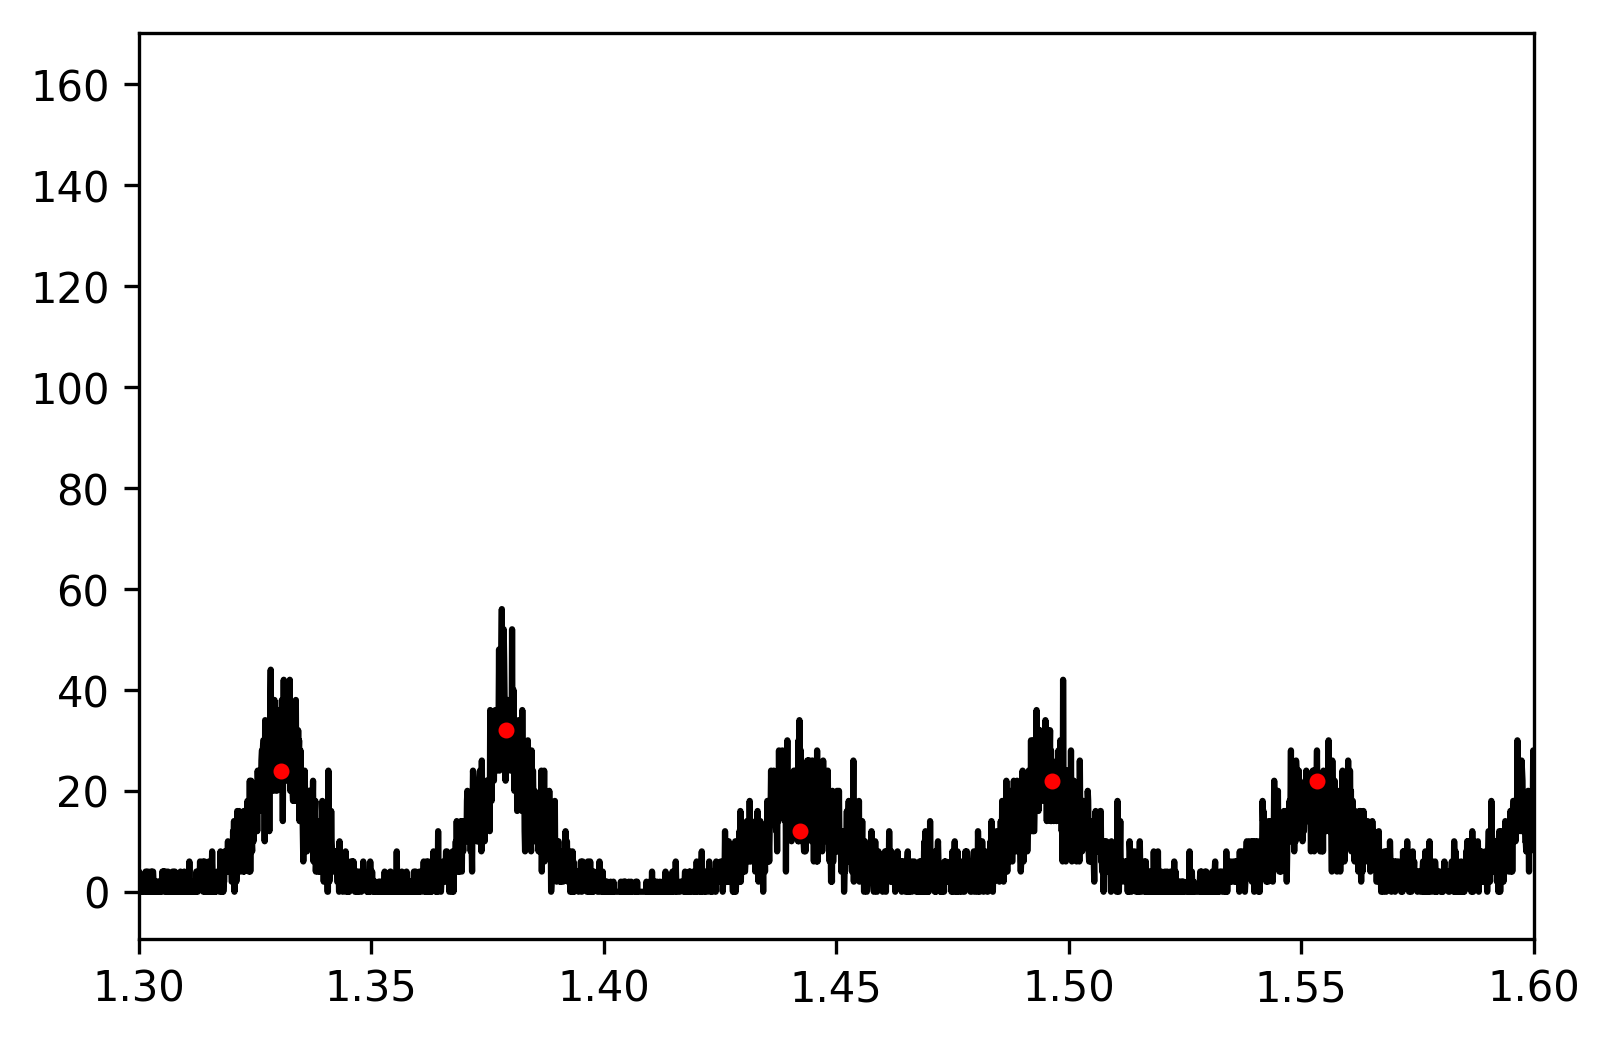

In [78]:
plt.plot(t, rates_exc, c='k', zorder=0)
for m in maximalist:
        plt.scatter(t[m], rates_exc[m], c='r', s=8, zorder=1)
        real_maximum = np.max()
plt.xlim(1.3, 1.6)

# POINT A2

In [14]:
points = ['A1', 'A2', 'A3', 'B3', 'B4']
protocols = ['dc', 'dc', 'rect', 'ac', 'ac']
amps = [0.3, 0.2, 0.5, 0.4, 0.4]
freqs = [2, 2, 3, 3, 4]

Simulating 1000 excitatory and 1000 inhibitory neurons (total 2000) ...
E spikes: 8794 I spikes: 2710
runtime: 12.0


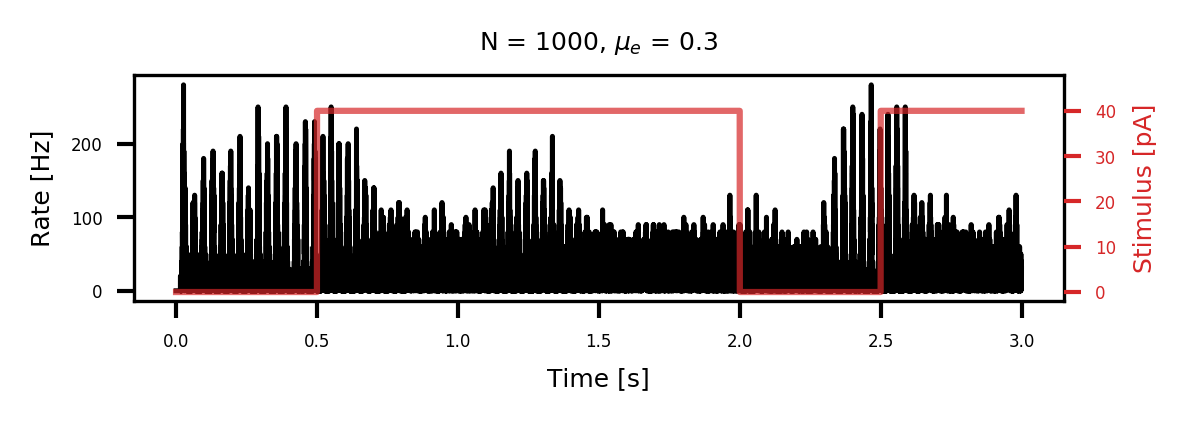

In [15]:
params = fp.loadpoint_network(params, 'A2')
params['load_point'] = 'none' # need to set this so it won't be overriden by rm.runModels
params['sigma_ou'] = 0.0
params['duration'] = 3000.0            
params['N'] = 1000
params['model'] = 'brian'
stim = protocols[1]
stim_amp = amps[1]
stim_freq = 0.6666
nostim_time = 500
n_periods = 0

params['seed'] = 42
for N in [1000]:#, 2000, 5000, 10000]:
    params['N'] = N
    stimulus = construct_stimulus(stim, stim_amp = stim_amp, stim_freq=stim_freq, nostim_before=nostim_time, n_periods=n_periods)
    params['ext_exc_current'] = stimulus 

    t, rates_exc, rates_inh, stimulus = rm.runModels(manual_params=params)
    t/=1000


    plotrange = [0.0, 3.2]

    plotIndex = (t>plotrange[0])&(t<plotrange[1])
    fig = plt.figure(figsize=(4, 1), dpi=300)
    plt.title("N = {}, $\mu_e$ = {}".format(params['N'], params['mui_ext_mean']), fontsize=6)
    ax = plt.gca()
    ax.plot(t[plotIndex], rates_exc[plotIndex], lw=1.2, c='k') 
    ax.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)

    # STIMULUS PLOT
    ax_stimulus = ax.twinx()
    stimulus = np.tile(stimulus, 2)
    stimulus = stimulus[:len(t)]
    ax_stimulus.plot(t[plotIndex], stimulus[plotIndex]*200, c='C3', lw=1.5, alpha=0.7)  

    ax_stimulus.spines['right'].set_visible(False)
    ax_stimulus.spines['top'].set_visible(False)
    ax_stimulus.spines['bottom'].set_visible(False)
    ax_stimulus.spines['left'].set_visible(False)
    ax_stimulus.tick_params(direction='out', length=4, width=1, colors='k', labelsize=4)
    ax_stimulus.tick_params('y', colors='C3')

    ax_stimulus.set_ylim(np.round(np.min(stimulus[plotIndex]*200), 2)*1.5-0.01*200, np.round(np.max(stimulus[plotIndex]*200), 2)*1.2)

    ax.set_ylabel("Rate [Hz]", fontsize=6)
    ax.set_xlabel("Time [s]", fontsize=6)
    ax_stimulus.set_ylabel("Stimulus [pA]", fontsize=6, color='C3')
    #ax.set_ylim(0, 60)
    plt.show()

In [16]:
paths.HDF_DIR = '/mnt/fastio/cakan/hdf-reviewer-questions'
paths.BRIAN2_COMPILE_DIR = '/mnt/fastio/cakan/brian2_compile/'

import pypet as pp
import datetime
import pypet_parameters as pe
import pandas as pd

parametrization = pp.cartesian_product({
    'seed':[ int(elem) for elem in np.linspace(1.0, 1.8, 10)],
    'N' : [1000, 5000, 10000, 25000, 50000]
})
print("{} parameterizations".format(len(parametrization[parametrization.keys()[0]])))

# ---- initialize pypet environment ----
trajectoryName = 'results' + datetime.datetime.now().strftime("-%Y-%m-%d-%HH-%MM-%SS")
HDF_FILE = os.path.join(paths.HDF_DIR, 'stimulus_adex_reviewer-A2.hdf')
trajectoryFileName = HDF_FILE

import multiprocessing
ncores = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncores))



env = pp.Environment(trajectory=trajectoryName,filename=trajectoryFileName,
                    file_title='adex network bifurcation diagrams with different coupling strengths J',
                    large_overview_tables=True,
                    multiproc=True,           
                    ncores=ncores,
                    wrap_mode='QUEUE',
                    log_stdout = False
                    )

# Get the trajectory from the environment
traj = env.v_trajectory
trajectoryName = traj.v_name

pe.add_parameters(traj, params)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `/mnt/fastio/cakan/hdf-reviewer-questions/stimulus_adex_reviewer-A2.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.


50 parameterizations
Number of cores: 80


In [ ]:
traj.f_explore(parametrization)
env.f_run(rm.runModels, {'manual_params':params})
env.f_disable_logging()
print("Done.")

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-12-18-20H-56M-00S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2019-12-18-20H-56M-00S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2019-12-18-20H-56M-00S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2019-12-18-20H-56M-00S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
Simulating 1000 excitatory and 1000 inhibitory neurons (total 2000) ...
Simulating 10000 excitatory and 10000 inhibitory neurons (total 20000) ...
Simulating 25000 excitatory and 25000 inhibitory neurons (total 50000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 1000 excitatory and 1000 inhibitory neurons (total 2000) ...
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
Simulating 10000 excitatory and 10000 inhibitory neurons (total 20000) ...
Simulating 25000 excitatory and 25000 inhibitory neurons (total 50000) ...
Simulating 50000 excitatory and 50000 inhibitory neurons (total 100000) ...
Simulating 1000 excitatory and 1000 inhibitory neurons (total 2000) ...
Simulating 5000 excitatory and 5000 inhibitory neurons (total 10000) ...
Simulating 10000 excitatory and 10000 inhibitory neurons (total 20000) ...
Simulating 25000 excitatory and 25000 

MainProcess pypet INFO     PROGRESS: Finished  3/50 runs [=                   ]  6.0%, remaining: 0:09:02


E spikes: 8778 I spikes: 2719
runtime: 31.6
E spikes: 8891 I spikes: 2771
E spikes: 8923 I spikes: 2731
runtime: 33.6
runtime: 33.2


MainProcess pypet INFO     PROGRESS: Finished  5/50 runs [==                  ] 10.0%, remaining: 0:05:17


E spikes: 9777 I spikes: 2968
runtime: 33.6
E spikes: 9545 I spikes: 2861
runtime: 33.9


MainProcess pypet INFO     PROGRESS: Finished  8/50 runs [===                 ] 16.0%, remaining: 0:03:10


E spikes: 9329 I spikes: 2795
E spikes: 9224 I spikes: 2838
runtime: 34.2
runtime: 35.6


MainProcess pypet INFO     PROGRESS: Finished 10/50 runs [====                ] 20.0%, remaining: 0:02:28


E spikes: 8796 I spikes: 2671
runtime: 124.3
E spikes: 8775 I spikes: 2742
E spikes: 8724 I spikes: 2726
E spikes: 8842 I spikes: 2651
runtime: 127.1
runtime: 125.8
runtime: 127.5


MainProcess pypet INFO     PROGRESS: Finished 13/50 runs [=====               ] 26.0%, remaining: 0:06:51


E spikes: 8764 I spikes: 2750
runtime: 126.6
E spikes: 8720 I spikes: 2690


MainProcess pypet INFO     PROGRESS: Finished 15/50 runs [======              ] 30.0%, remaining: 0:05:38


runtime: 125.4
E spikes: 8813 I spikes: 2706
runtime: 128.6
E spikes: 8834 I spikes: 2787
runtime: 123.8


MainProcess pypet INFO     PROGRESS: Finished 18/50 runs [=======             ] 36.0%, remaining: 0:04:20


E spikes: 8806 I spikes: 2702
E spikes: 8713 I spikes: 2691
runtime: 125.5
runtime: 124.7


MainProcess pypet INFO     PROGRESS: Finished 20/50 runs [========            ] 40.0%, remaining: 0:03:40


E spikes: 8427 I spikes: 2658
runtime: 222.7
E spikes: 8627 I spikes: 2675
runtime: 226.3
E spikes: 8608 I spikes: 2610
runtime: 232.5


MainProcess pypet INFO     PROGRESS: Finished 23/50 runs [=========           ] 46.0%, remaining: 0:05:35


E spikes: 8458 I spikes: 2580
runtime: 227.7
E spikes: 8706 I spikes: 2671
runtime: 234.5


MainProcess pypet INFO     PROGRESS: Finished 25/50 runs [==========          ] 50.0%, remaining: 0:04:46


E spikes: 8574 I spikes: 2655
runtime: 230.1
E spikes: 8763 I spikes: 2722
runtime: 236.2
E spikes: 8725 I spikes: 2724
E spikes: 8621 I spikes: 2706
runtime: 235.6
runtime: 231.7


MainProcess pypet INFO     PROGRESS: Finished 28/50 runs [===========         ] 56.0%, remaining: 0:03:47


E spikes: 8755 I spikes: 2692
runtime: 231.9


MainProcess pypet INFO     PROGRESS: Finished 30/50 runs [============        ] 60.0%, remaining: 0:03:14


E spikes: 8632 I spikes: 2707
runtime: 544.2
E spikes: 8591 I spikes: 2702
runtime: 550.6
E spikes: 8620 I spikes: 2695
runtime: 556.8


MainProcess pypet INFO     PROGRESS: Finished 33/50 runs [=============       ] 66.0%, remaining: 0:06:40


E spikes: 8650 I spikes: 2727
runtime: 563.0
E spikes: 8605 I spikes: 2657
runtime: 568.8


MainProcess pypet INFO     PROGRESS: Finished 35/50 runs [==============      ] 70.0%, remaining: 0:05:40


E spikes: 8704 I spikes: 2685
runtime: 567.4
E spikes: 8598 I spikes: 2704
E spikes: 8727 I spikes: 2747
runtime: 570.3
runtime: 570.9


MainProcess pypet INFO     PROGRESS: Finished 38/50 runs [===============     ] 76.0%, remaining: 0:04:12


E spikes: 8624 I spikes: 2678
runtime: 572.3
E spikes: 8676 I spikes: 2695
runtime: 572.5


MainProcess pypet INFO     PROGRESS: Finished 40/50 runs [================    ] 80.0%, remaining: 0:03:21


E spikes: 8526 I spikes: 2631
runtime: 1180.5
E spikes: 8819 I spikes: 2743
runtime: 1204.0
E spikes: 8556 I spikes: 2705
runtime: 1188.5


MainProcess pypet INFO     PROGRESS: Finished 43/50 runs [=================   ] 86.0%, remaining: 0:05:34


E spikes: 8707 I spikes: 2672
runtime: 1198.7
E spikes: 8610 I spikes: 2666
runtime: 1208.0
E spikes: 8737 I spikes: 2653


MainProcess pypet INFO     PROGRESS: Finished 45/50 runs [==================  ] 90.0%, remaining: 0:03:49


runtime: 1206.9
E spikes: 8563 I spikes: 2720
runtime: 1200.3
E spikes: 8681 I spikes: 2697
runtime: 1205.9
E spikes: 8575 I spikes: 2645


MainProcess pypet INFO     PROGRESS: Finished 48/50 runs [=================== ] 96.0%, remaining: 0:01:26


runtime: 1202.6
E spikes: 8671 I spikes: 2692
